# ML Models
by __Pawel Rosikiewicz__ 

---

## Setup
---

__global imports__
* I purposely placed other imports, such as my custom made functions for thsi project in each section
* to allow you fast inspection of my code, but also, copying these important to new notebooks, for pipeline development

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import set_config

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

__load functions, and classes created for that project__

In [157]:
# classifiers used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# pipeline and model selection
from sklearn import set_config
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.decomposition import PCA

# feature transformations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers
from sklearn.preprocessing import RobustScaler # creates custom transfomers

# stats
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# my custom fucntions, 
from src.utils.helper_data_loaders import load_tsv
from sklearn.metrics import classification_report
from src.utils.helper_merge_dfs import merge_data

__configurations__

## PART 1. RUN SELECTED MODELS

__I selected the foolowing__
* __most frequent baseline__, because we have two classes, and with 3/4 examples form one class, this will be difficult to improve with most models, usnig "inaproprietly" or badly prepared data
* __out of the box fast ML models__, because I have a time and resource limitation, and my mani focus was to create a working data-centric piepline, that may be used with hudreds of models and hundreds of dataset variants. These were:
    * knn
    * logistic regression
    * random forest
    
__all models were trained with__
* all the datsets that I created in notebook 3
* large number of differen hyperparameters, 

__all models provided predictions__
* to examtly the same data points, in train/valid data that allows me to perform error analysis such as:
    * consistently misclassified samples
* __IMPORTANT__; my pipeline in notebook 02 and 03, allows createing any number of train/validation dataset combinations, Ideally I woudl create several of these datsets, and evaluate each model on all of them, and performing cross-validation. It was not done only because of lack of time, but the pipeline provides all the possibilities for that.
* moreover, based on error analysis, I woudl improve my CV by stratyfying, each class, and in the future, by adding synthetic data, eg.with:
    * noise, such as missign data, 
    * feature exchnage between samples, that clustered differently in error analysis
    * completely synthetic data, created from average profiles in each strata and random noise
    

In [156]:
### function; train models, and plotting ROC and Precision-Recal Curves
def train_models(
    trainX, testX, trainy, testy, models, 
    plot_title="", figsize=(12,5), positive_class=1):
    """
        This function, train provided models
        subsequently, it plots ROC and Precision/Recal curves for these models
        and return a dictionary with statistics, such as ROc AUC and F1 for each of them
        ------------------
        . trainX, testX, trainy, testy;  imput data provided by create_data()
        . models; dict, key: model_name, value: skleanr model with provided parameters, 
        . plot_title_; str
        . figsize; tuple, eg (12,5) for plot size 
        . positive_class; int, 0, or 1, class name used as positive in confucion matrices
        
    """
    
    results=[]
    
    # create plot with 2 subplots for ROC and PR curves
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    i=0
    for model_name, model in models.items(): 
        # fit a model
        model.fit(trainX, trainy)
    
        # predict probabilities & 
        "keep probabilities for the positive outcome only"
        lr_probs = model.predict_proba(testX)
        lr_probs = lr_probs[:, 1]

        # predict class values
        yhat = model.predict(testX)         
    
    
        # .. data fpr ROC curve
        # first generate a no skill prediction (majority class), 
        "any value will do as long as it is the same for all targets"
        ns_probs = [positive_class for _ in range(len(testy))]          
        
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)   
        
    
        # .. data for precision-recall curve
        # cacluate pr curve
        lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)    
        
        # generate data for model predicting only one class (positive class)
        " its == to frequency of the class labelled as positive, typically the most frequent"
        no_skill = len(testy[testy==positive_class])/len(testy) 
        
        # .. plots
        # plot the roc curve for the model
        axs[0].plot(lr_fpr, lr_tpr, marker='.', label=model_name)

        # plot the precision-recall curves
        axs[1].plot(lr_recall, lr_precision, marker='.', label=model_name)

        # add model predicting one class only
        if i==len(models)-1:
            axs[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        else:
            pass        
        i+=1

        # count samples in eahc class
        unique, counts = np.unique(testy, return_counts=True) 

        # collect stats
        results.append({
            f"model": model_name,
            "ROC AUC": roc_auc_score(testy, lr_probs),
            "PRC AUC":  auc(lr_recall, lr_precision),
            "Recall": recall_score(testy, yhat),
            "Presision": precision_score(testy, yhat), 
            "F1": f1_score(testy, yhat),
            "counts for test data": dict(zip(unique, counts))  
        })
        
    # labels & legend      
    axs[0].set_ylim(0,1)
    axs[0].set_title("ROC curve")
    axs[0].set_xlabel('False Positive Rate  FP/(FP+TN)')
    axs[0].set_ylabel('True Positive Rate TP/(TP+FN)')
    axs[0].legend()      

    axs[1].set_ylim(0,1)
    axs[1].set_title("Precision-Recall curve")    
    axs[1].set_xlabel('Recall TP/(TP+FN)')
    axs[1].set_ylabel('Precision TP/(TP+FP)')
    axs[1].legend()     

    sns.despine()
    fig.tight_layout()
    plt.show();  

    return pd.DataFrame(results)


In [163]:
# function, ...........................................................
def load_dataset_dct(dataset_name, path, rand_nr=0, none_at=None, verbose=False):
    '''helper function to allow trainign my models used to load train/testand validaiton data 
       stored in my custom data structures
       
       parameters
        . dataset_name; dataset name provided by the used eg: P17_G100
        . path; str, full path to input files
        . rand_nr, rand nr used to create test/valid data, used for full dataset name
        . none_at; None, or 1,2, for more see merge_data 
        . verbose; bool,
            
        returns:
        . x_train, x_valid, x_test, y_train, y_valid
    '''
    os.chdir(path)

    # . find names of the dataset_to_load 
    dataset_to_load = []
    for file in glob.glob(f"{dataset_name}_v{rand_nr}__transf_data_dct.p"):
        dataset_to_load.append(file)

    # . find name of the qc reports, 
    qc_report_to_load = []
    for file in glob.glob(f"{dataset_name}_v{rand_nr}__qc_reports_dct.p"):
        qc_report_to_load.append(file)

    # . load all of them 
    with open(dataset_to_load[0], 'rb') as file: 
            dataset_dct  = pickle.load(file)  
    with open(qc_report_to_load[0], 'rb') as file: 
            qc_report_dct  = pickle.load(file)  


    # extract & combine the data ..................................  
    if verbose==True:
        print(dataset_to_load)
    else:
        pass
    x_train = merge_data(dataset_dct["tpm_data"]["train"], dataset_dct["covariants_data"]["train"], none_at=none_at, verbose=verbose)
    y_train = dataset_dct['target_data']["train"]
    x_valid = merge_data(dataset_dct["tpm_data"]["test0"], dataset_dct["covariants_data"]["test0"], none_at=none_at, verbose=verbose)
    y_valid = dataset_dct['target_data']["test0"]
    x_test = merge_data(dataset_dct["tpm_data"]["test1"], dataset_dct["covariants_data"]["test1"], none_at=none_at, verbose=verbose)

    return x_train, x_valid, x_test, y_train, y_valid
    

    
# Function, ......................................................
def prediction_table(
    trained_model, x, y, model_name, model_id, model_params, dataset_name, rand_nr
):
    "helper to create nice looking pd.series with prediciton results"
    # fill in y if it is missing
    if y is None:
        y = np.array([0]*x.shape[0])
    else:
        pass
    
    # predict class
    res_df = pd.DataFrame(
        np.c_[
            y,
            trained_model.predict(x),
            trained_model.predict_proba(x)[:, 1],
            # ...
            np.array([model_name]*y.shape[0]),
            np.array([model_id]*y.shape[0]),
            np.array([model_params]*y.shape[0]),
            np.array([dataset_name]*y.shape[0]),
            np.array([rand_nr]*y.shape[0]),
            
        ], columns=['y','yhat', 'yhat_prob', 
                    "model_name", "model_id", "model_params", "dataset_name", f"rand_nr"
                   ]
    )
    
    return res_df
             
 
# Function, ......................................................
def calculate_stats( trained_model, x, y, prefix, verbose=False):
    '''helper to create nice looking pd.series with prediciton results
    
        examples for plots:
        . precision-recall curves
            no_skill = len(y[y==1]) / len(y)
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
            plt.plot(recall, precision, marker='.', label='Logistic')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend()
            plt.show()

        . ROC curve
            ns_probs = [1 for _ in range(len(y))] # any value is ok, as long as it is the same for all
            ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs) # its no skill curce, in the middle, 
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            plt.plot(fpr, tpr, marker='.', label='Logistic')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.show()
    '''

    # setup
    y=y
    y_hat=trained_model.predict(x)
    y_hat_prob=trained_model.predict_proba(x)[:, 1] # of class 1, p>0.5, its class=1

    # . count samples in eahc class
    unique, counts = np.unique(y, return_counts=True) 
    class_counts = dict(zip(unique, counts))
    
    
    # curves
    
    # .. calculate roc curve
    noskill_probs = [1 for _ in range(len(y))] # any value is ok, as long as it is the same for all
    noskill_fpr, noskill_tpr, _ = roc_curve(y, noskill_probs) # its no skill curce, in the middle, 
    model_fpr, model_tpr, _ = roc_curve(y, y_hat_prob)
        
    # .. calcluate pr curve    
    noskill_pr = len(y[y==1])/len(y)
    model_precision, model_recall, _ = precision_recall_curve(y, y_hat_prob)

    # store the results
    
    # .. basic stats
    stats = {
        f'acc_{prefix}' : model.score(x, y),
        f'f1_{prefix}' : f1_score(y, y_hat),
        f'recall_{prefix}' : recall_score(y, y_hat),
        f'precision_{prefix}' : precision_score(y, y_hat),
        f'ROC_AUC_{prefix}' : roc_auc_score(y, y_hat_prob),
        f'PRC_AUC_{prefix}':  auc(model_recall, model_precision),
        f'class_counts_{prefix}': class_counts
    }
    
    
    # make plots to see how does it looks
    if verbose==True:
        
        # ROC CURVE
        ns_probs = [1 for _ in range(len(y))] # any value is ok, as long as it is the same for all
        ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs) # its no skill curce, in the middle, 
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(model_fpr, model_tpr, marker='.', label='Logistic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()  
        
        # PRC - precision-recall curves
        no_skill = len(y[y==1]) / len(y)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        plt.plot(model_recall, model_precision, marker='.', label='Logistic')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

    else:
        pass
    
    
    return stats

## __(A) Knn model__

In [ ]:
model_name = "knn"
rand_nr_list = [0,1,2] # ie. there are 3 datasets for cv
dataset_name_list = ["P17_G100", "P17_G2000", "P17_G2000_PCA",
                     "P17_G100_LOG", "P17_G2000_LOG", "P17_G2000_LOG_PCA"] # 6 dataset varinats prepared in different way, 
param_grid = ParameterGrid({  
            'n_neighbors':    list(range(10, 20, 30)),    # I do not use k==1, ! # I tried higher values and they were not very usefull
            'weights':        ['uniform','distance'], # Weighting function
            'p':              [2],                    # L1 and L2 distance metrics
        })
model = KNeighborsClassifier()
path = PATH_data_interim
rand_nr=0
none_at=1
verbose=True


param_grid = ParameterGrid({  
            'n_neighbors':    [10, 20, 30],    # I do not use k==1, ! # I tried higher values and they were not very usefull
            'weights':        ['uniform', 'distance'], # Weighting function
            'p':              [1, 2],                    # L1 and L2 distance metrics
        })

len(param_grid)

In [ ]:
### function; train models, and plotting ROC and Precision-Recal Curves
def train_models(
    trainX, testX, trainy, testy, models, 
    plot_title="", figsize=(12,5), positive_class=1):
    """
        This function, train provided models
        subsequently, it plots ROC and Precision/Recal curves for these models
        and return a dictionary with statistics, such as ROc AUC and F1 for each of them
        ------------------
        . trainX, testX, trainy, testy;  imput data provided by create_data()
        . models; dict, key: model_name, value: skleanr model with provided parameters, 
        . plot_title_; str
        . figsize; tuple, eg (12,5) for plot size 
        . positive_class; int, 0, or 1, class name used as positive in confucion matrices
        
    """
    
    results=[]
    
    # create plot with 2 subplots for ROC and PR curves
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    i=0
    for model_name, model in models.items(): 
        # fit a model
        model.fit(trainX, trainy)
    
        # predict probabilities & 
        "keep probabilities for the positive outcome only"
        lr_probs = model.predict_proba(testX)
        lr_probs = lr_probs[:, 1]

        # predict class values
        yhat = model.predict(testX)         
    
    
        # .. data fpr ROC curve
        # first generate a no skill prediction (majority class), 
        "any value will do as long as it is the same for all targets"
        ns_probs = [positive_class for _ in range(len(testy))]          
        
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)   
        
    
        # .. data for precision-recall curve
        # cacluate pr curve
        lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)    
        
        # generate data for model predicting only one class (positive class)
        " its == to frequency of the class labelled as positive, typically the most frequent"
        no_skill = len(testy[testy==positive_class])/len(testy) 
        
        # .. plots
        # plot the roc curve for the model
        axs[0].plot(lr_fpr, lr_tpr, marker='.', label=model_name)

        # plot the precision-recall curves
        axs[1].plot(lr_recall, lr_precision, marker='.', label=model_name)

        # add model predicting one class only
        if i==len(models)-1:
            axs[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
            axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        else:
            pass        
        i+=1

        # count samples in eahc class
        unique, counts = np.unique(testy, return_counts=True) 

        # collect stats
        results.append({
            f"model": model_name,
            "ROC AUC": roc_auc_score(testy, lr_probs),
            "PRC AUC":  auc(lr_recall, lr_precision),
            "Recall": recall_score(testy, yhat),
            "Presision": precision_score(testy, yhat), 
            "F1": f1_score(testy, yhat),
            "counts for test data": dict(zip(unique, counts))  
        })
        
    # labels & legend      
    axs[0].set_ylim(0,1)
    axs[0].set_title("ROC curve")
    axs[0].set_xlabel('False Positive Rate  FP/(FP+TN)')
    axs[0].set_ylabel('True Positive Rate TP/(TP+FN)')
    axs[0].legend()      

    axs[1].set_ylim(0,1)
    axs[1].set_title("Precision-Recall curve")    
    axs[1].set_xlabel('Recall TP/(TP+FN)')
    axs[1].set_ylabel('Precision TP/(TP+FP)')
    axs[1].legend()     

    sns.despine()
    fig.tight_layout()
    plt.show();  

    return pd.DataFrame(results)



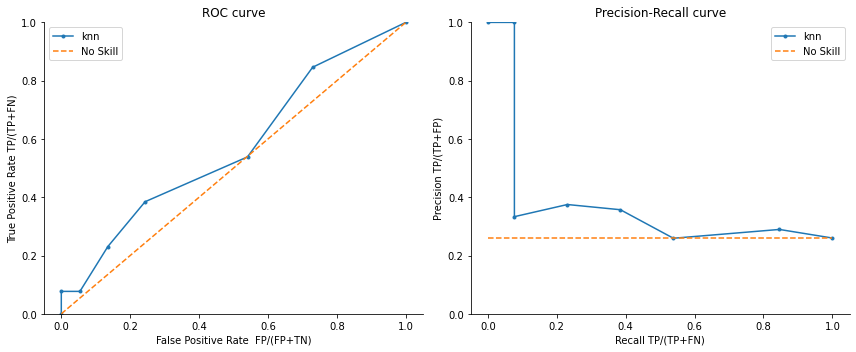

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.567568  0.361832  0.076923        1.0  0.142857   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


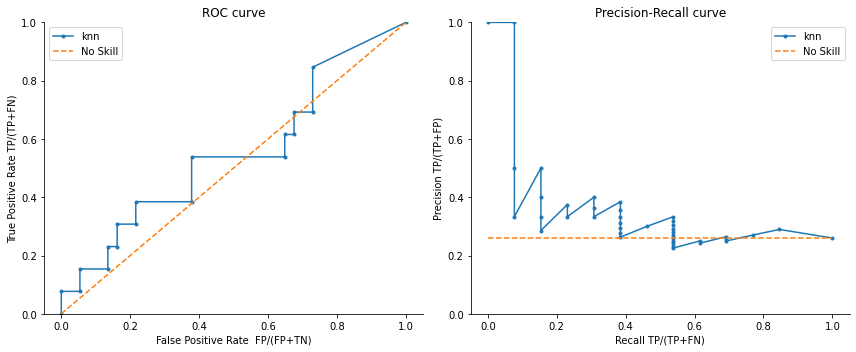

model   ROC AUC   PRC AUC    Recall  Presision     F1 counts for test data
0   knn  0.550936  0.357835  0.076923   0.333333  0.125       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


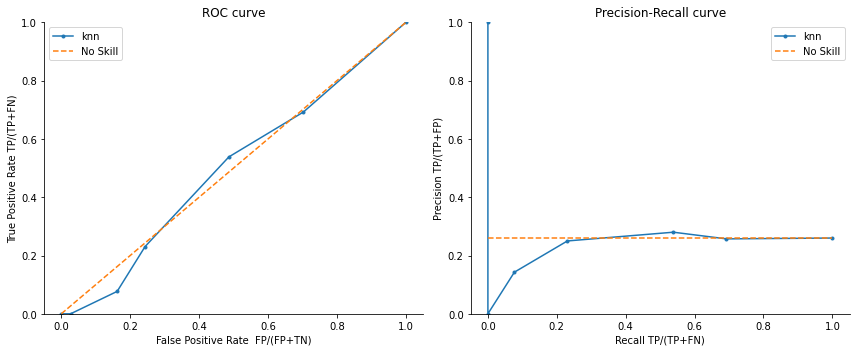

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.495842  0.238132     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


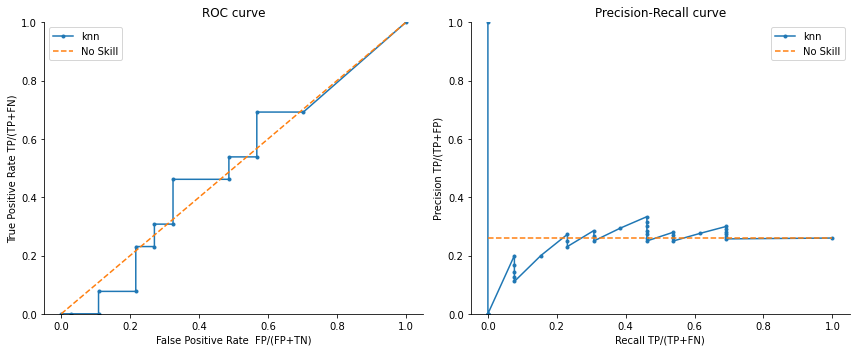

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.50104  0.245084     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


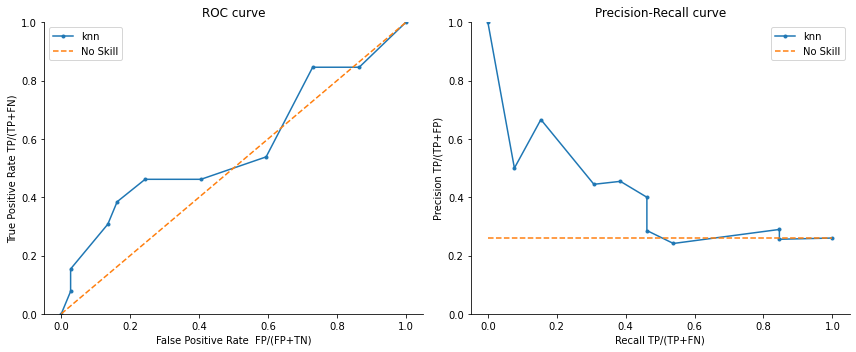

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.571726  0.397098     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


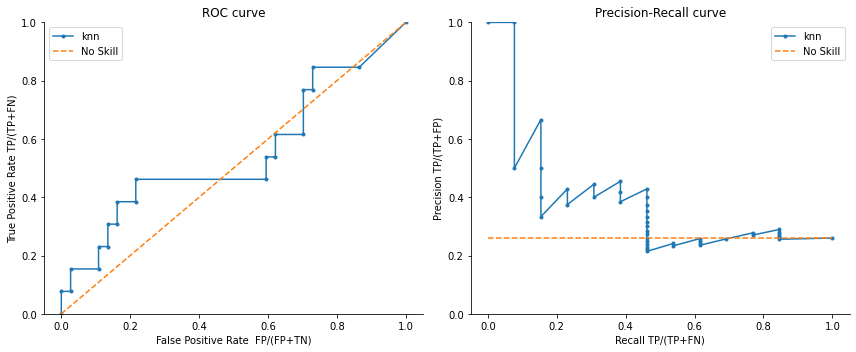

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.548857  0.383905  0.076923        1.0  0.142857   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


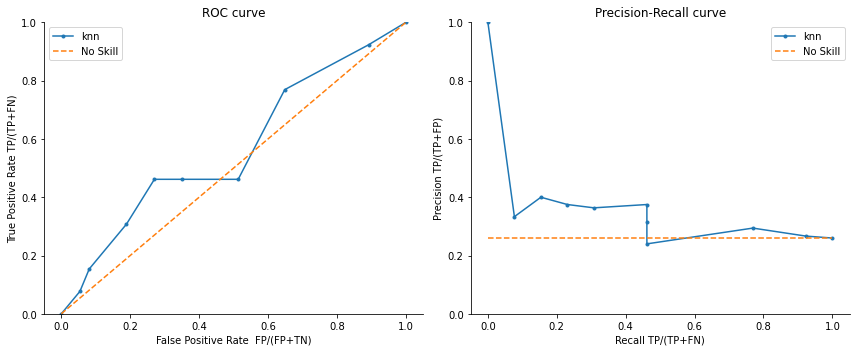

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.566528  0.340088     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


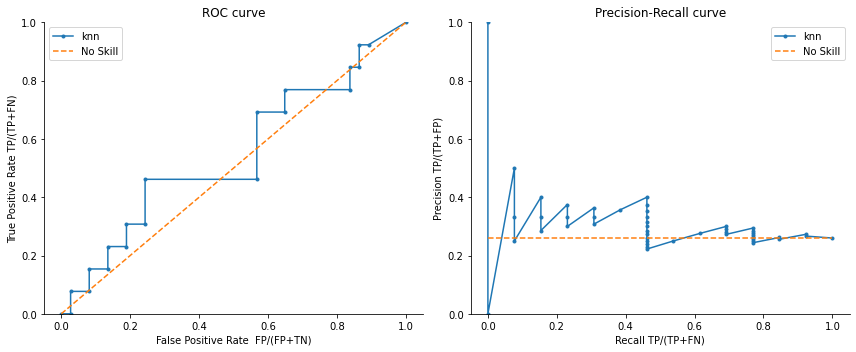

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.544699  0.292236     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


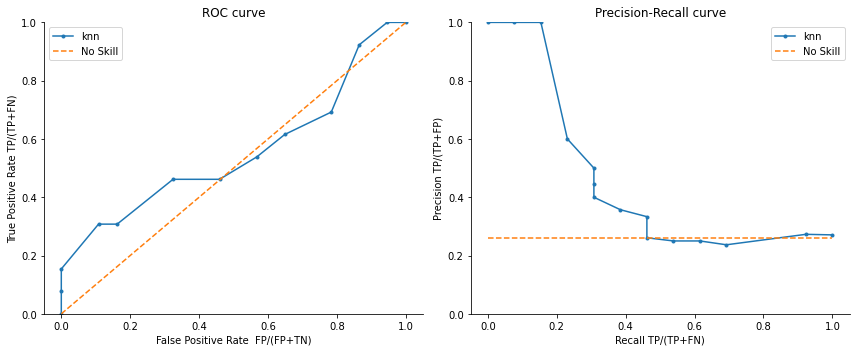

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.553015  0.450677     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


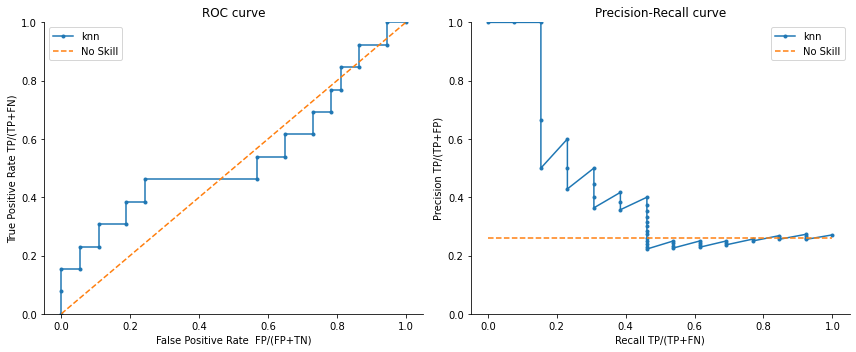

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.54262  0.425341     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


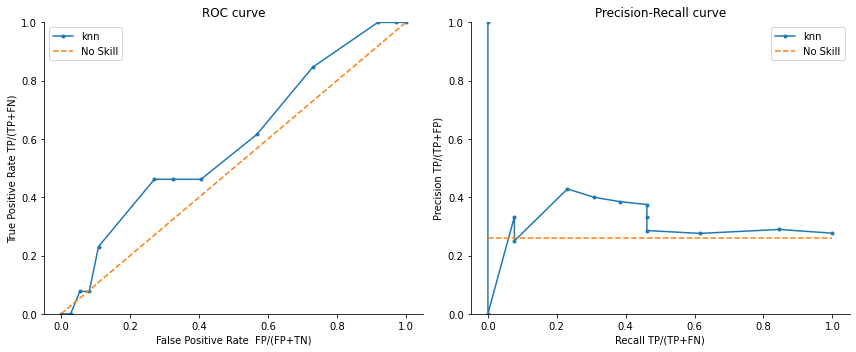

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587318  0.308253     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


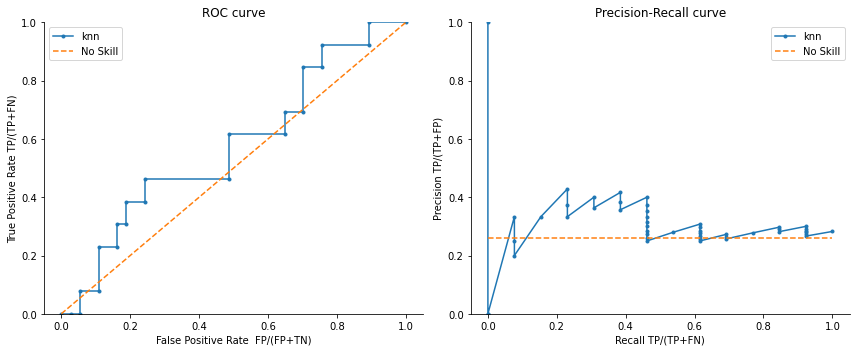

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.573805  0.299273     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100 - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


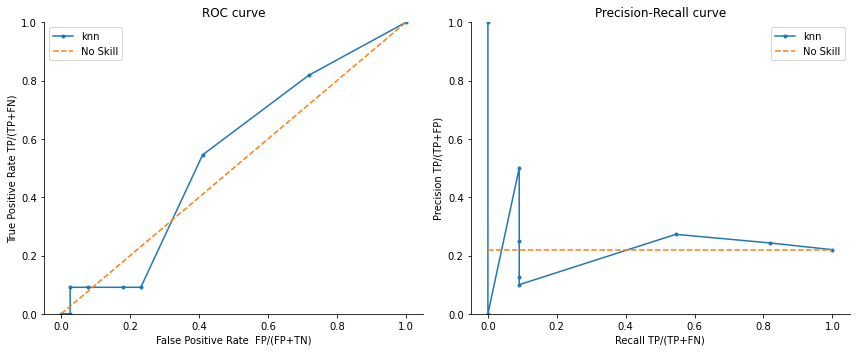

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.541958  0.219911  0.090909        0.5  0.153846   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


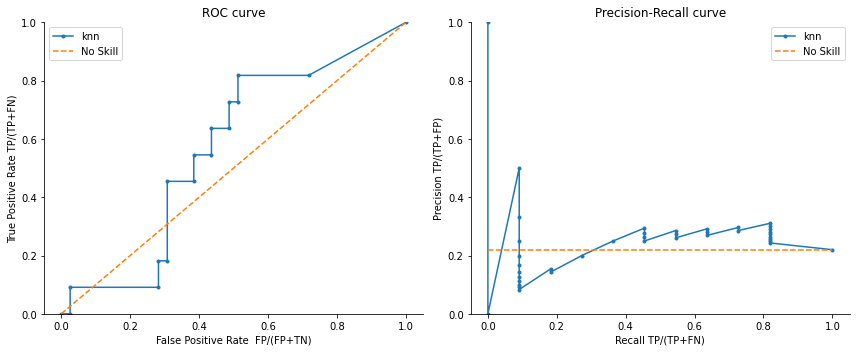

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.566434  0.238658  0.090909   0.333333  0.142857   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


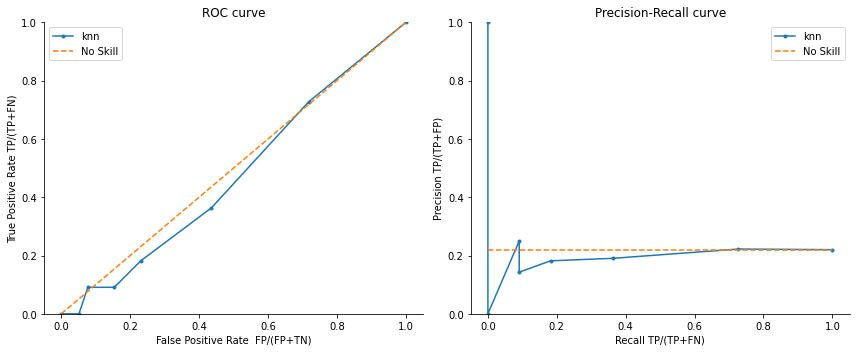

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.472028  0.195306  0.090909       0.25  0.133333   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


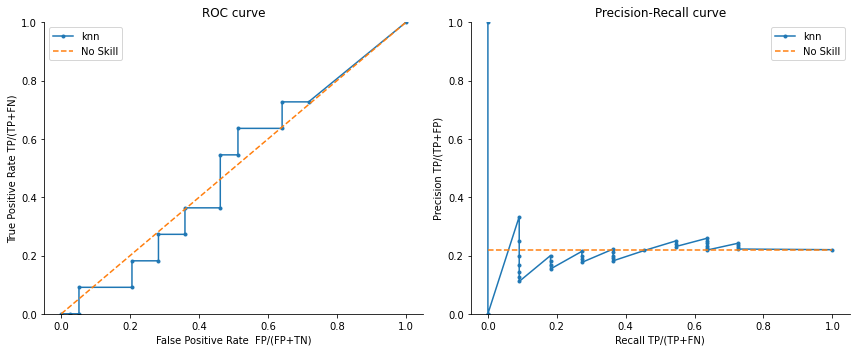

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.495338  0.207079  0.090909       0.25  0.133333   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


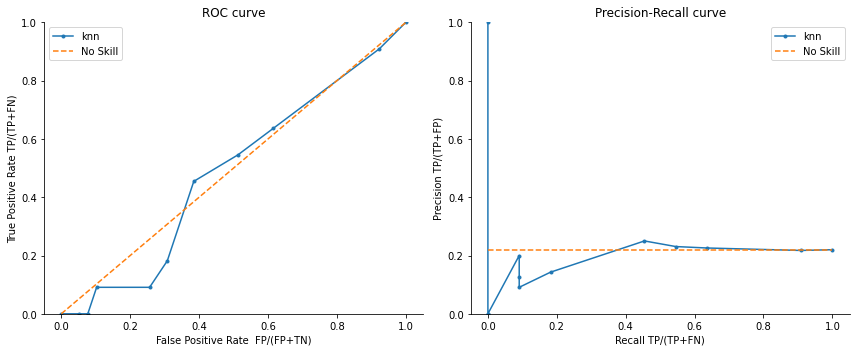

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.482517  0.196212     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


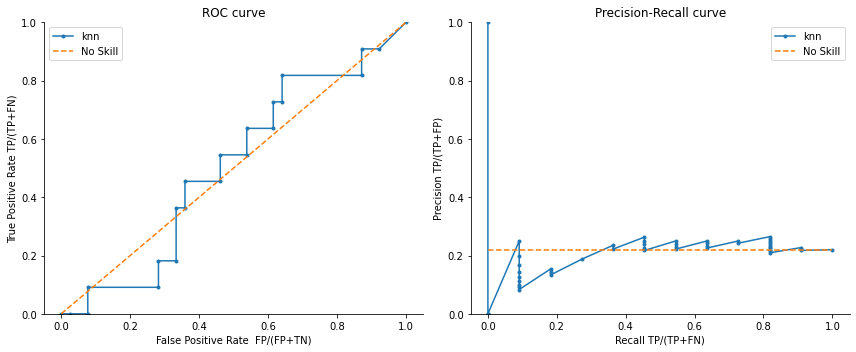

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.502331  0.205123     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


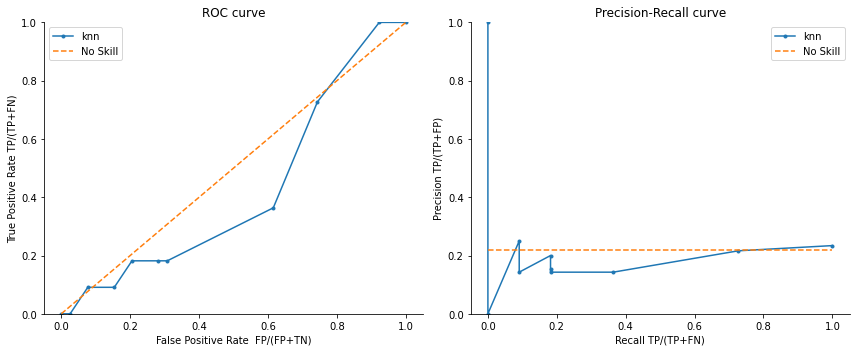

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.420746  0.179607     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


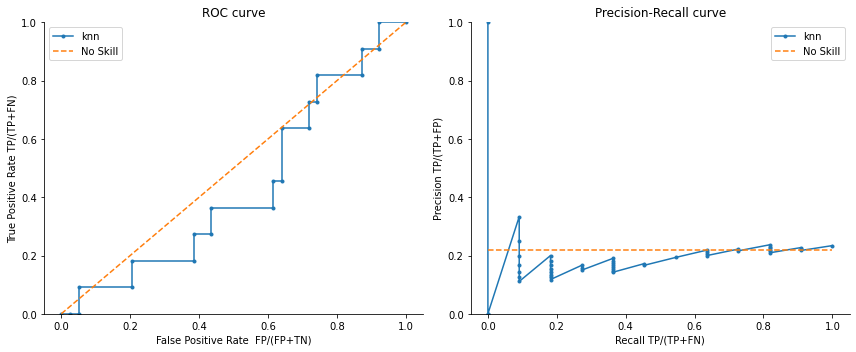

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.433566  0.187287     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


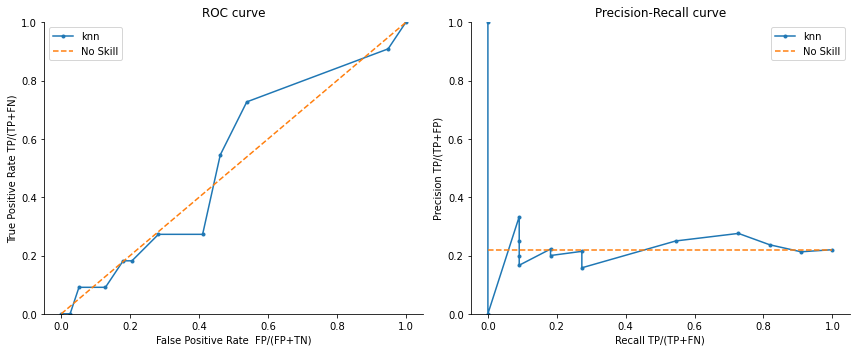

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.526807   0.2185     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


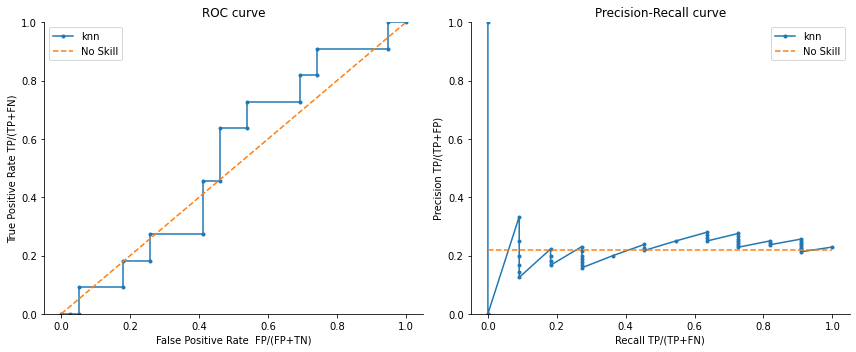

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.531469  0.218681     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


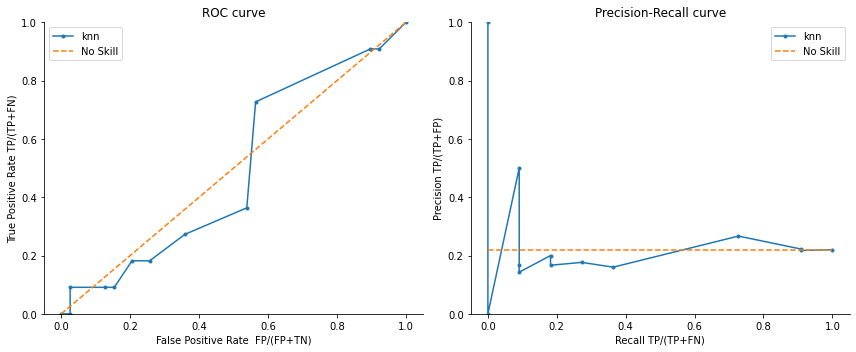

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.491841  0.211105     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


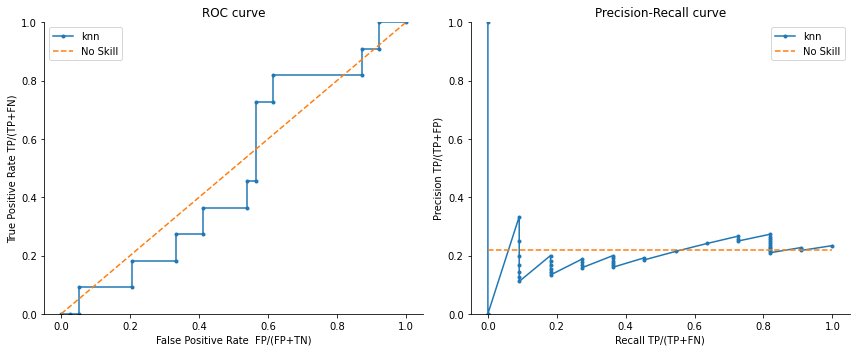

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.487179  0.202245     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


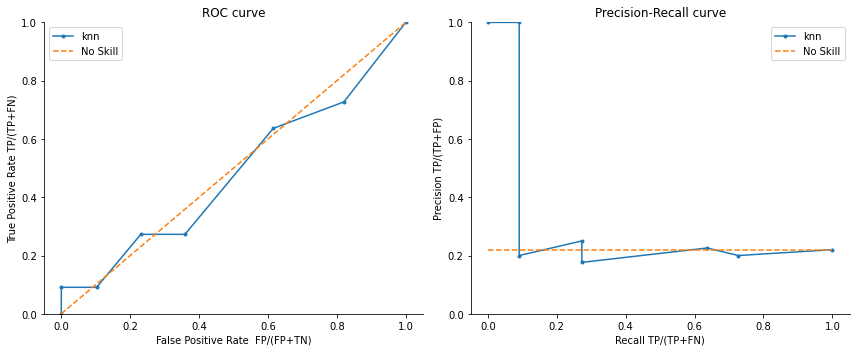

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.479021  0.281587  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


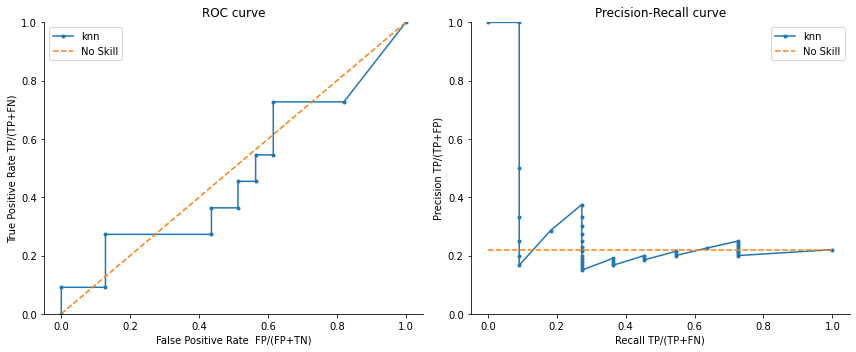

model   ROC AUC  PRC AUC    Recall  Presision        F1 counts for test data
0   knn  0.479021  0.29006  0.090909        0.5  0.153846       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


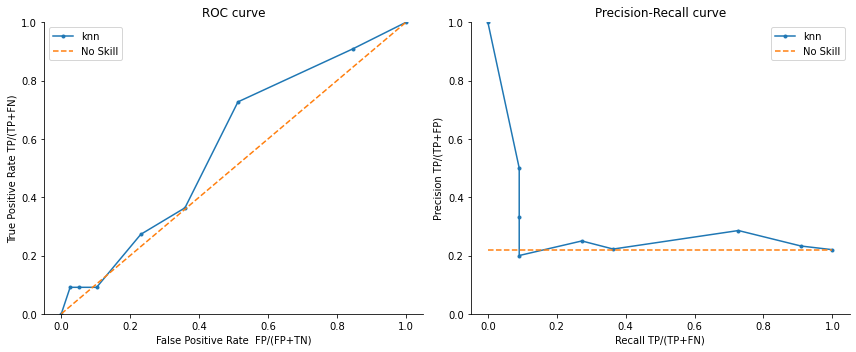

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.575758  0.290594  0.090909   0.333333  0.142857   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


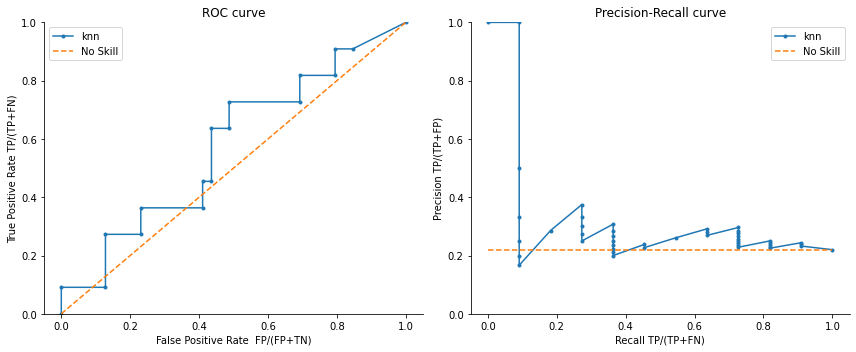

model   ROC AUC   PRC AUC    Recall  Presision     F1 counts for test data
0   knn  0.575758  0.323415  0.090909        0.2  0.125       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


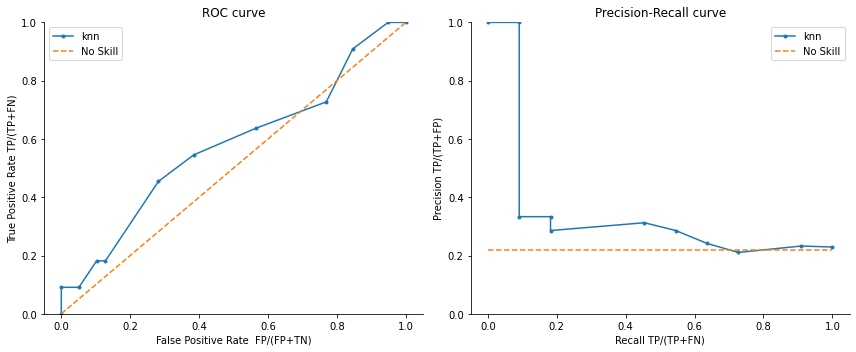

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.574592  0.335746     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


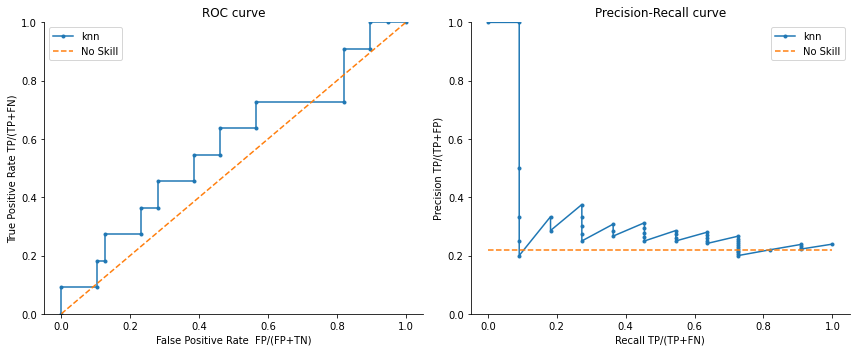

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.573427  0.329234  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


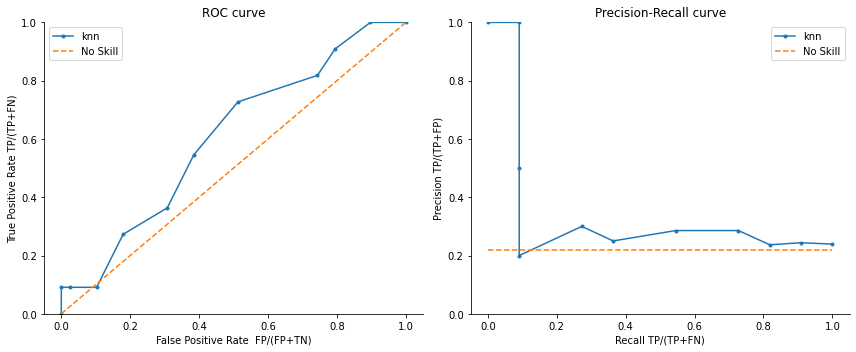

model  ROC AUC   PRC AUC    Recall  Presision        F1 counts for test data
0   knn  0.60373  0.329574  0.090909        1.0  0.166667       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


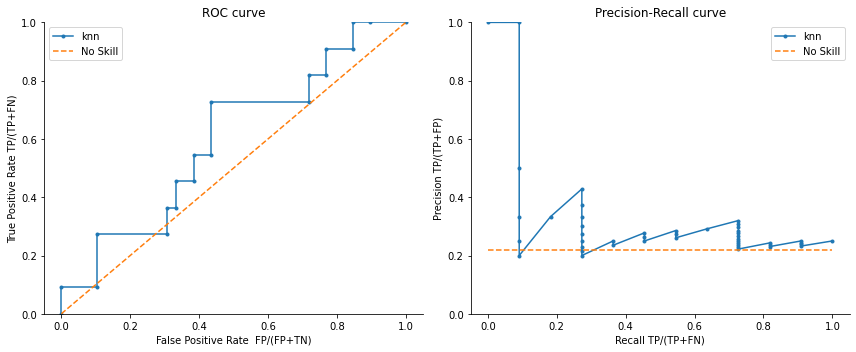

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.596737  0.335774  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


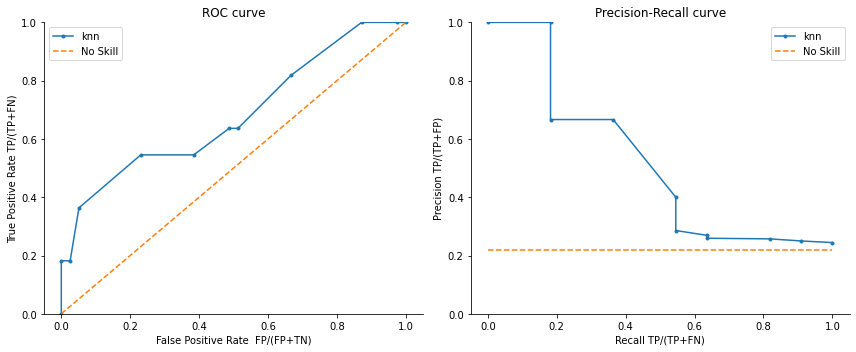

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.680653  0.517697     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


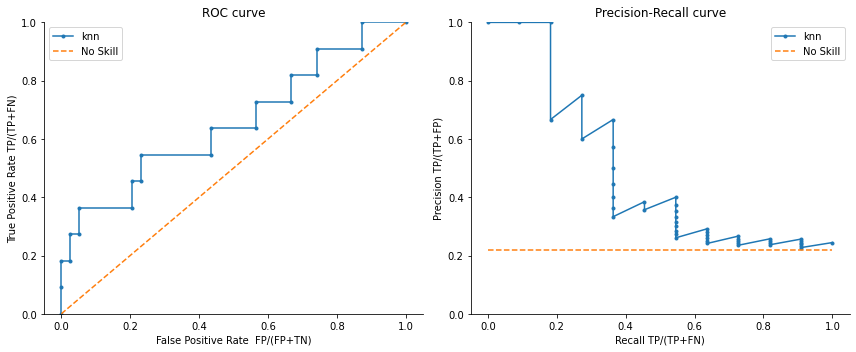

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.655012  0.485292     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


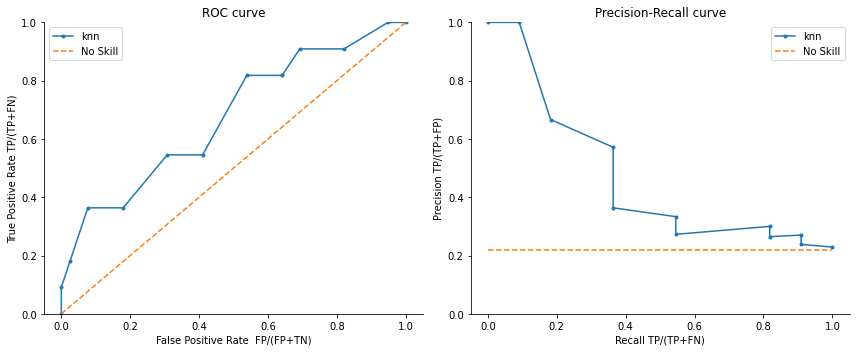

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.674825  0.466237     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


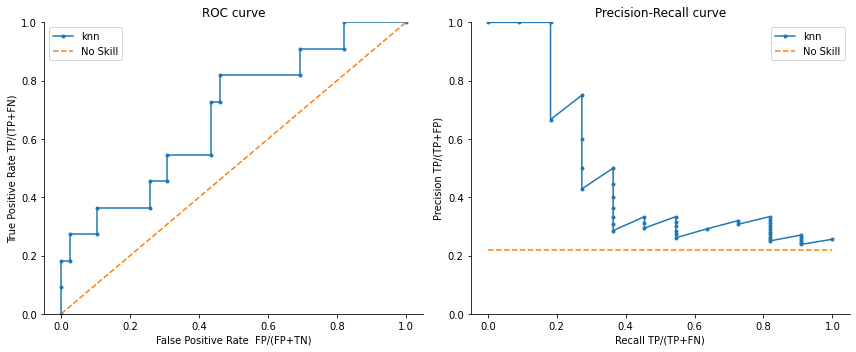

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.678322  0.473234     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100 - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


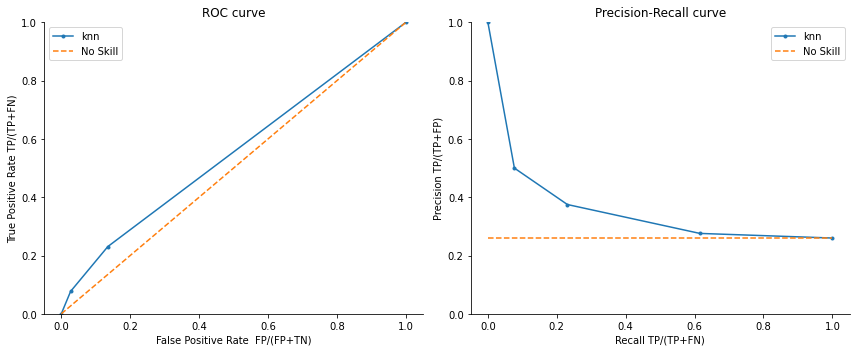

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.549896  0.353216     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


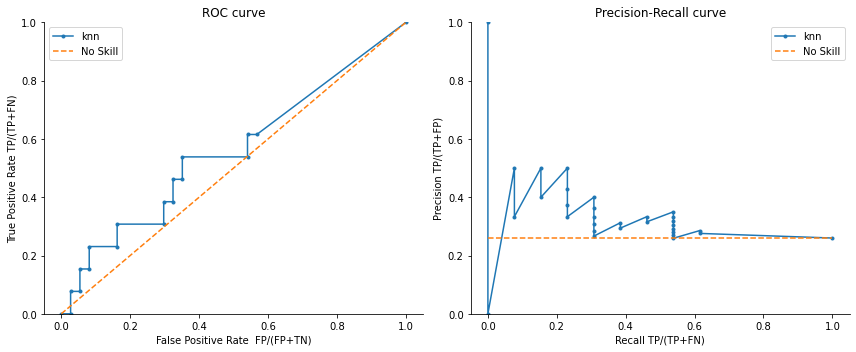

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.557173  0.310129     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


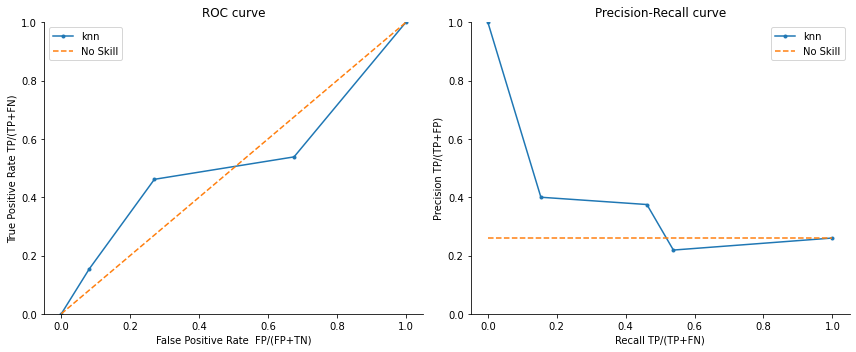

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.516632  0.36024     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


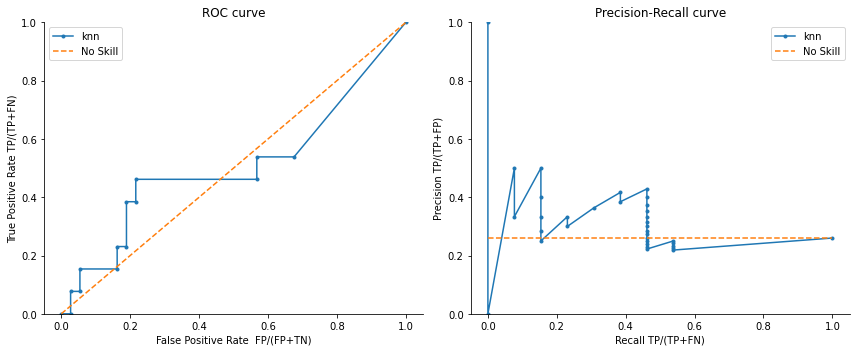

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.505198  0.289174     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


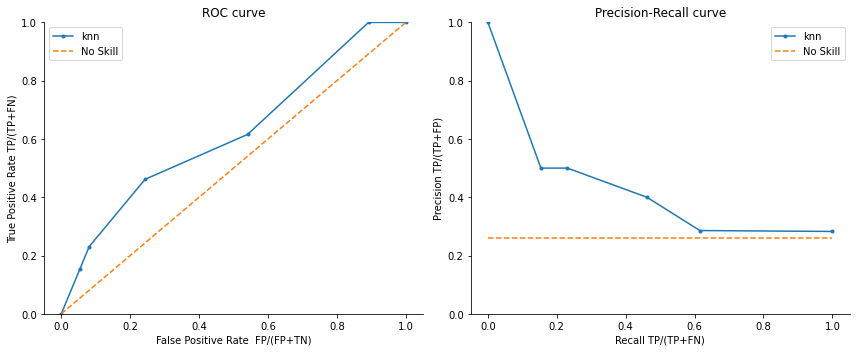

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.617464  0.419732     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


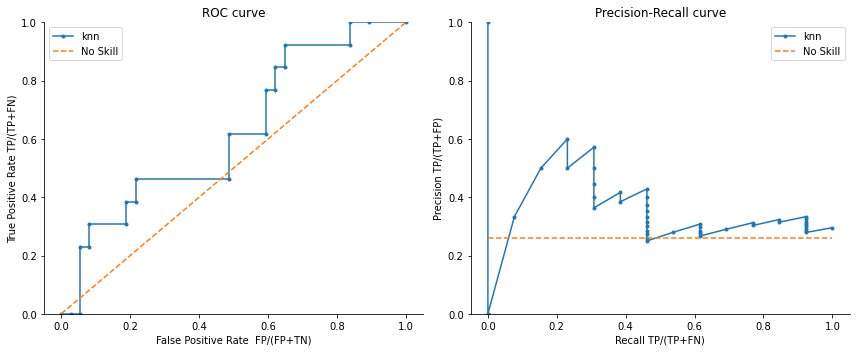

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.621622  0.348377     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


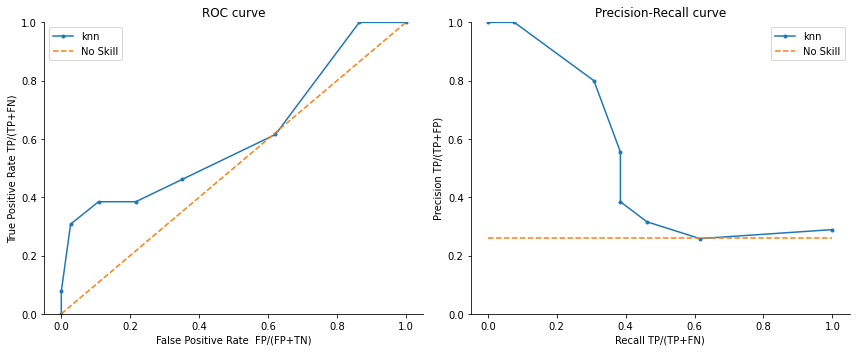

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.609148  0.513017     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


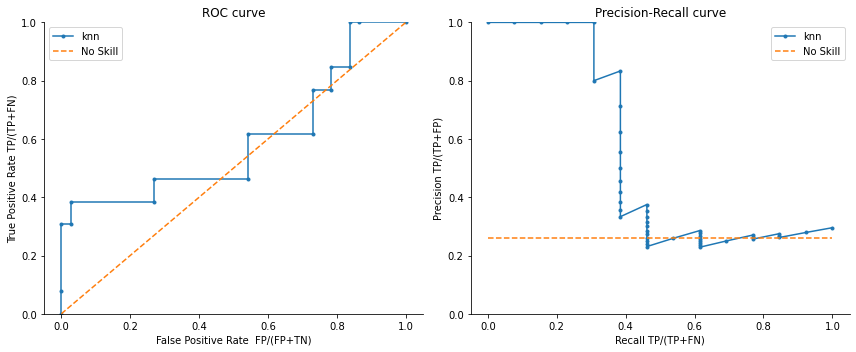

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.592516  0.539324     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


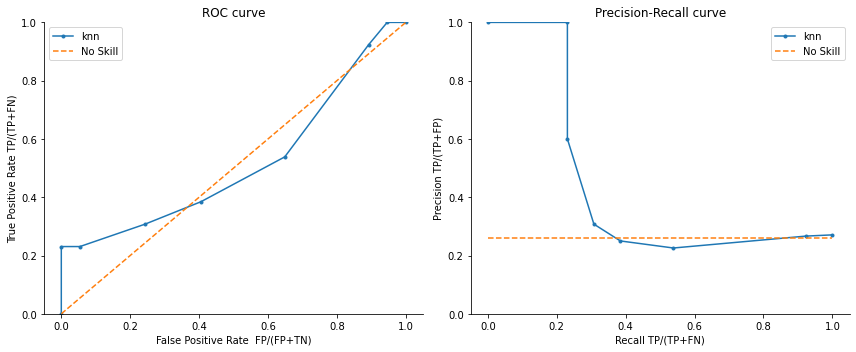

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.515593  0.43911     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


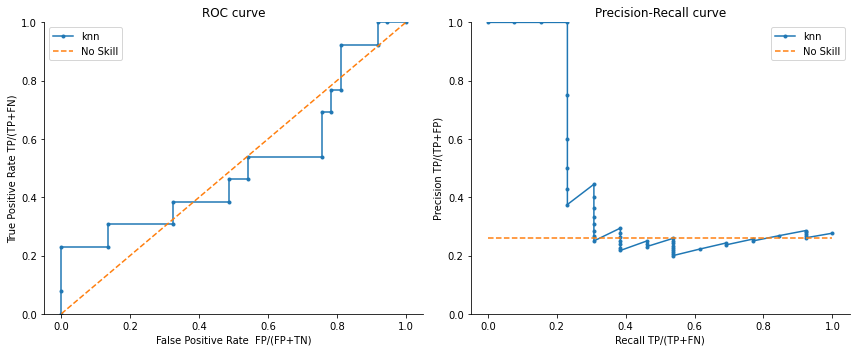

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.513514  0.435065     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


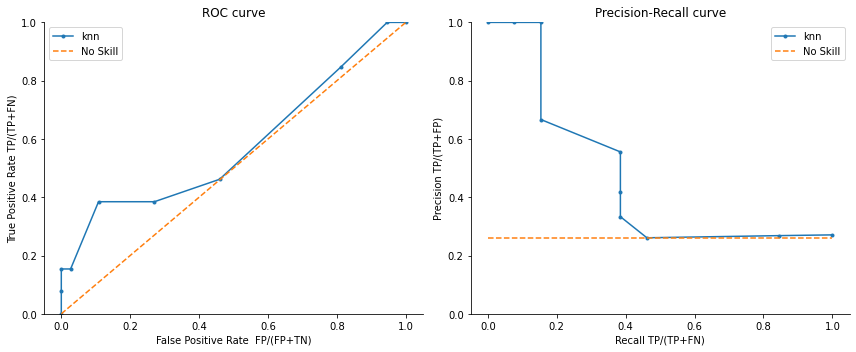

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.576923  0.460959     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


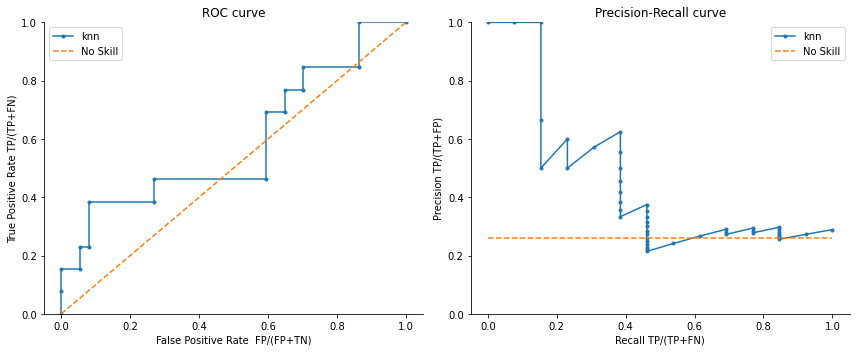

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.588358  0.45496     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000 - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


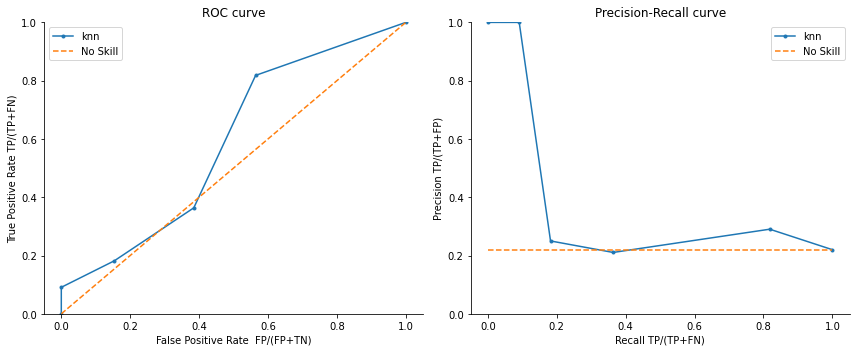

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.586247  0.349816     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


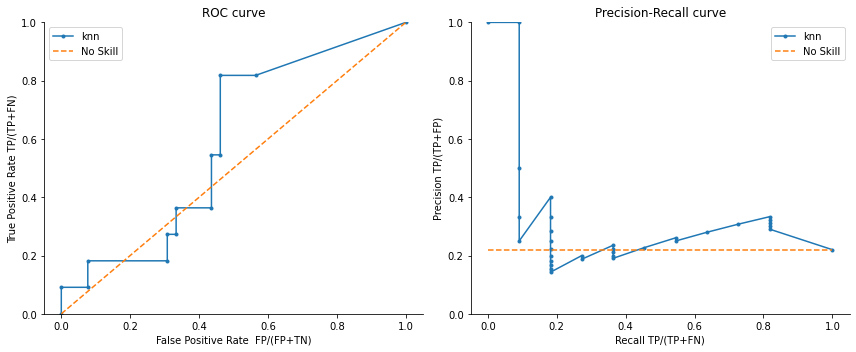

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587413  0.322768     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


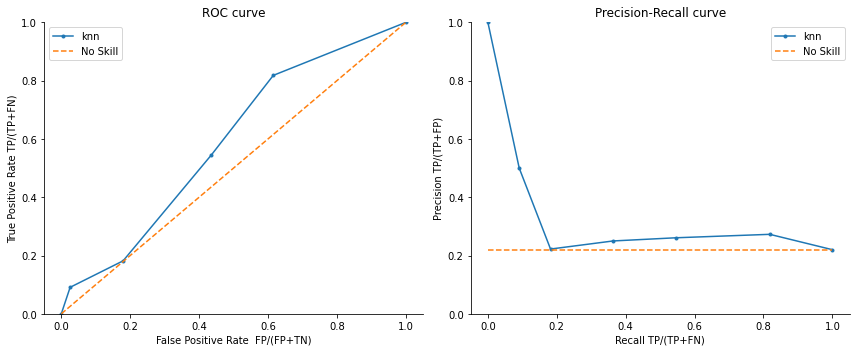

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587413  0.307939     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


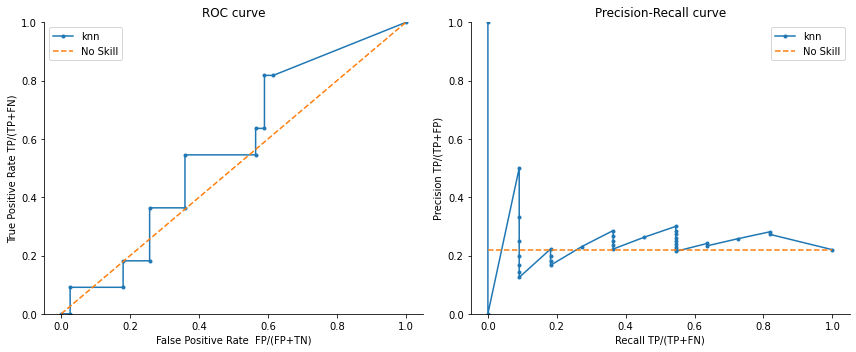

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.564103  0.240069  0.090909        0.5  0.153846   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


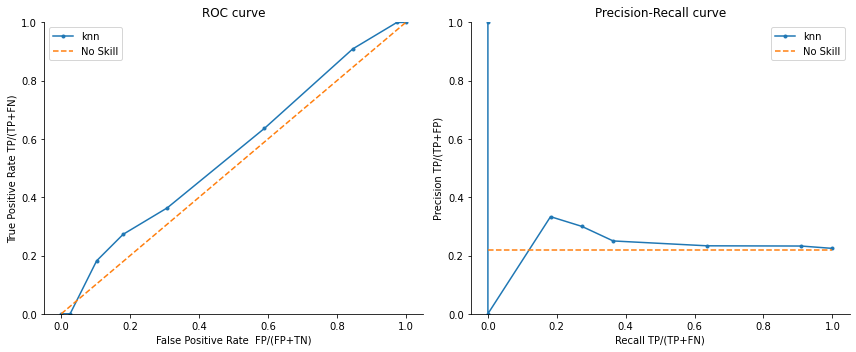

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.552448  0.234306     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


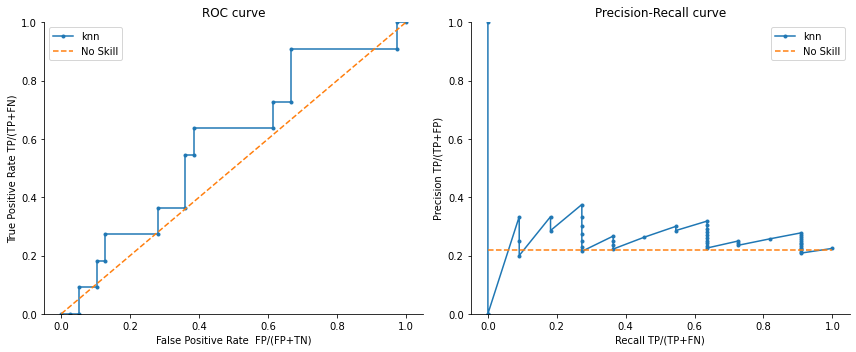

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.582751  0.254398     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


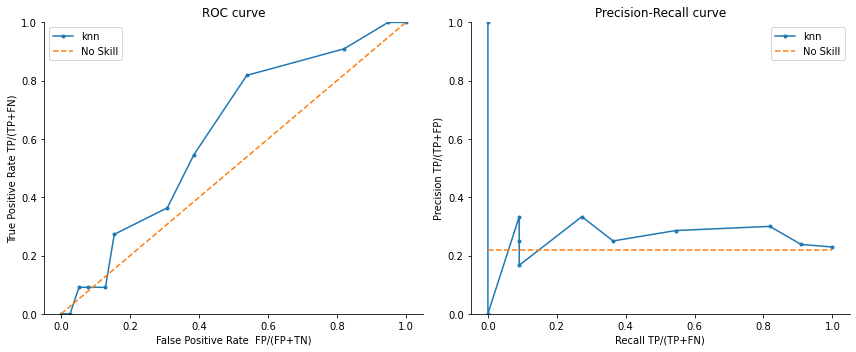

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.618881  0.261391     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


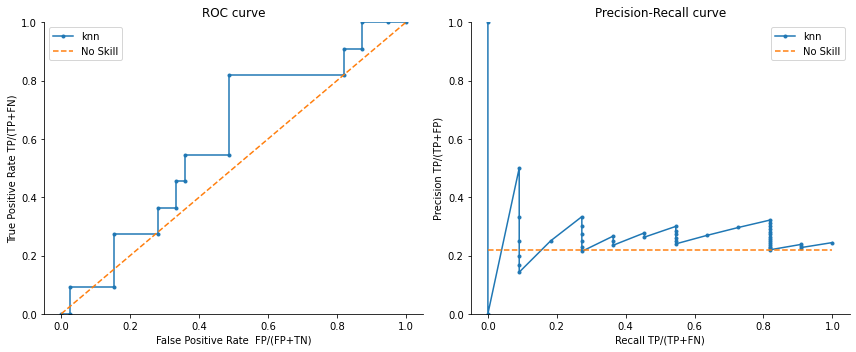

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.594406  0.257054     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


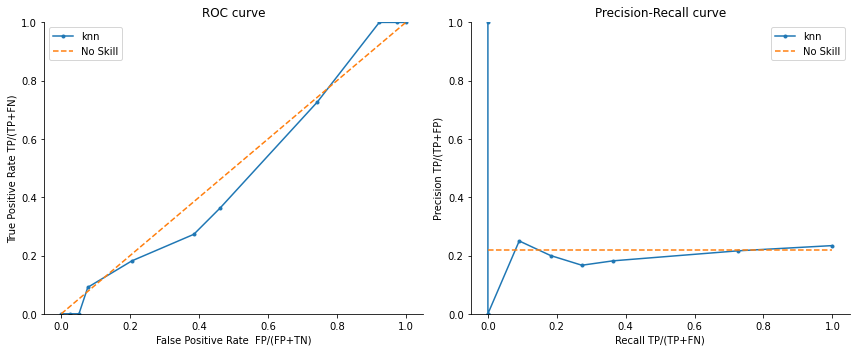

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.469697  0.198094     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


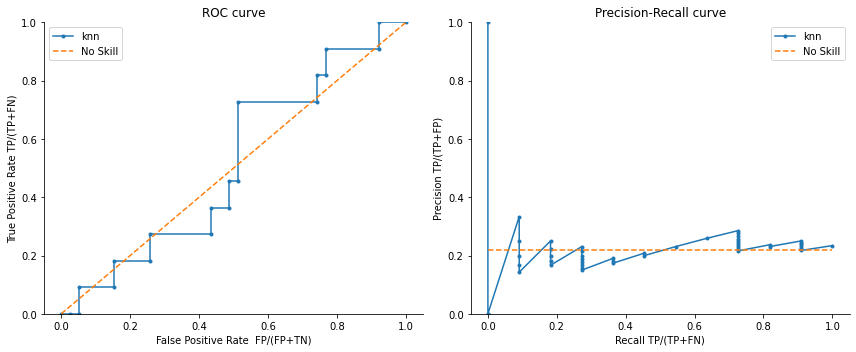

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.512821  0.213517     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


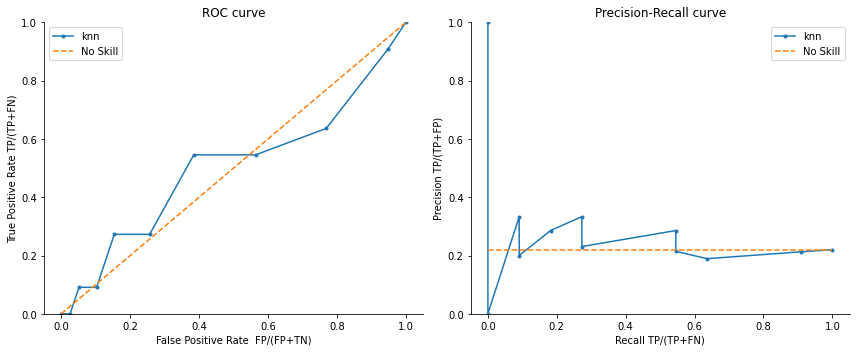

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.502331  0.228621     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


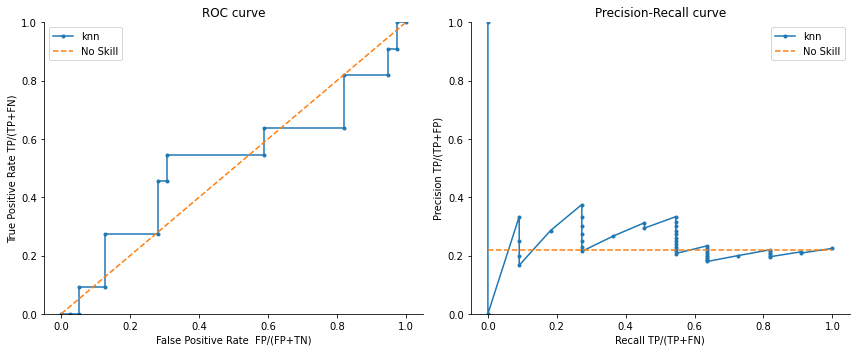

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.515152  0.237021     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


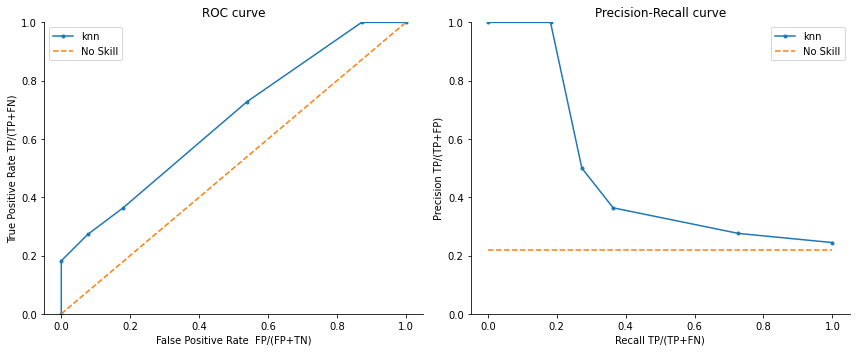

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.662005  0.47648     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


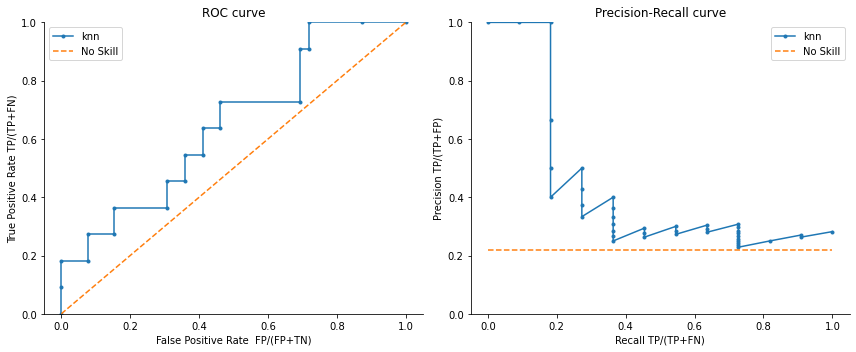

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.648019  0.429519  0.181818        1.0  0.307692   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


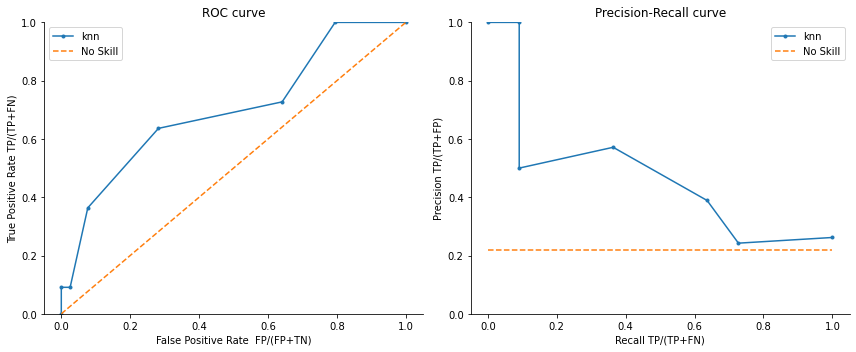

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.699301  0.465434  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


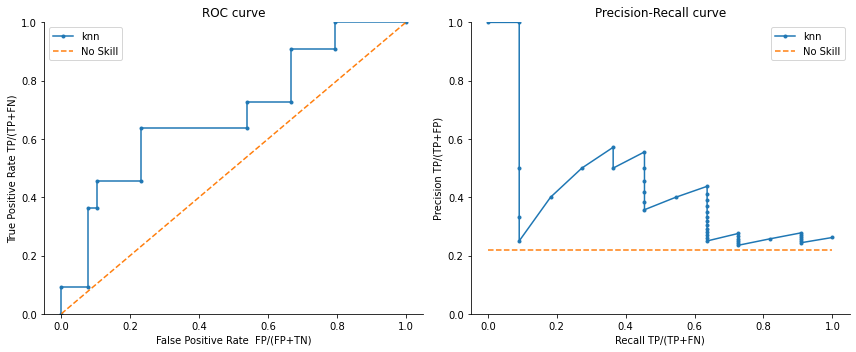

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.685315  0.424121  0.090909        0.5  0.153846   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


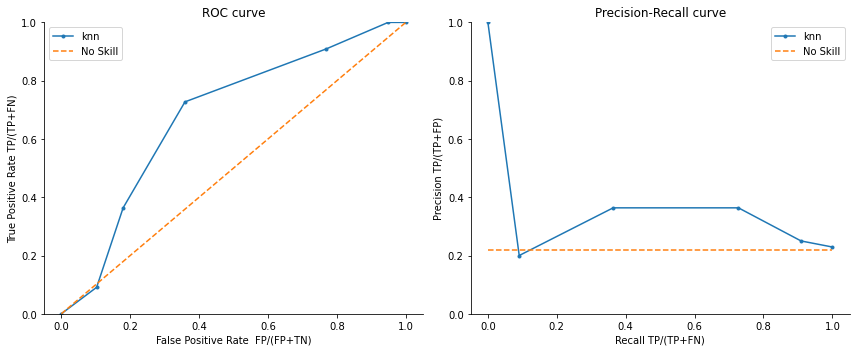

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.678322  0.341202     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


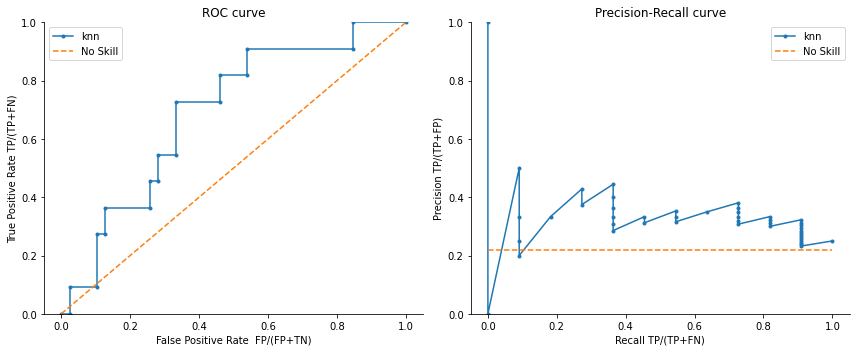

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.689977  0.320094     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


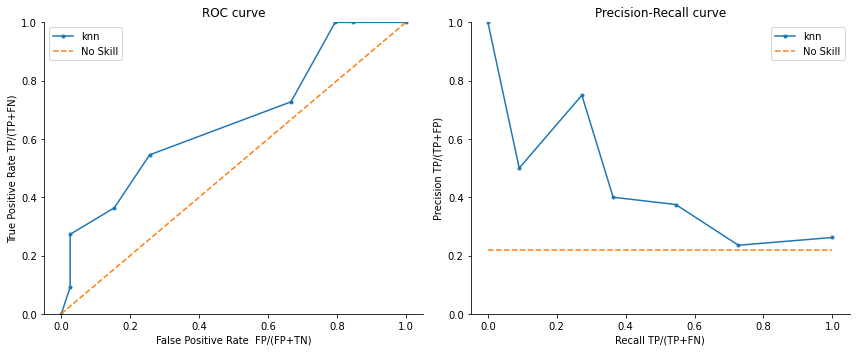

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.665501  0.427827     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


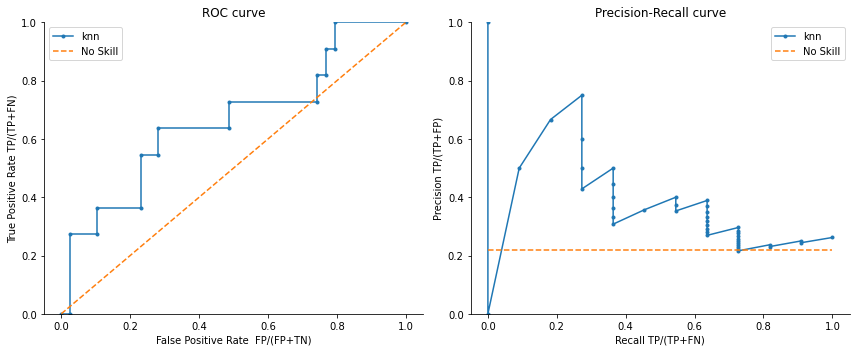

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.662005  0.371858     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


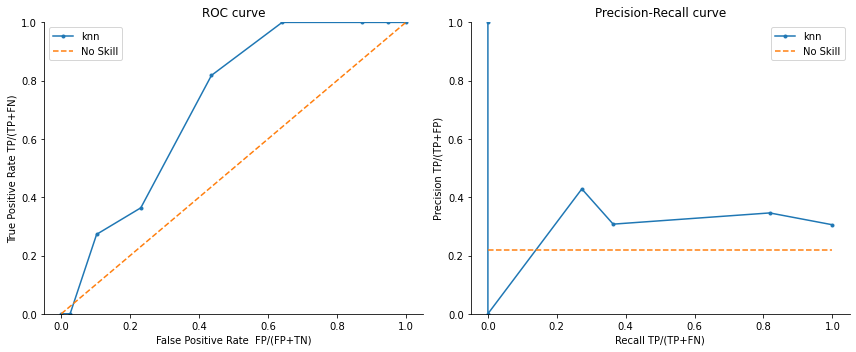

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.717949  0.299756     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


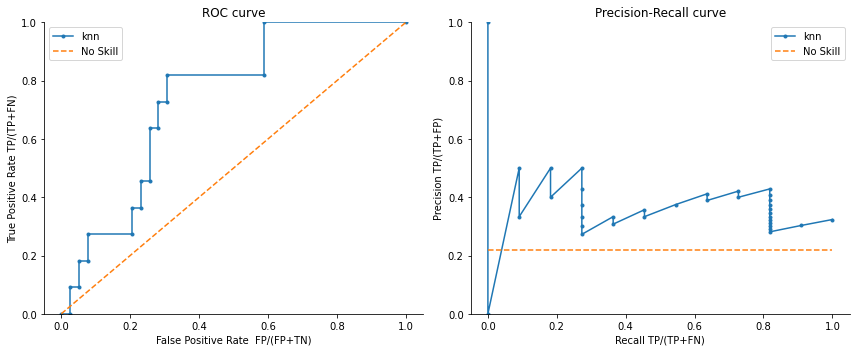

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.738928  0.356758     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


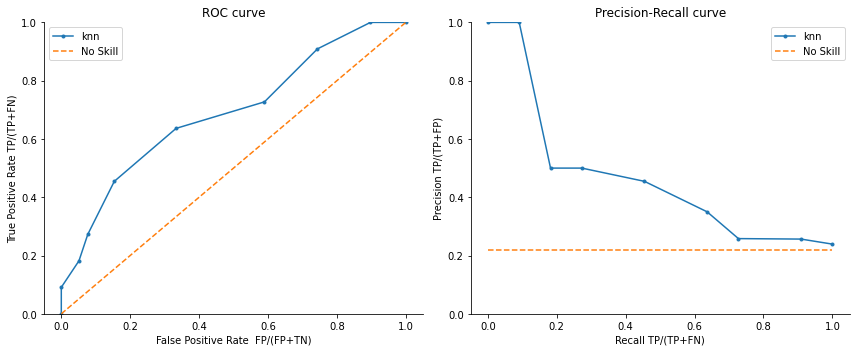

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.688811  0.461397     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


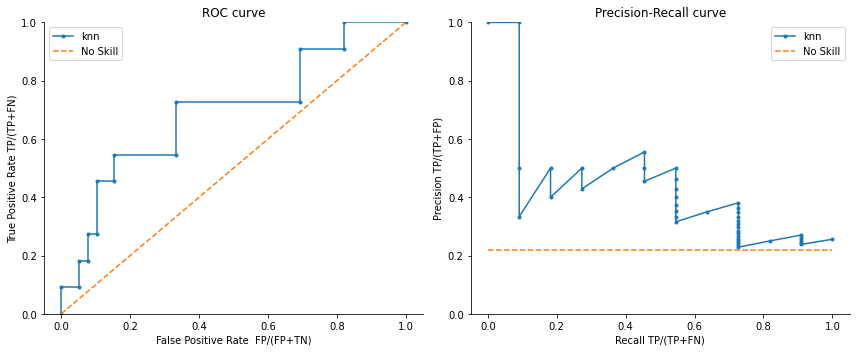

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.694639  0.434614     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000 - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


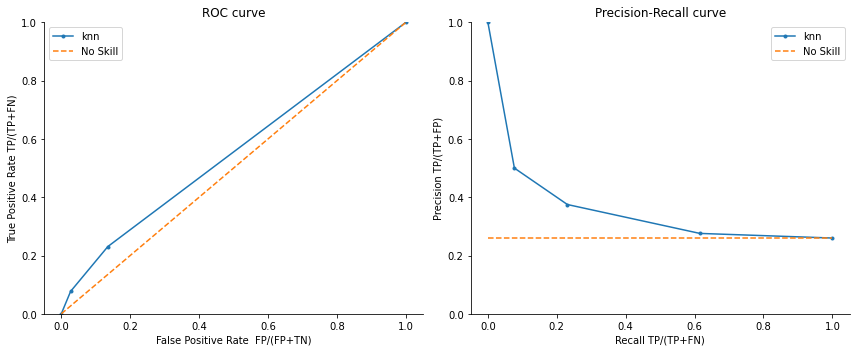

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.549896  0.353216     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


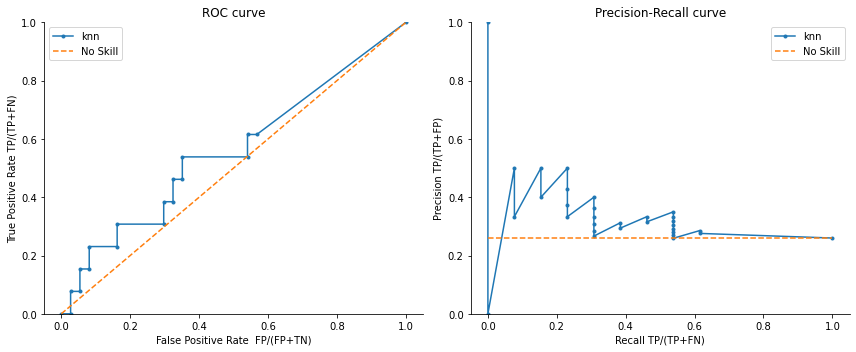

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.557173  0.310129     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


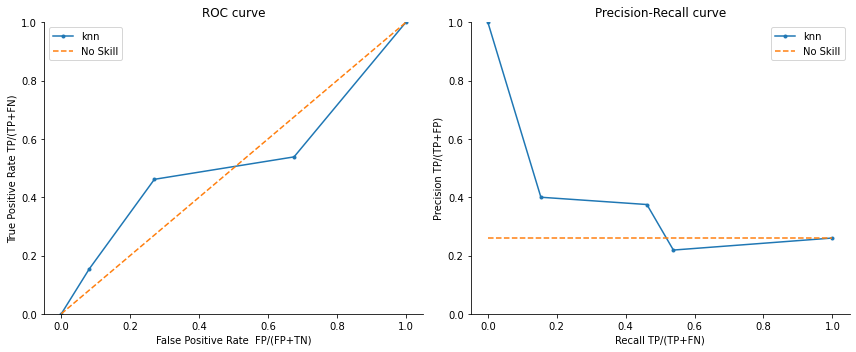

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.516632  0.36024     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


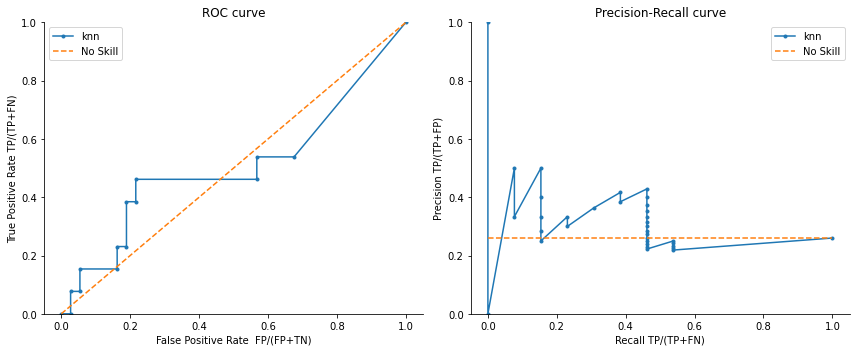

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.505198  0.289174     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


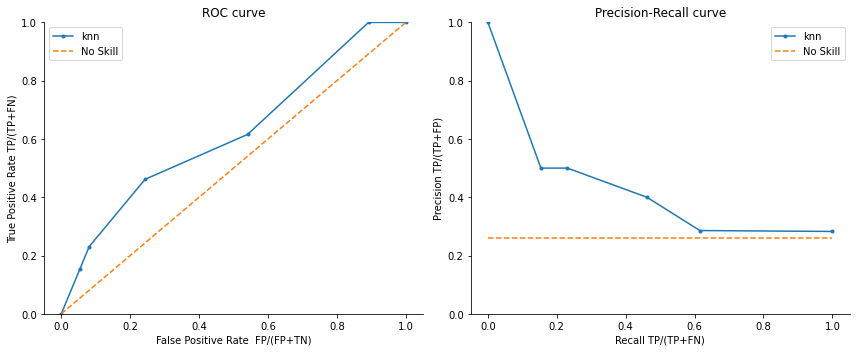

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.617464  0.419732     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


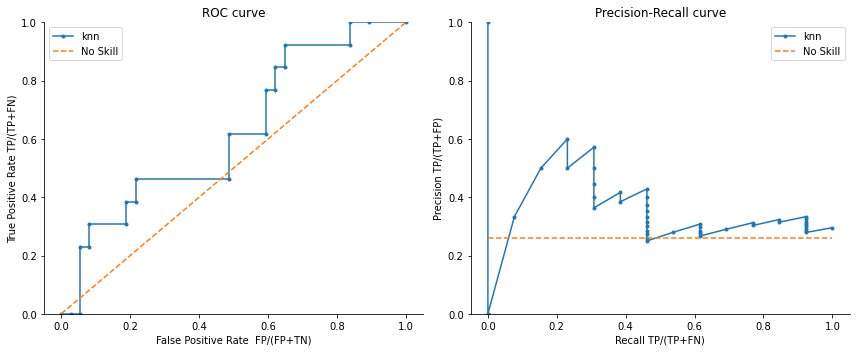

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.621622  0.348377     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


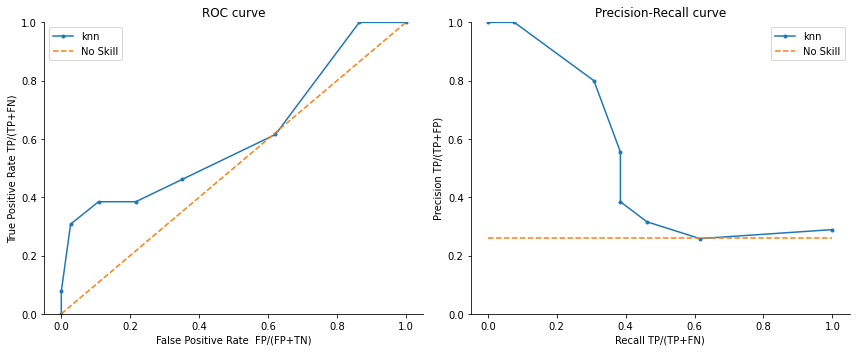

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.609148  0.513017     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


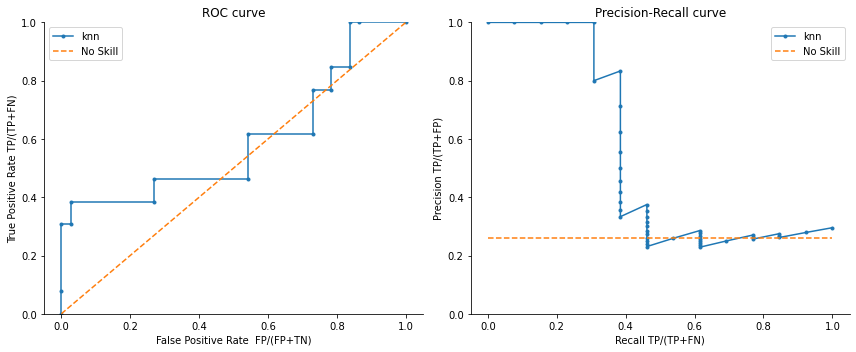

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.592516  0.539324     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


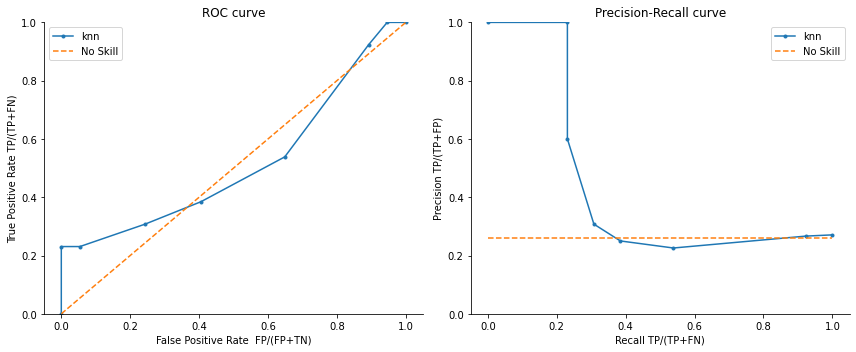

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.515593  0.43911     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


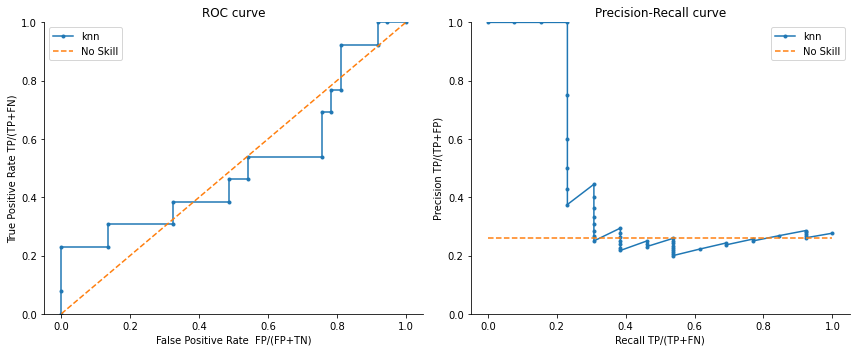

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.513514  0.435065     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


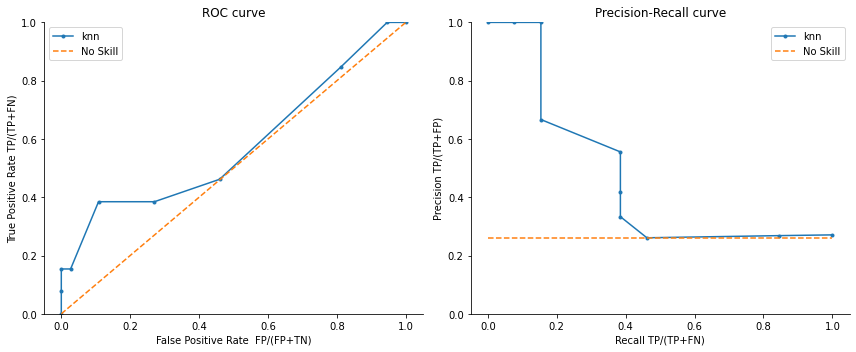

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.576923  0.460959     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


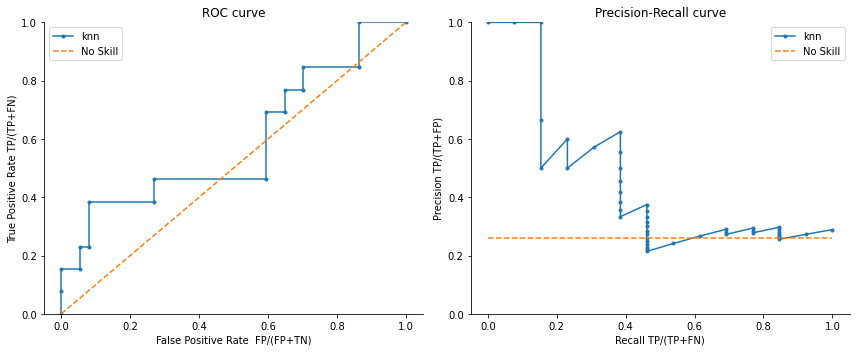

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.588358  0.45496     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


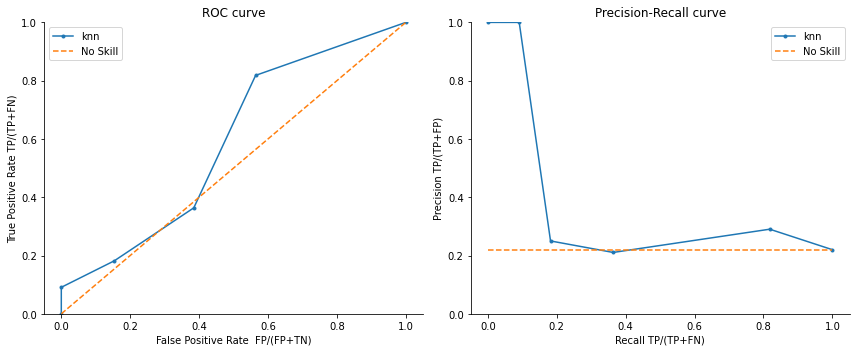

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.586247  0.349816     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


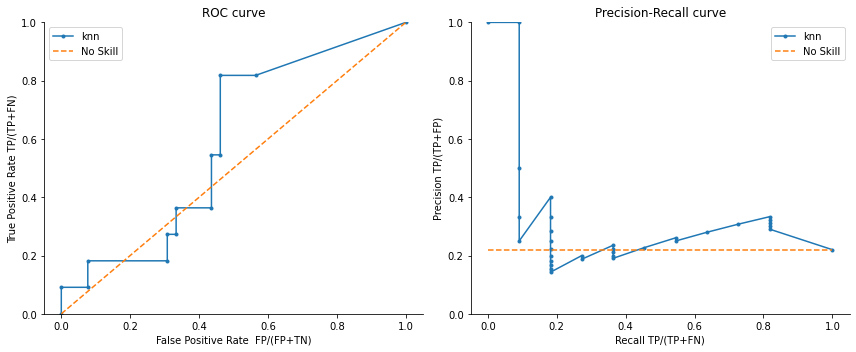

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587413  0.322768     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


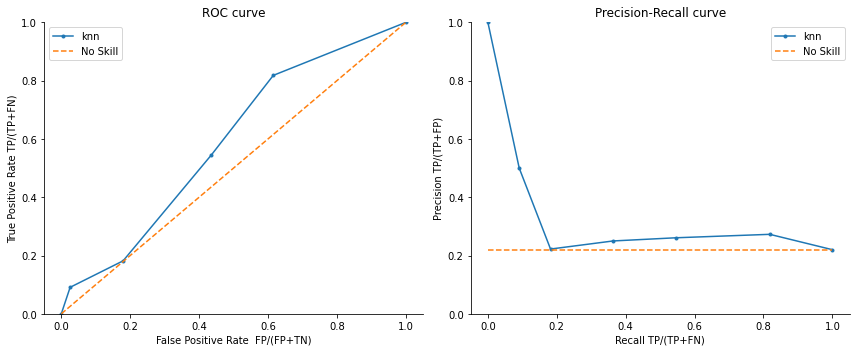

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587413  0.307939     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


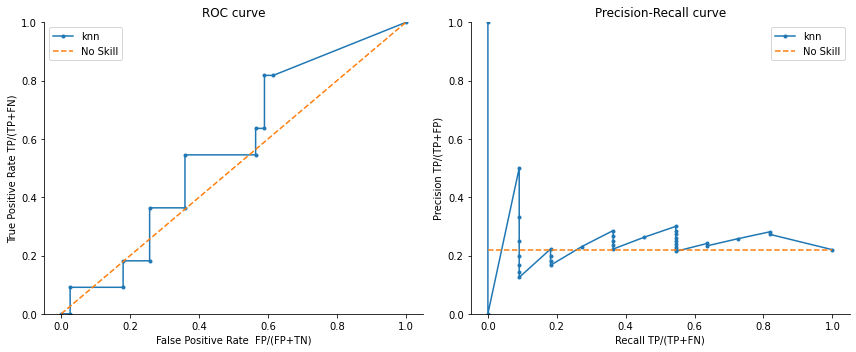

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.564103  0.240069  0.090909        0.5  0.153846   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


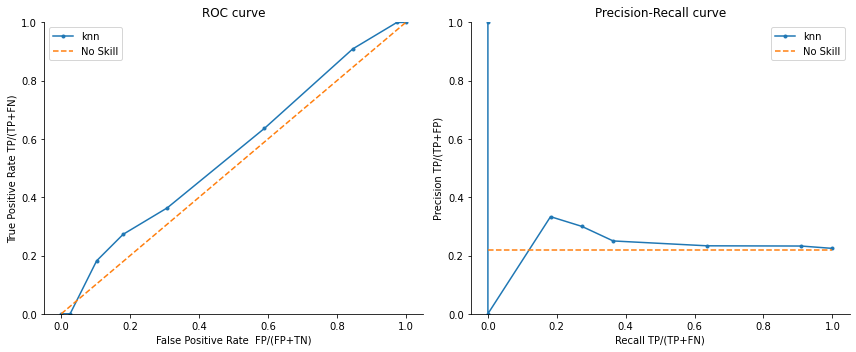

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.552448  0.234306     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


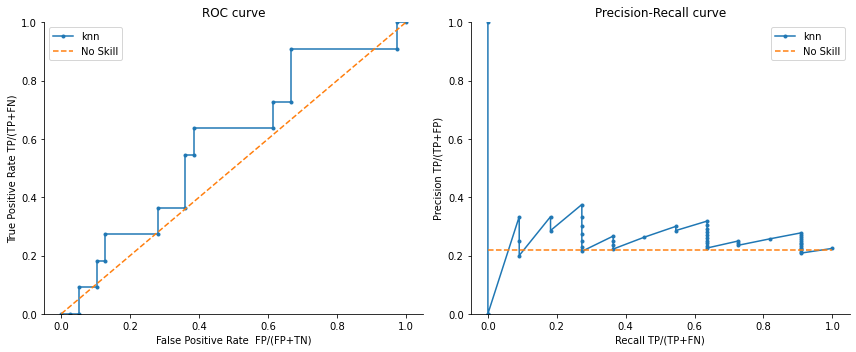

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.582751  0.254398     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


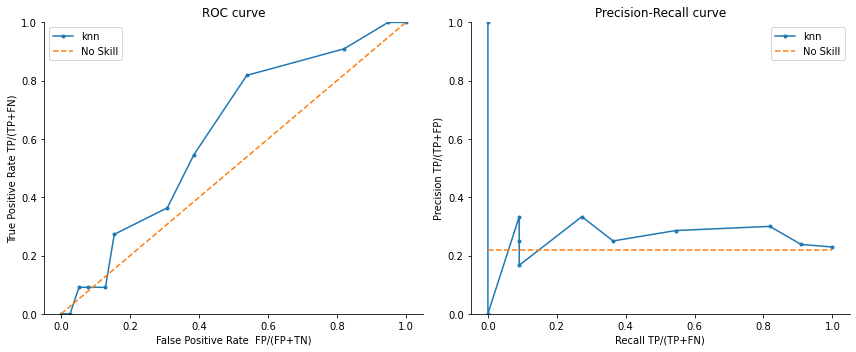

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.618881  0.261391     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


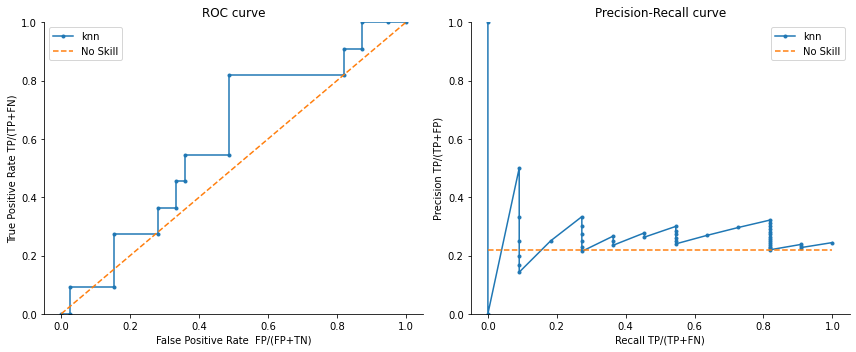

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.594406  0.257054     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


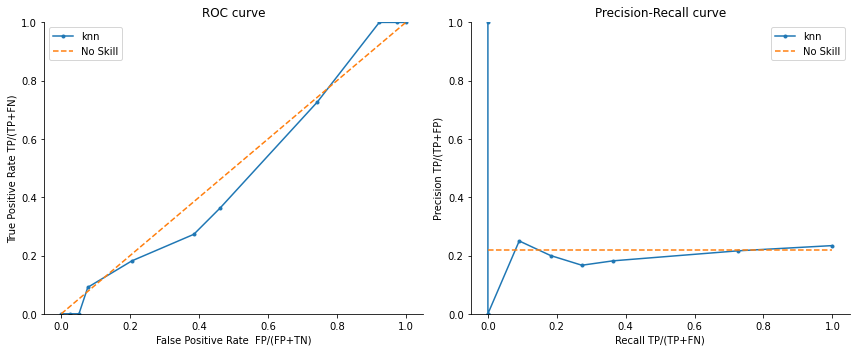

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.469697  0.198094     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


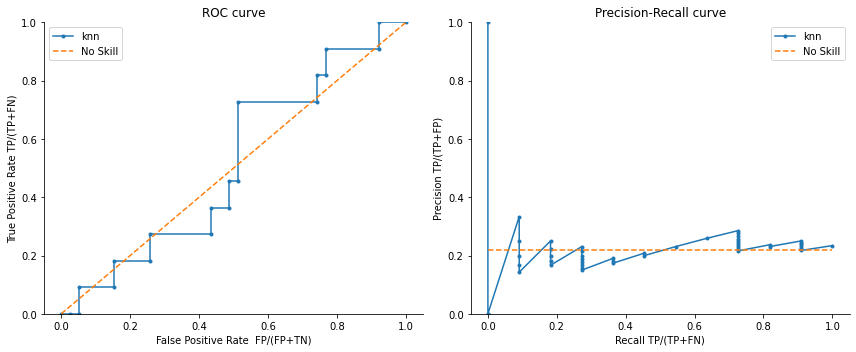

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.512821  0.213517     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


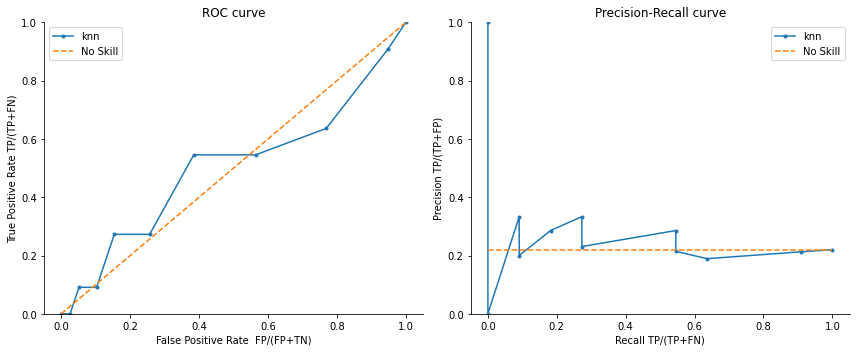

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.502331  0.228621     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


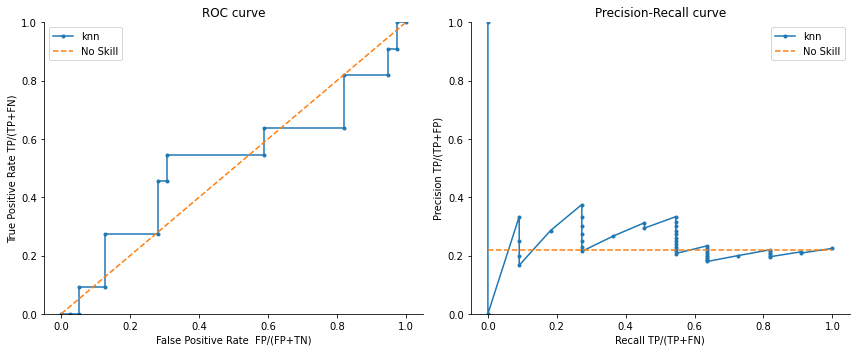

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.515152  0.237021     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


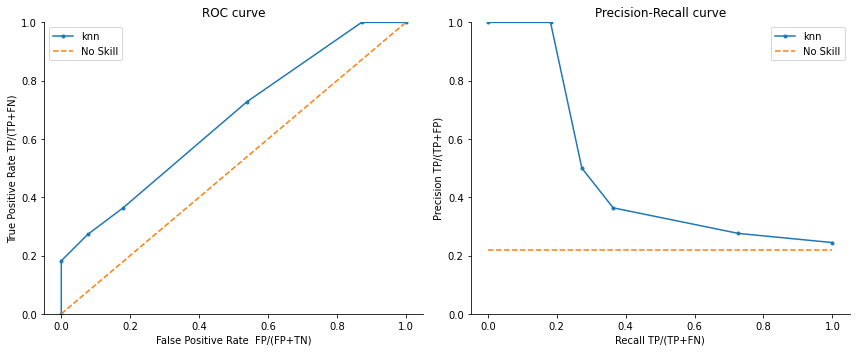

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.662005  0.47648     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


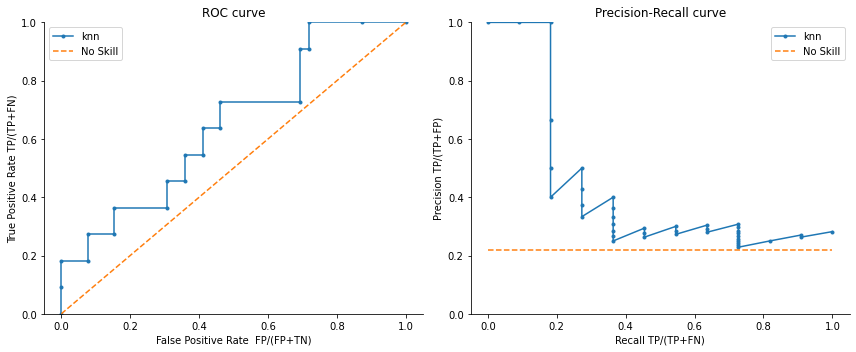

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.648019  0.429519  0.181818        1.0  0.307692   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


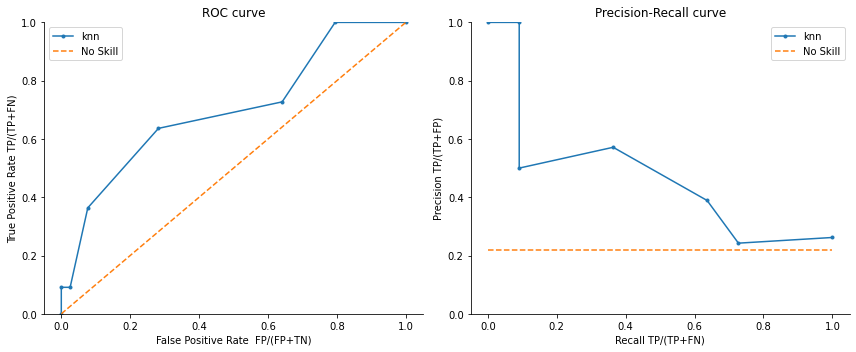

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.699301  0.465434  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


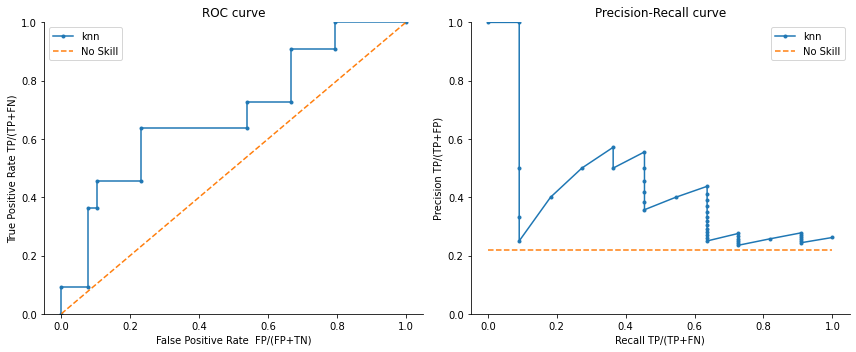

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.685315  0.424121  0.090909        0.5  0.153846   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


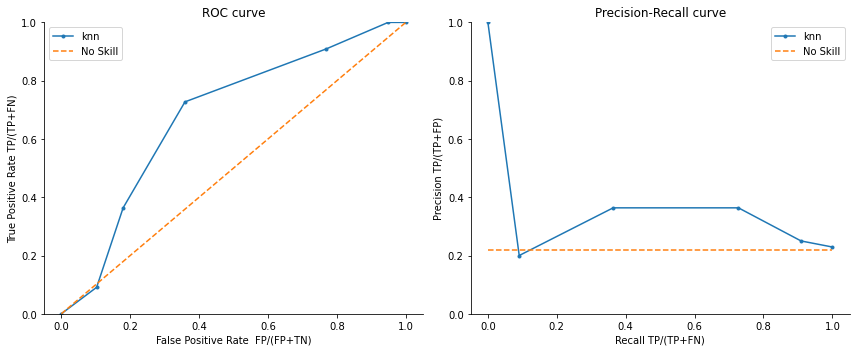

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.678322  0.341202     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


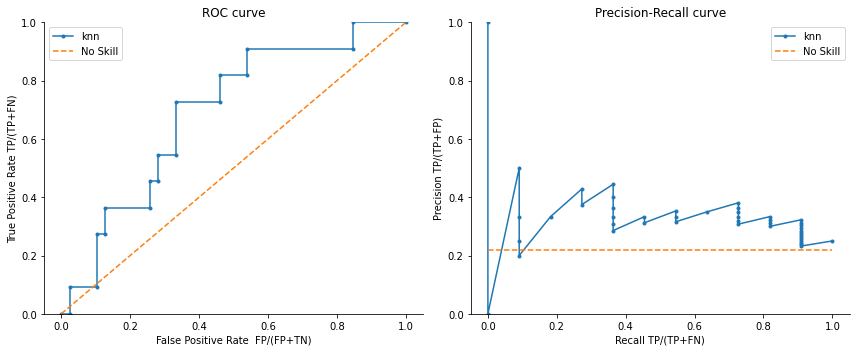

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.689977  0.320094     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


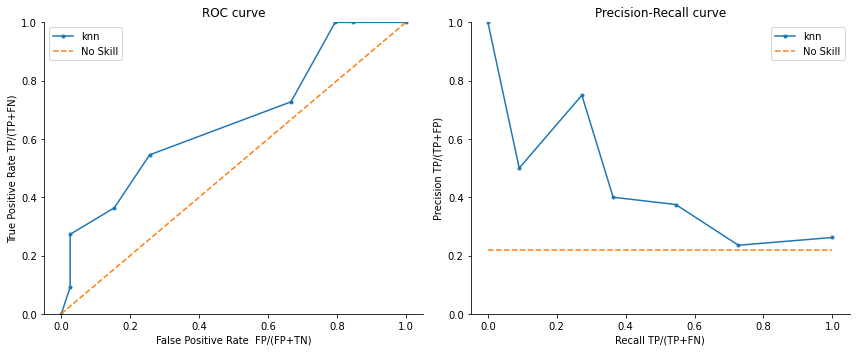

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.665501  0.427827     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


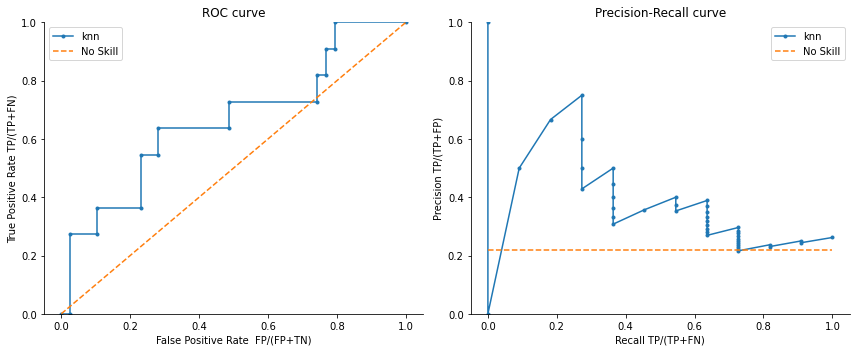

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.662005  0.371858     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


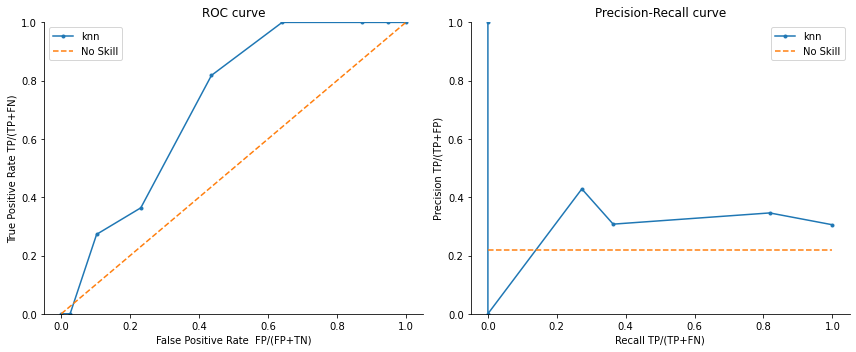

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.717949  0.299756     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


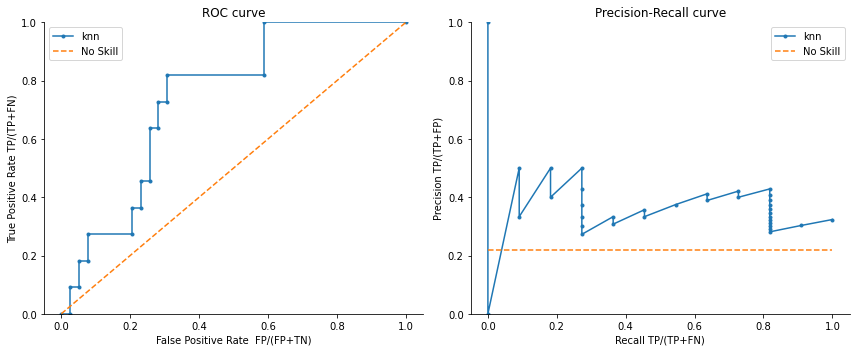

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.738928  0.356758     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


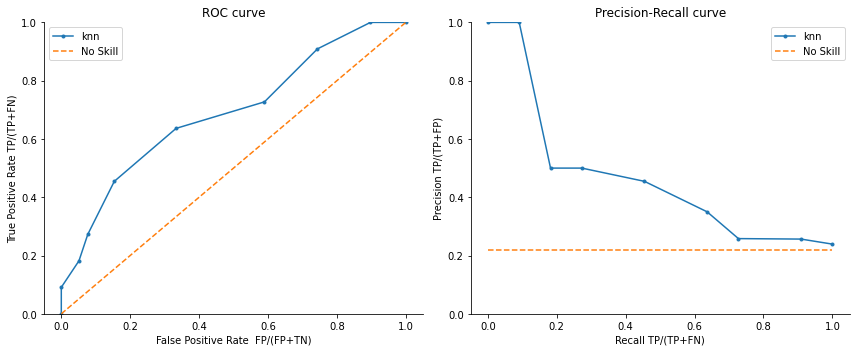

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.688811  0.461397     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


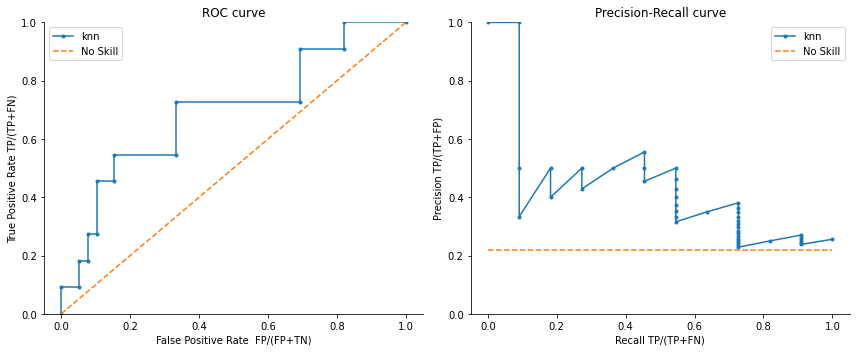

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.694639  0.434614     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


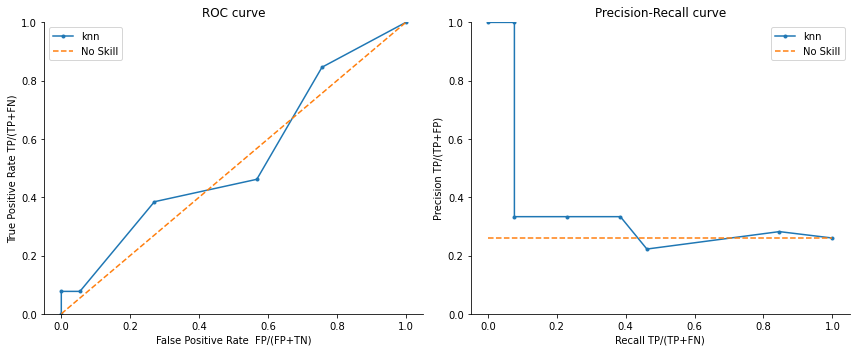

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.528067  0.339527  0.076923        1.0  0.142857   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


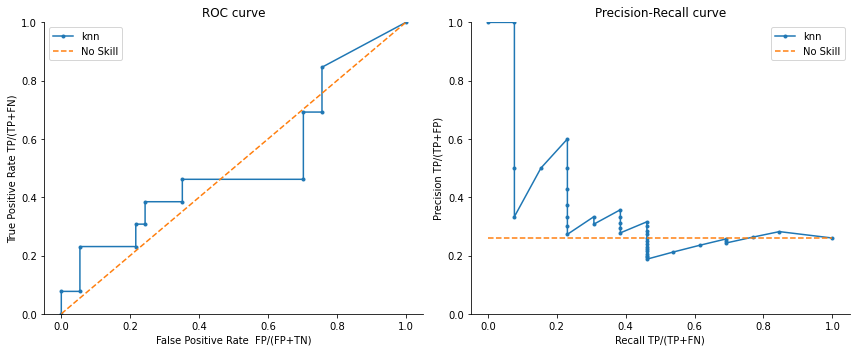

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.515593  0.356653  0.076923        0.5  0.133333   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


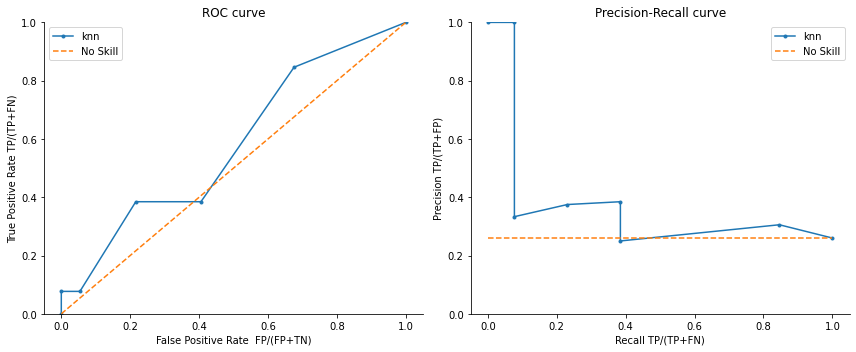

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.580042  0.361552  0.076923        1.0  0.142857   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


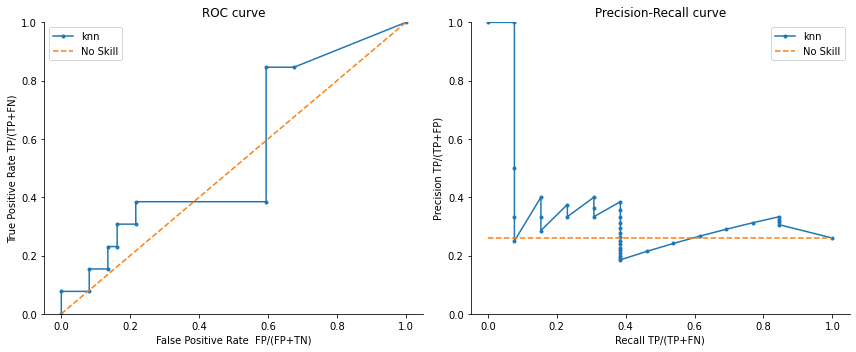

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.550936  0.348536  0.076923        0.5  0.133333   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


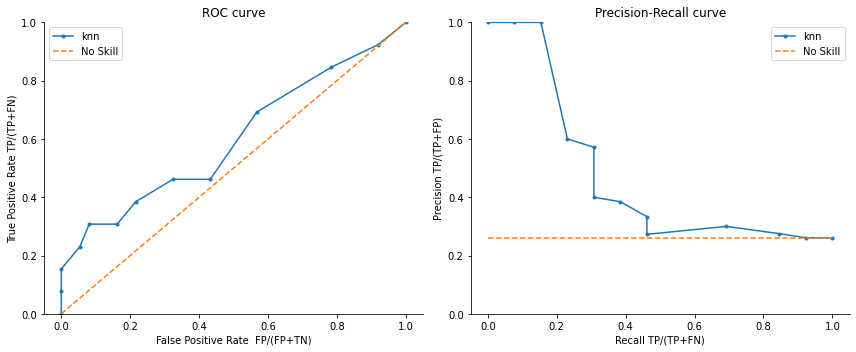

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.598753  0.469189  0.153846        1.0  0.266667   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


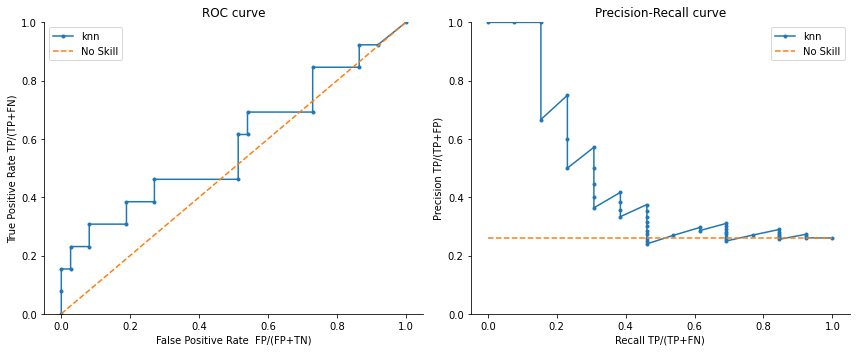

model  ROC AUC   PRC AUC    Recall  Presision    F1 counts for test data
0   knn  0.58316  0.452961  0.153846   0.666667  0.25       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


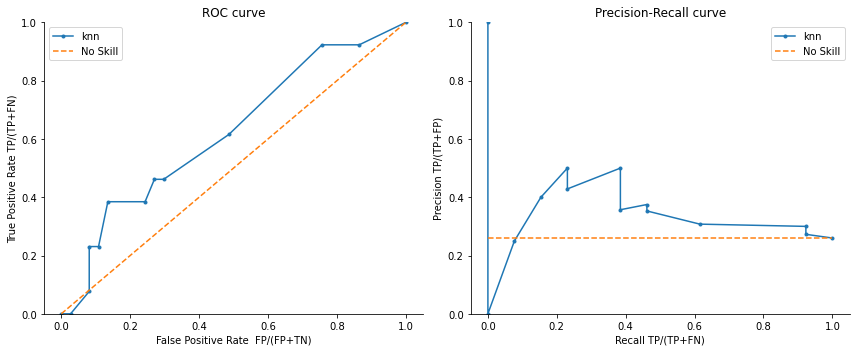

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.621622  0.333617  0.076923       0.25  0.117647   

  counts for test data  
0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


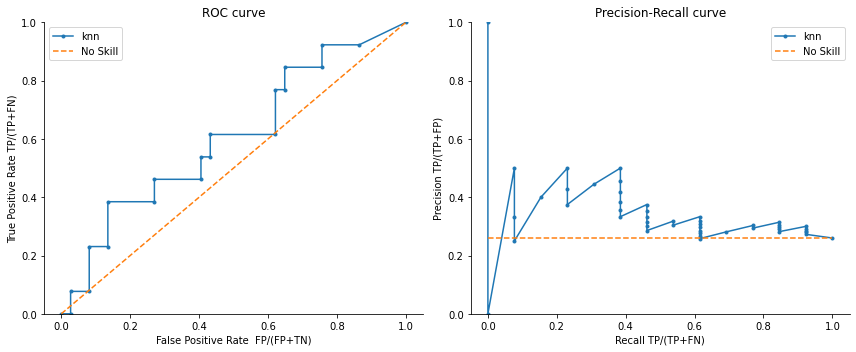

model  ROC AUC   PRC AUC    Recall  Presision        F1 counts for test data
0   knn  0.60395  0.331176  0.076923       0.25  0.117647       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


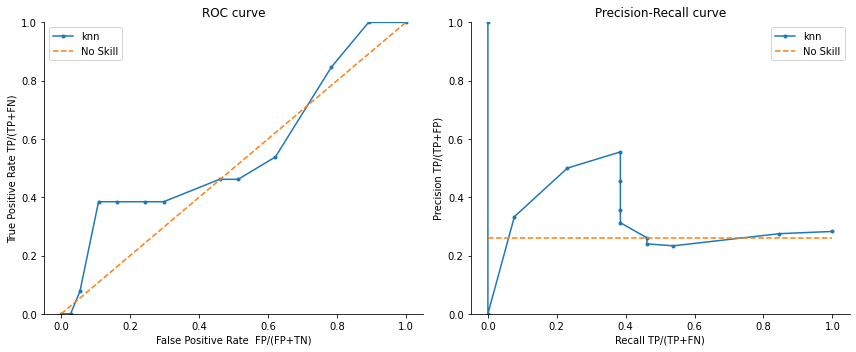

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.554054  0.319476     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


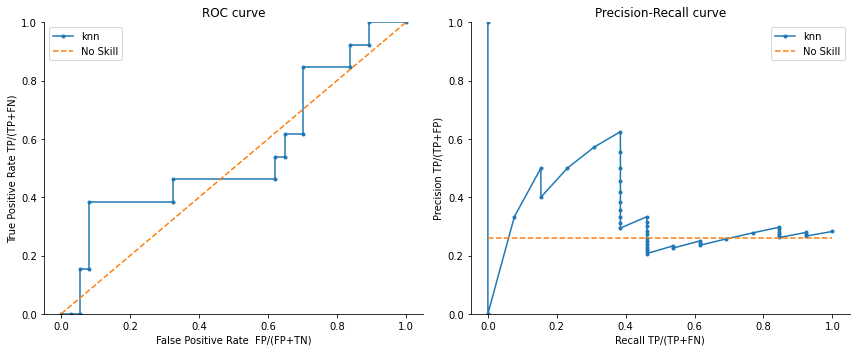

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.555094  0.329642     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


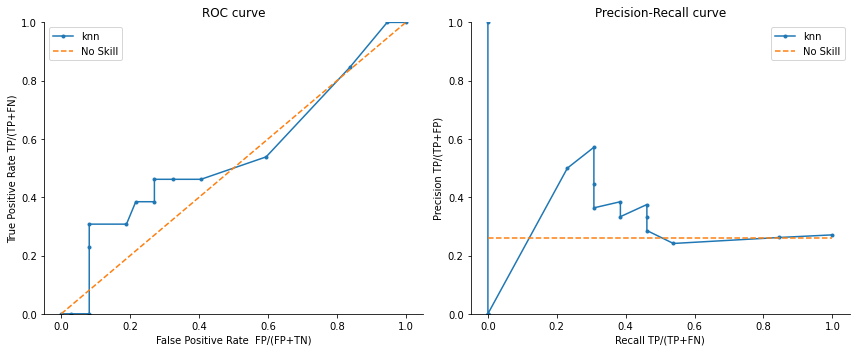

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.54262  0.293605     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


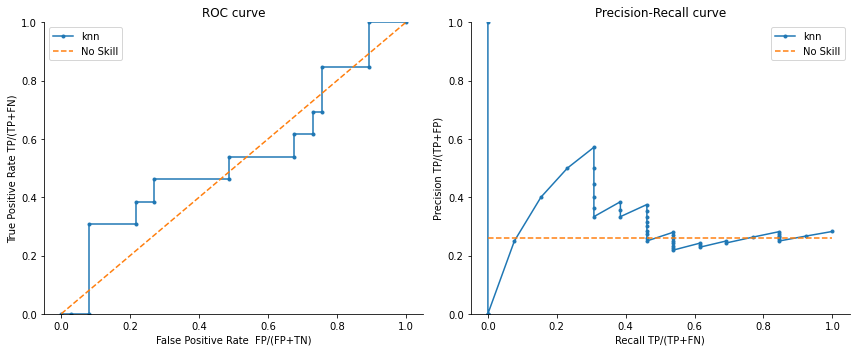

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.538462  0.30327     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G100_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


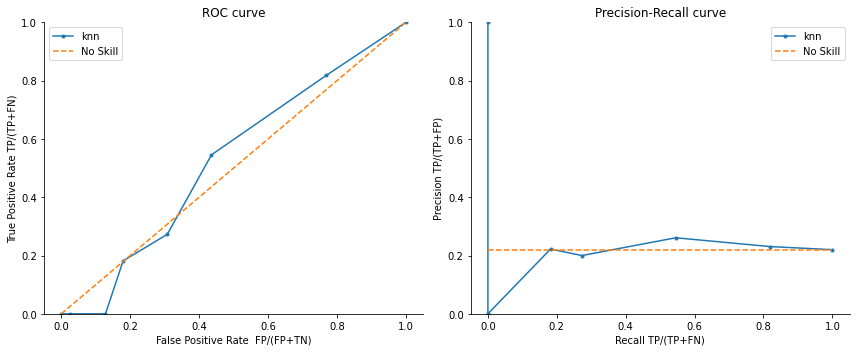

model  ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.52331  0.21026     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


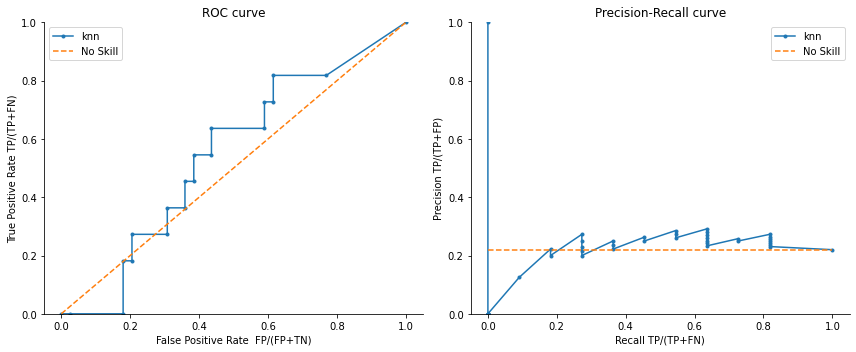

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.543124  0.222011     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


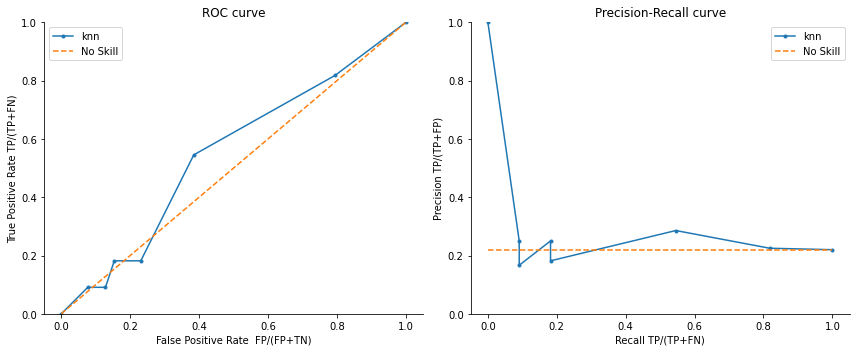

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.547786  0.270861  0.090909       0.25  0.133333   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


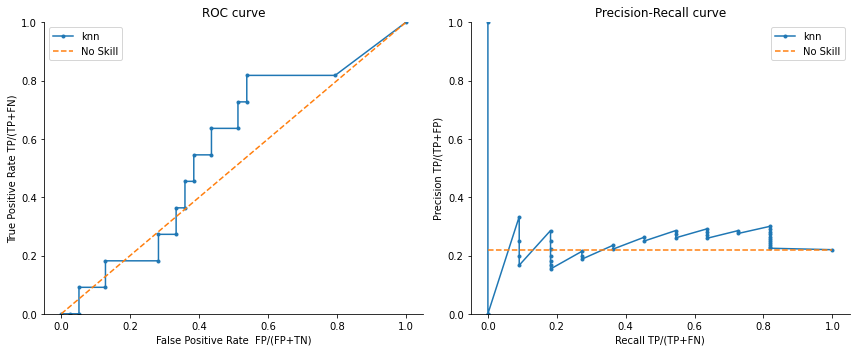

model   ROC AUC   PRC AUC    Recall  Presision     F1 counts for test data
0   knn  0.561772  0.234596  0.090909        0.2  0.125       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


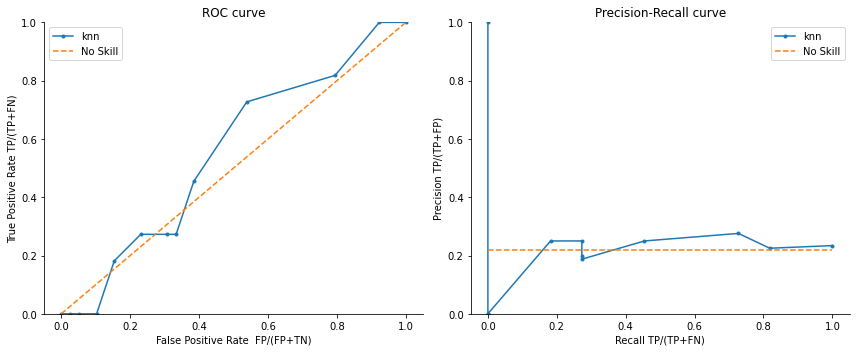

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.551282  0.221433     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


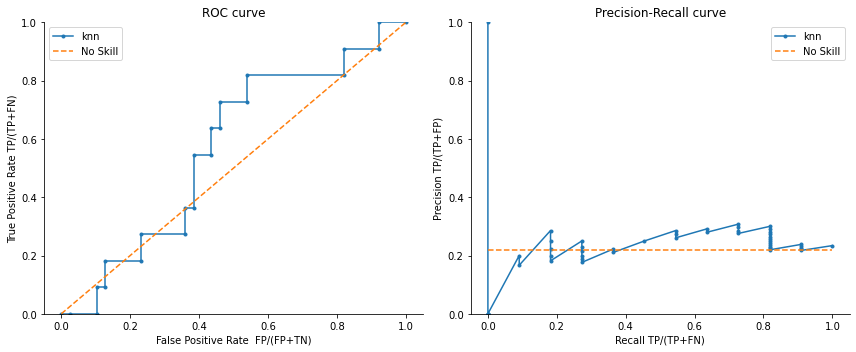

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.566434  0.232012     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


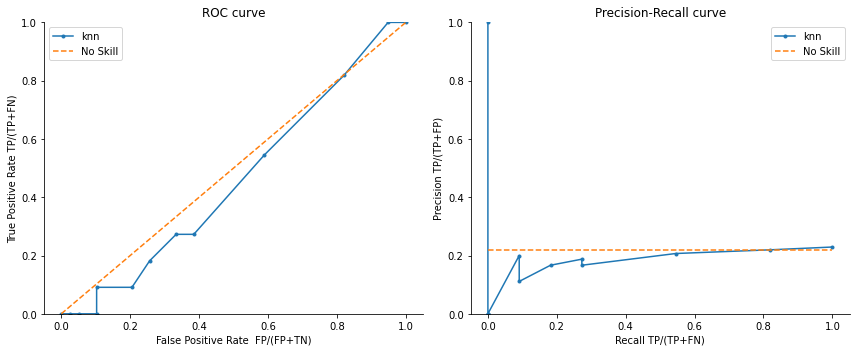

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.456876  0.187692     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


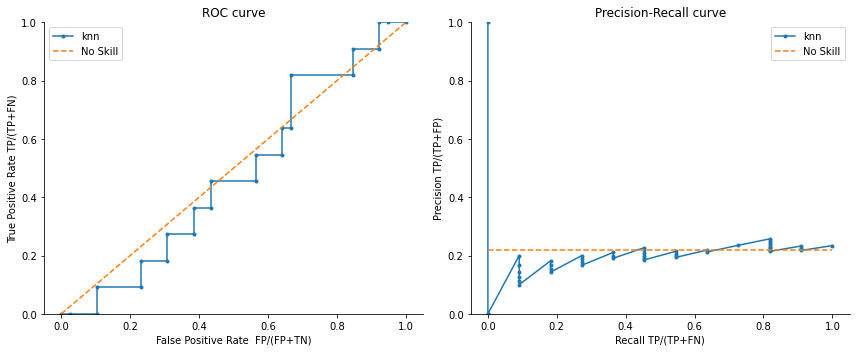

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.475524  0.194069     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


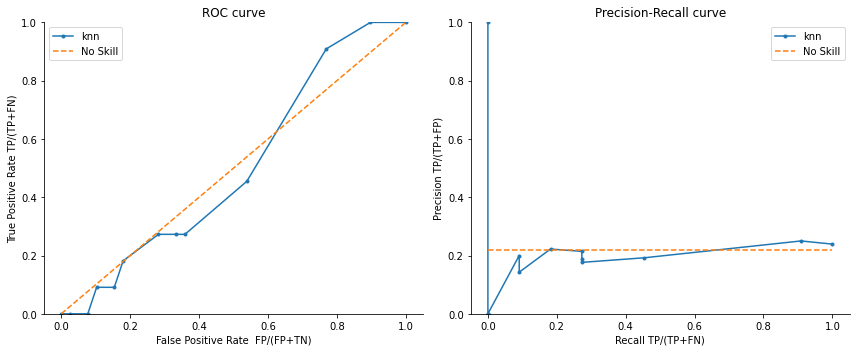

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.501166  0.20181     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


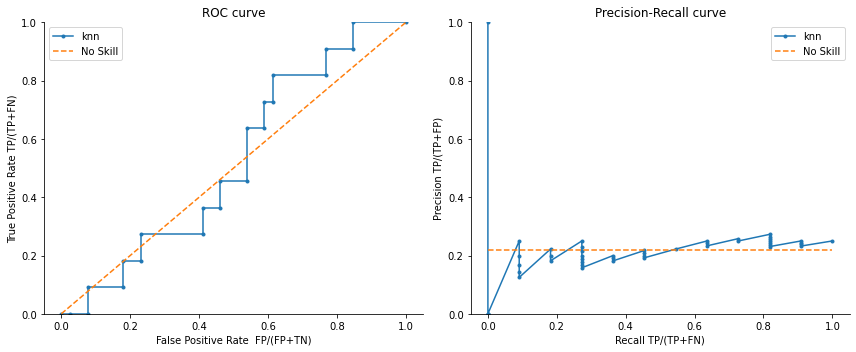

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.522145  0.21138     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


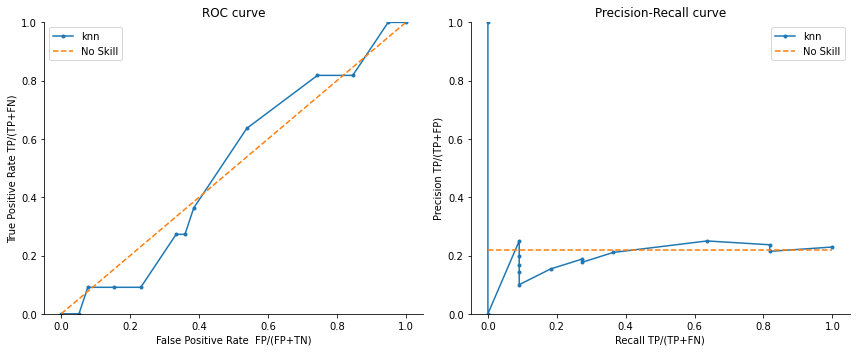

model   ROC AUC  PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.503497  0.20338     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


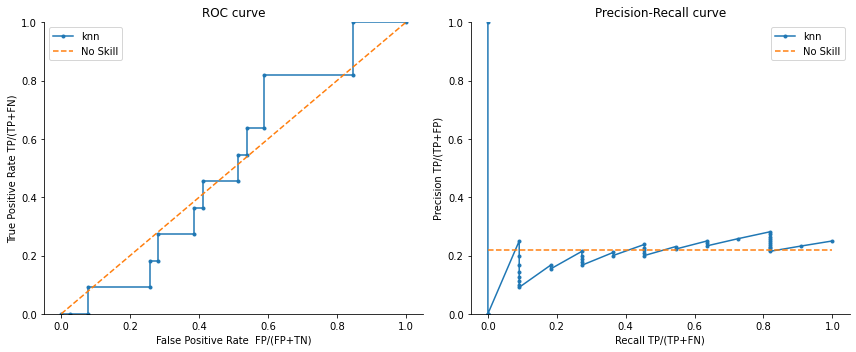

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.515152  0.207005     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


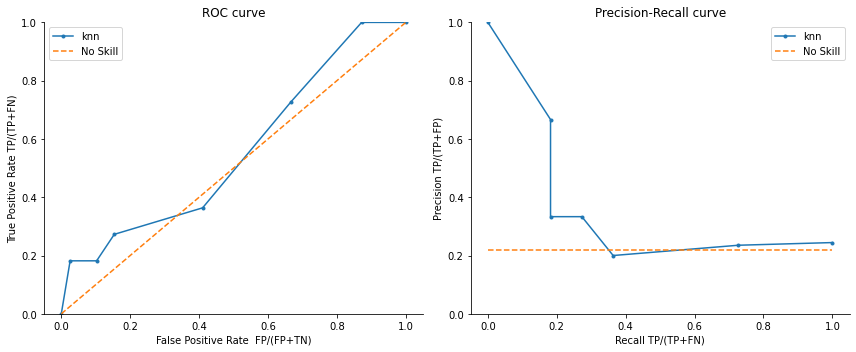

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.554779  0.350624  0.181818   0.666667  0.285714   

  counts for test data  
0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


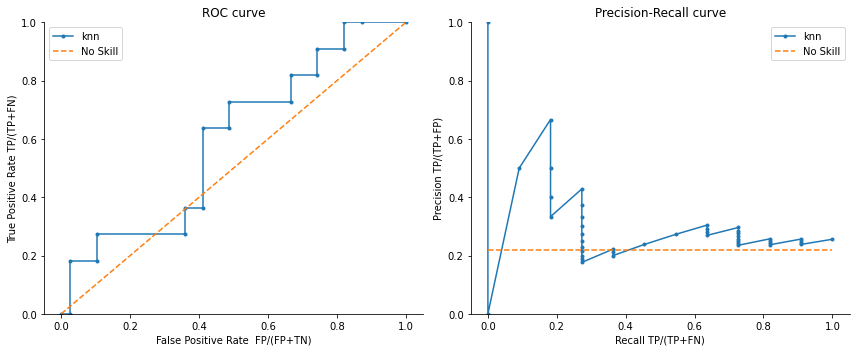

model   ROC AUC   PRC AUC    Recall  Presision    F1 counts for test data
0   knn  0.594406  0.290836  0.181818        0.4  0.25       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


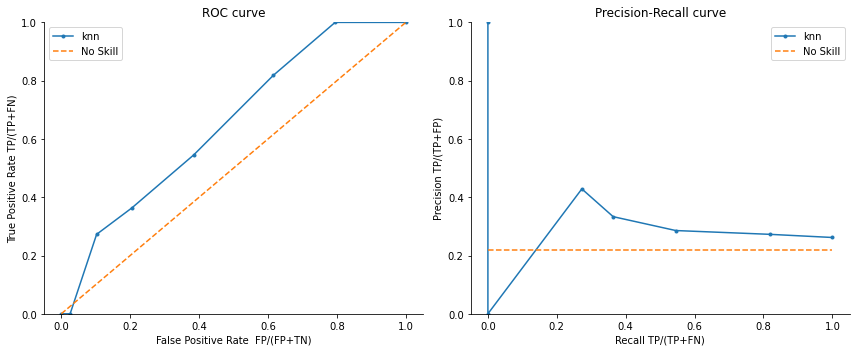

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.65035  0.274105     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


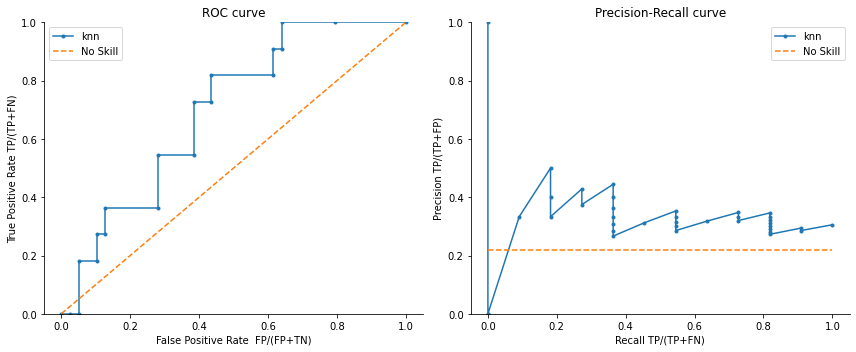

model   ROC AUC   PRC AUC    Recall  Presision    F1 counts for test data
0   knn  0.694639  0.322127  0.181818        0.4  0.25       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


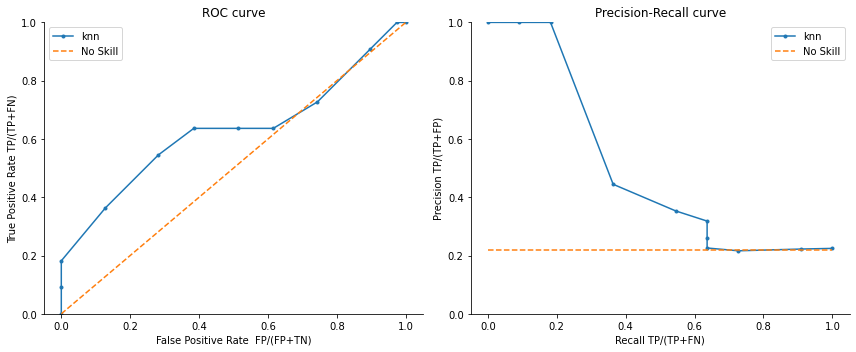

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.624709  0.496382     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


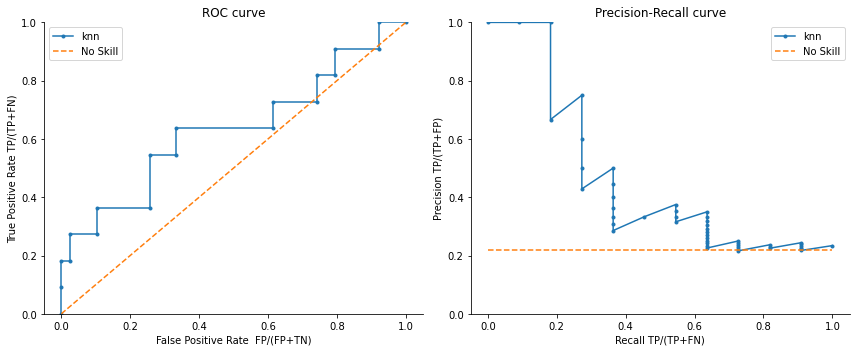

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.631702  0.463073     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


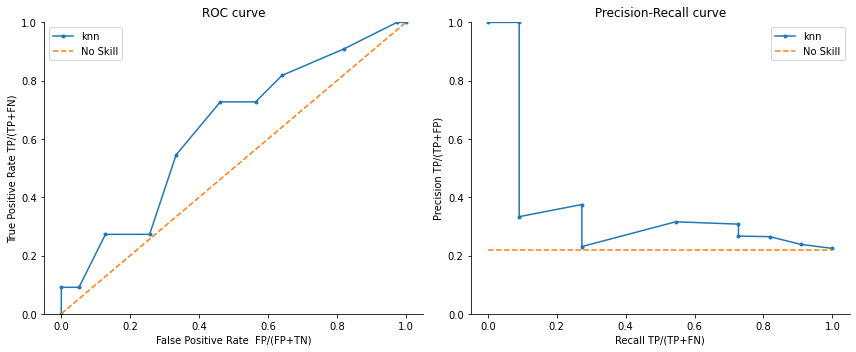

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.628205  0.354548     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


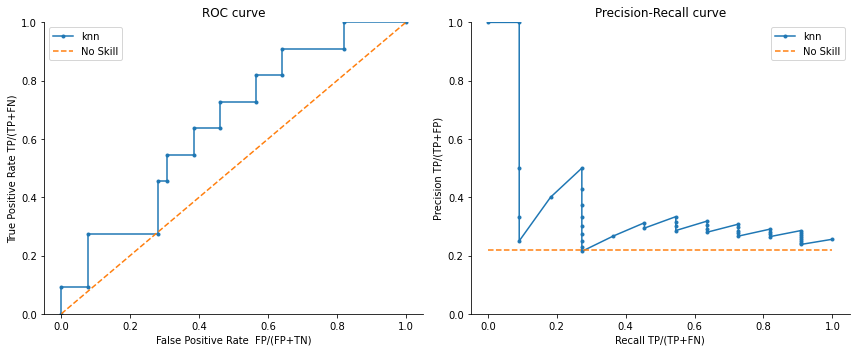

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.645688  0.365022     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


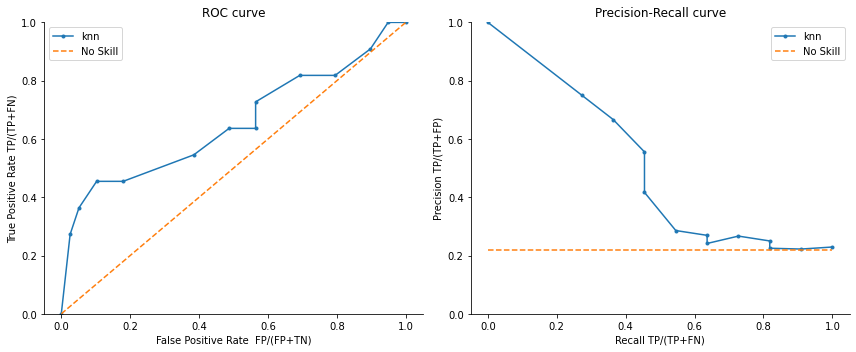

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.651515  0.503161     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


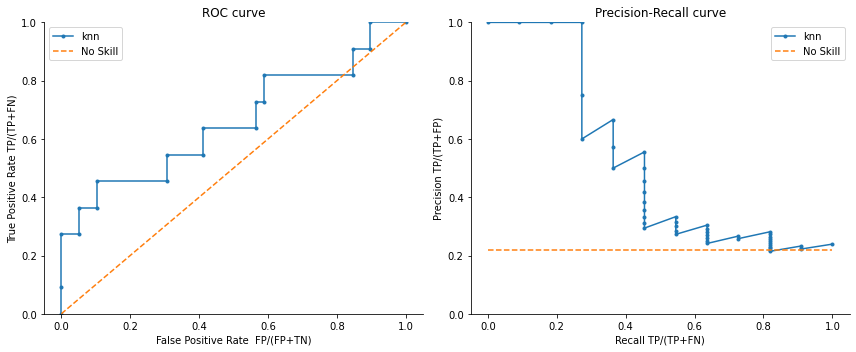

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.657343  0.521923     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


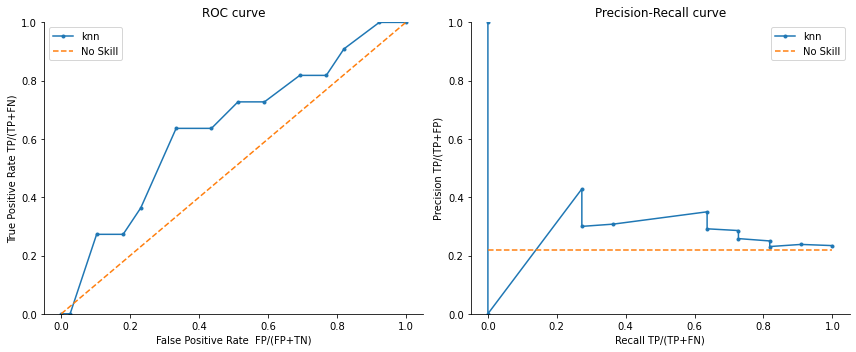

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.634033  0.267861     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


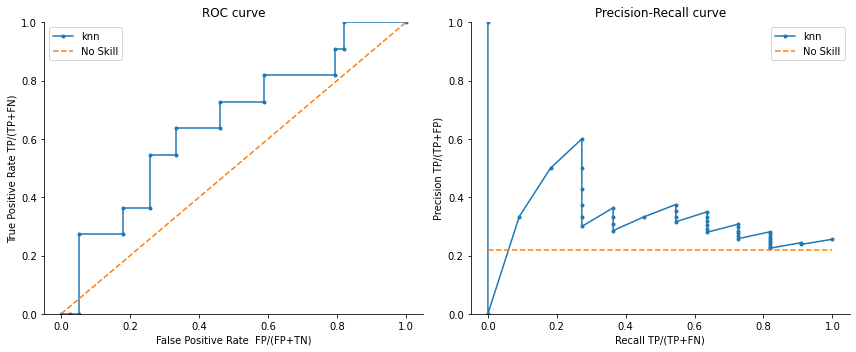

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.65035  0.318786     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G100_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


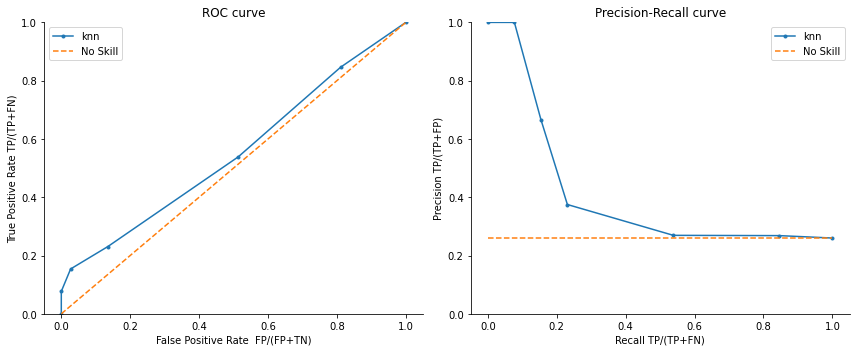

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.549896  0.403536     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


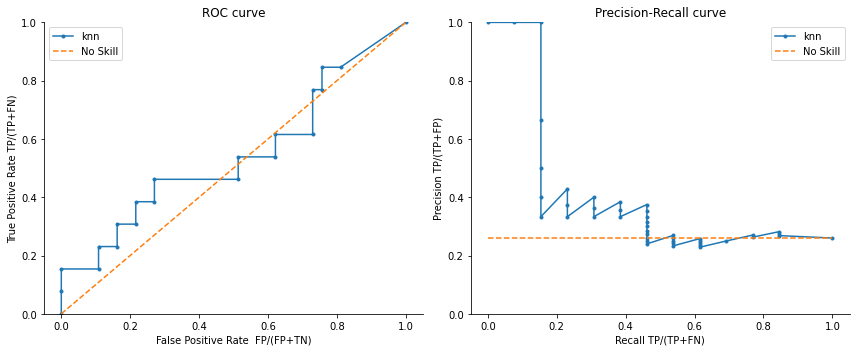

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.544699  0.404723  0.076923        1.0  0.142857   

  counts for test data  
0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


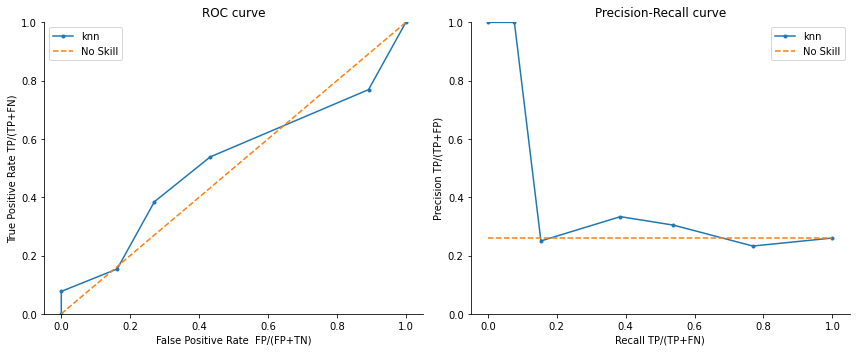

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.518711  0.360144     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


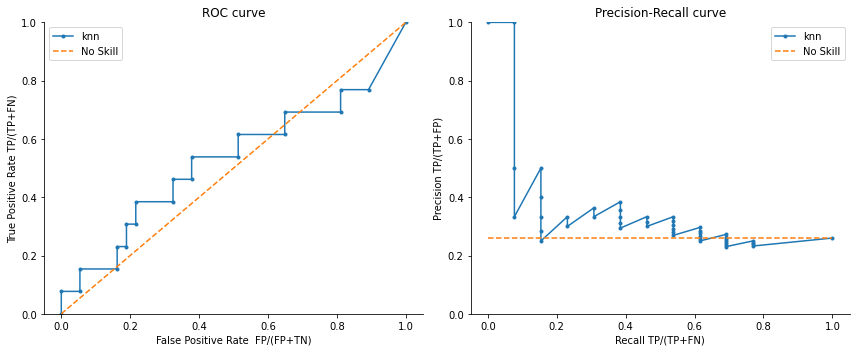

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.528067  0.350221     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


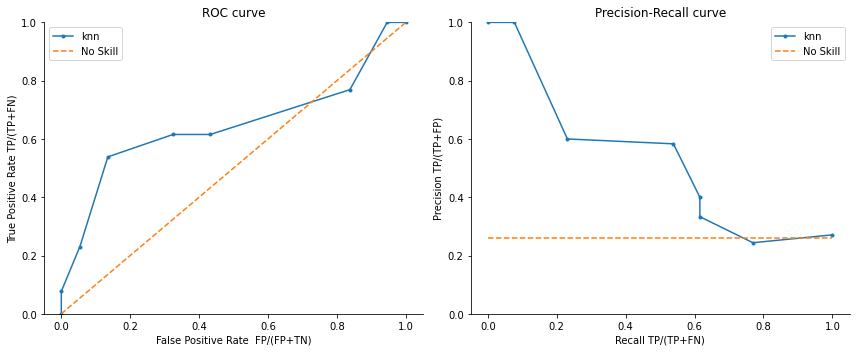

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.64553  0.523667     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


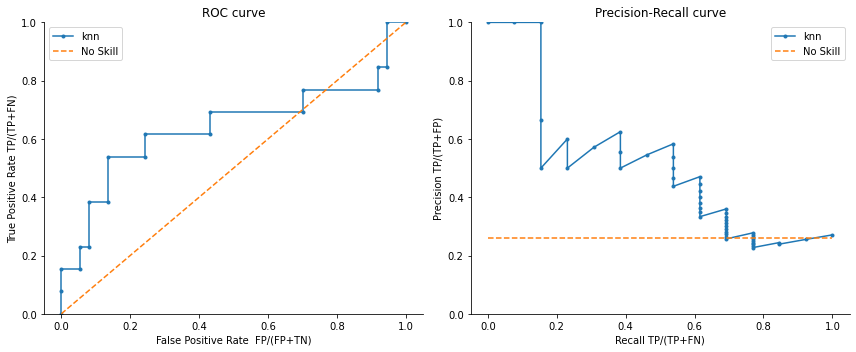

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.640333  0.506568     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


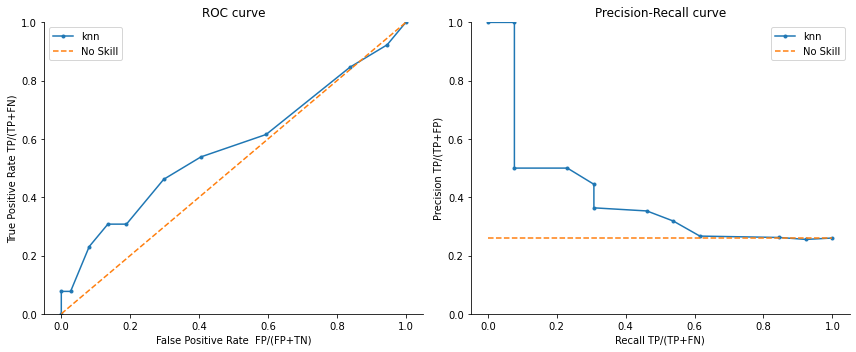

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.571726  0.394301     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


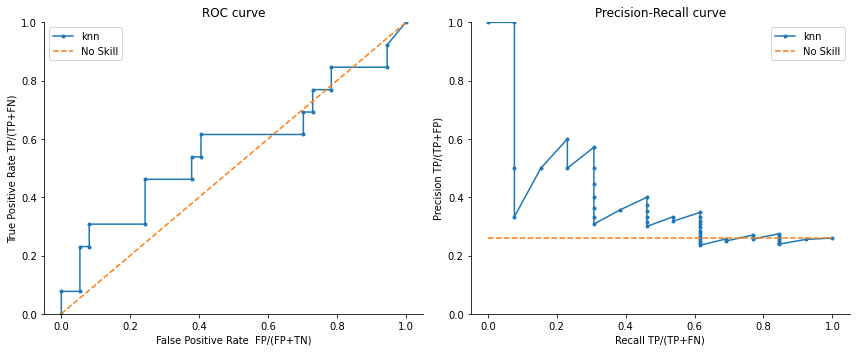

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.569647  0.395383     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


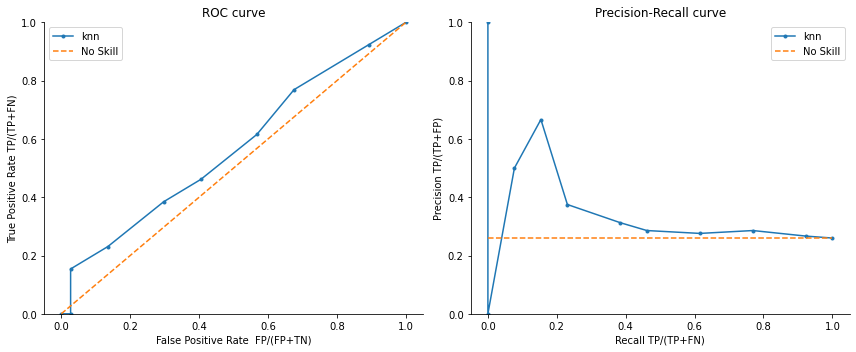

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.565489  0.329203     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


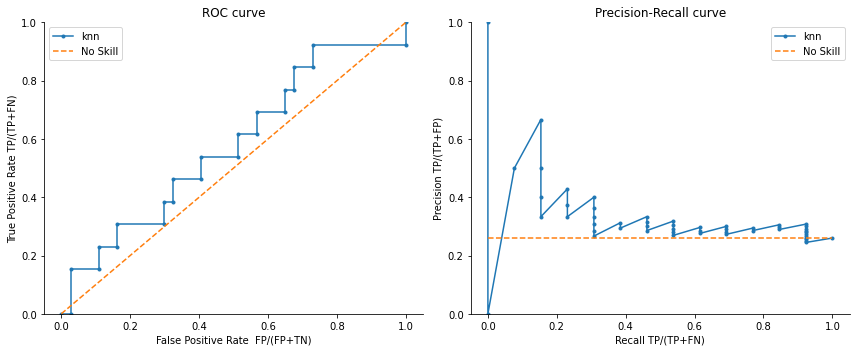

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.577963  0.322076     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


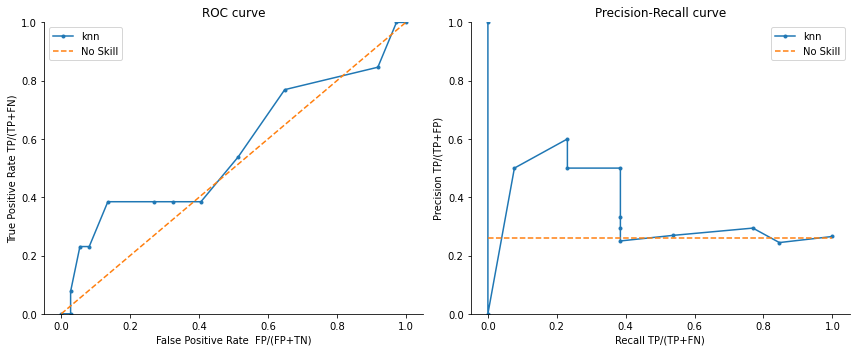

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.564449  0.345637     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


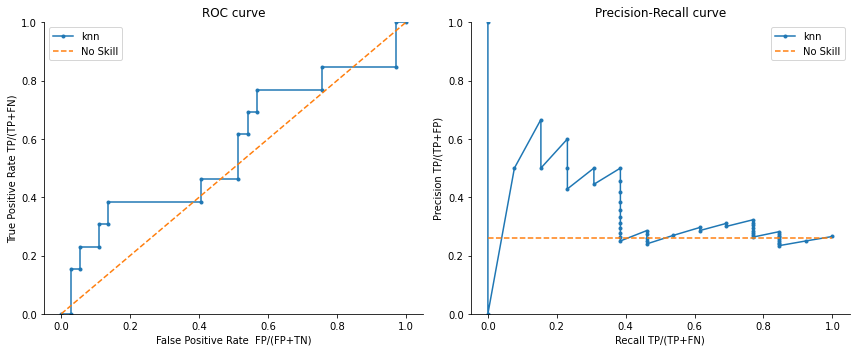

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.569647  0.346667     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


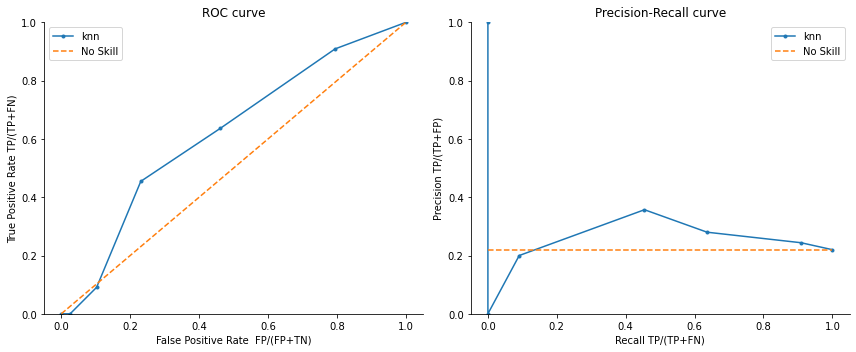

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.617716  0.260839     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


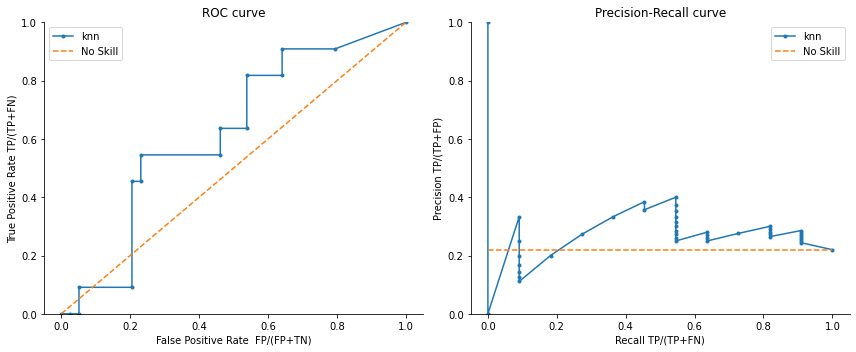

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.620047  0.265653     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


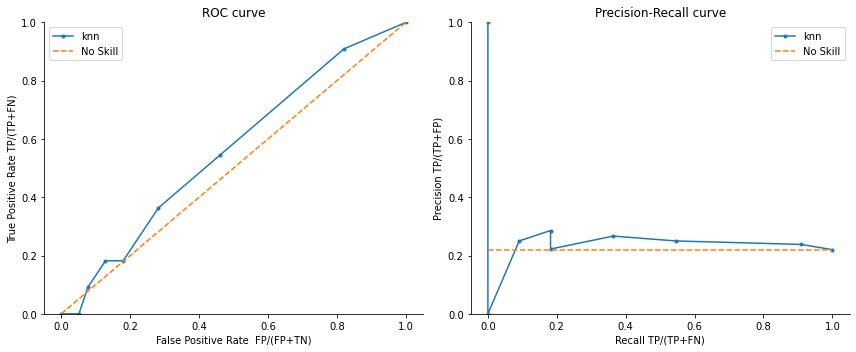

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.559441  0.236696  0.090909       0.25  0.133333   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


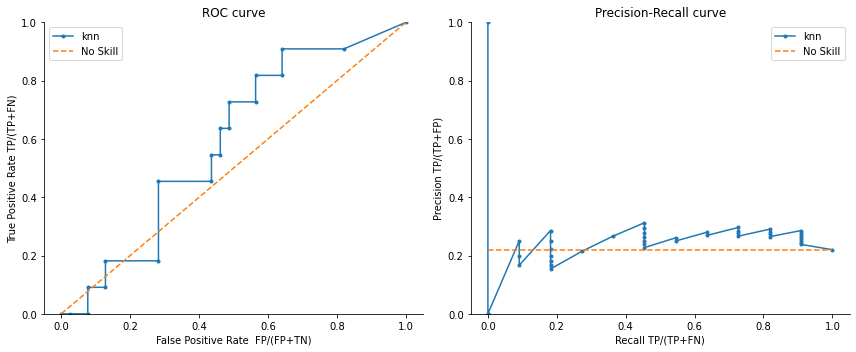

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.586247  0.239991  0.090909   0.166667  0.117647   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


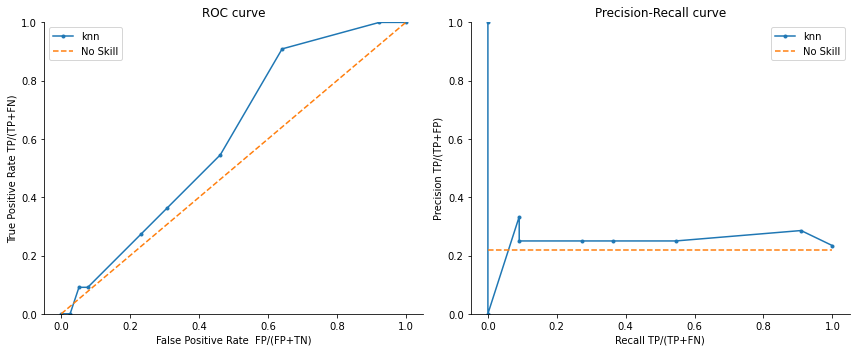

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.602564  0.249816     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


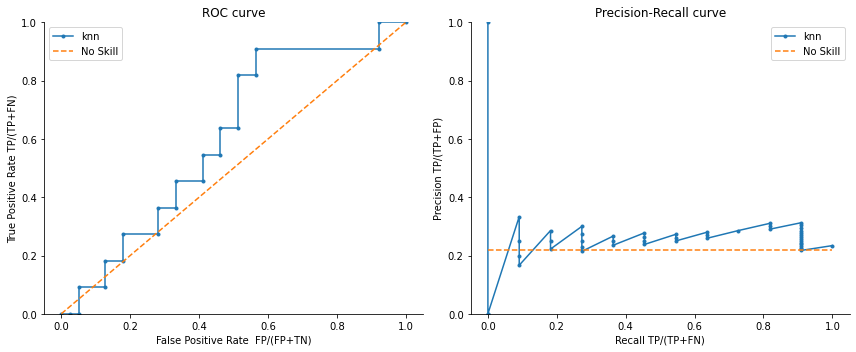

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.60373  0.251731     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


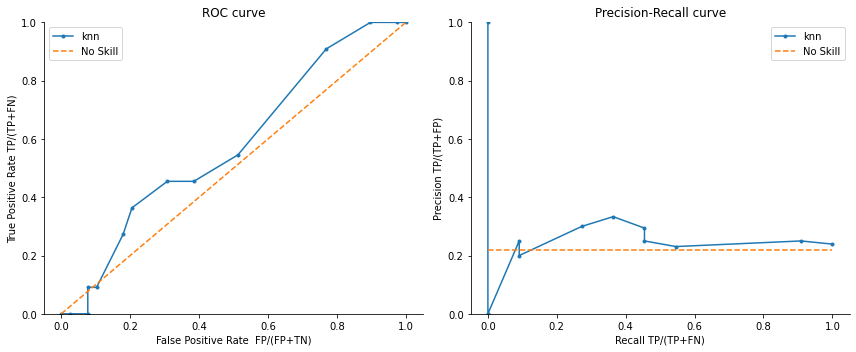

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.576923  0.245625     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


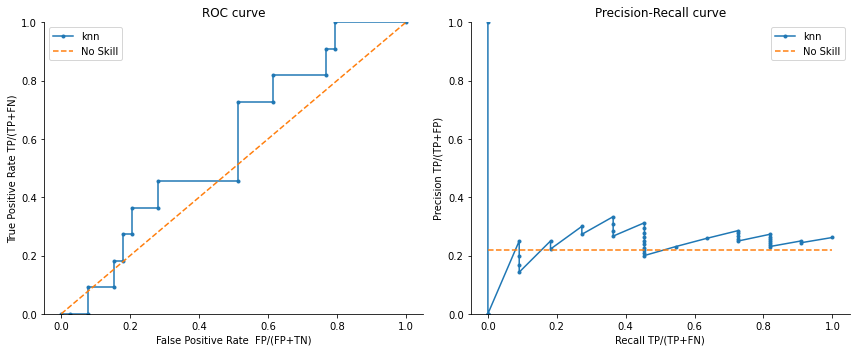

model  ROC AUC   PRC AUC    Recall  Presision        F1 counts for test data
0   knn  0.58042  0.242063  0.090909       0.25  0.133333       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


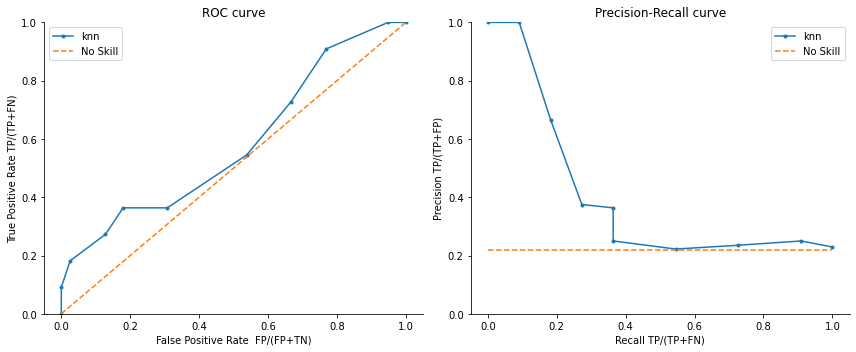

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.582751  0.398009     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


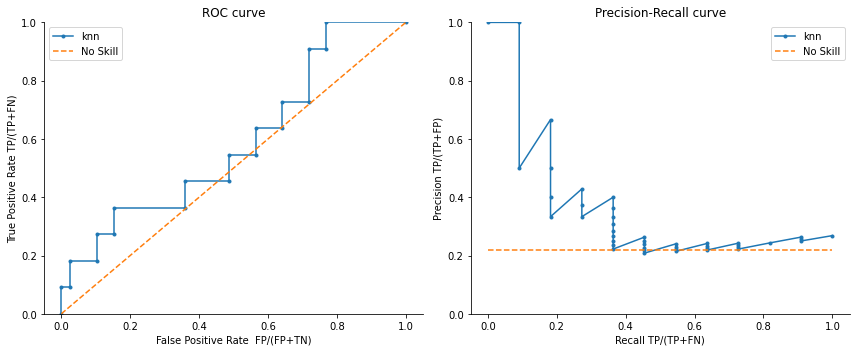

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587413  0.363755     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


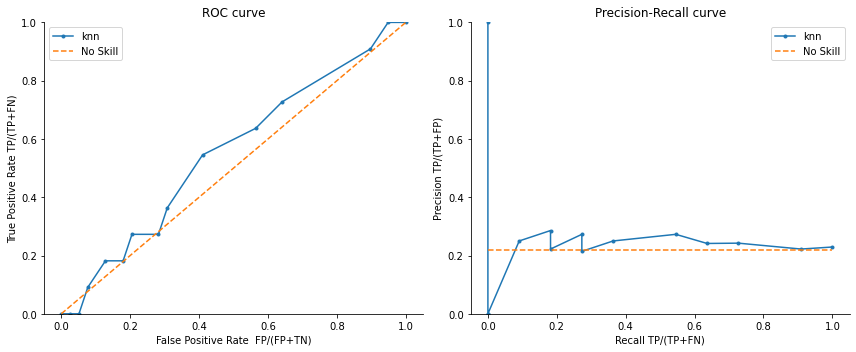

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.552448  0.234954     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


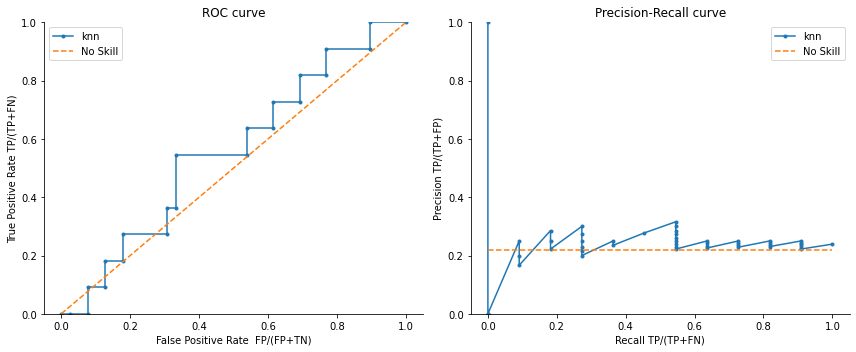

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.55711  0.234089     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


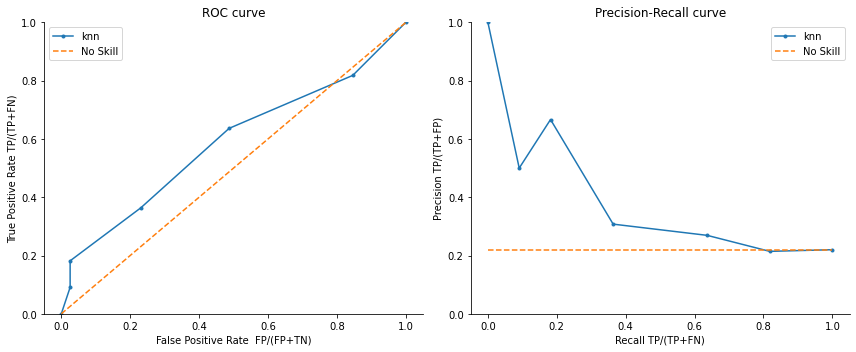

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.586247  0.371898     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


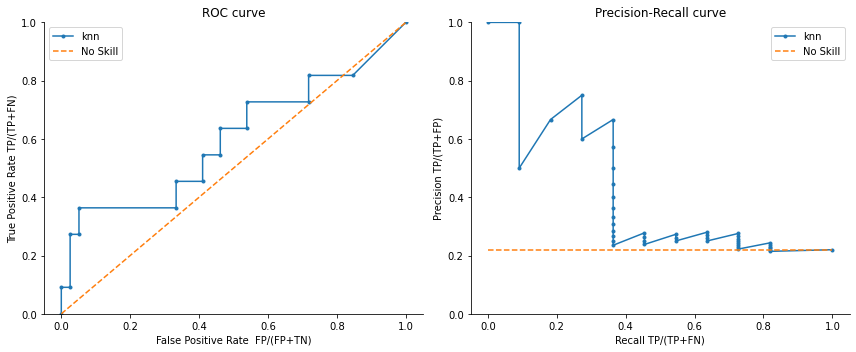

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.599068  0.421082  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


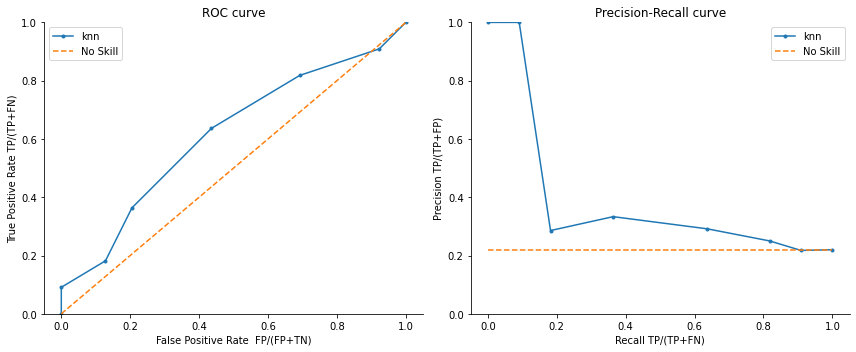

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.613054  0.381224  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


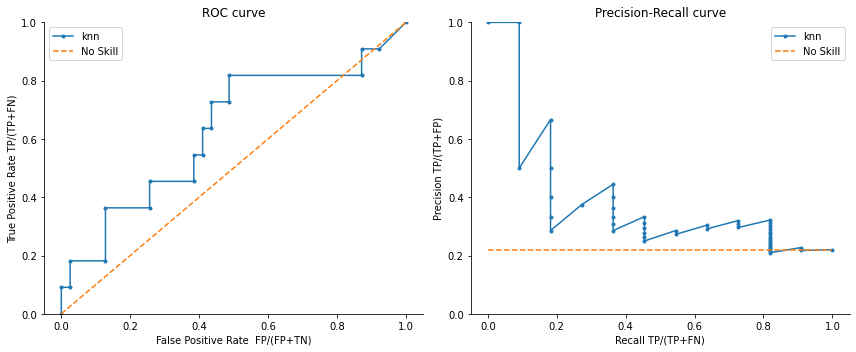

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.628205  0.385546  0.181818        0.5  0.266667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


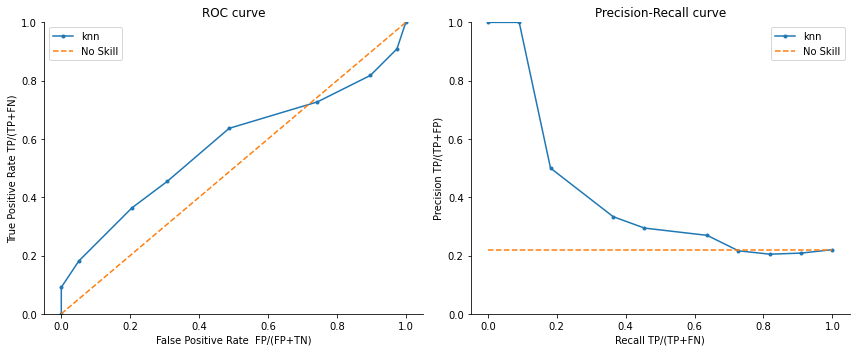

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.573427  0.394011     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


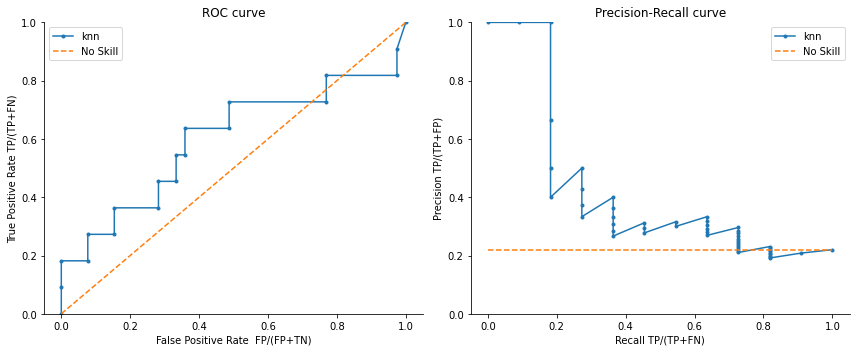

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.597902  0.421563     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


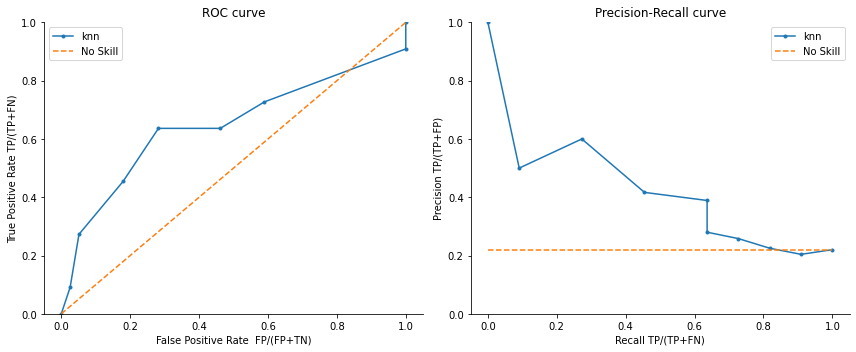

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.645688  0.419033     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


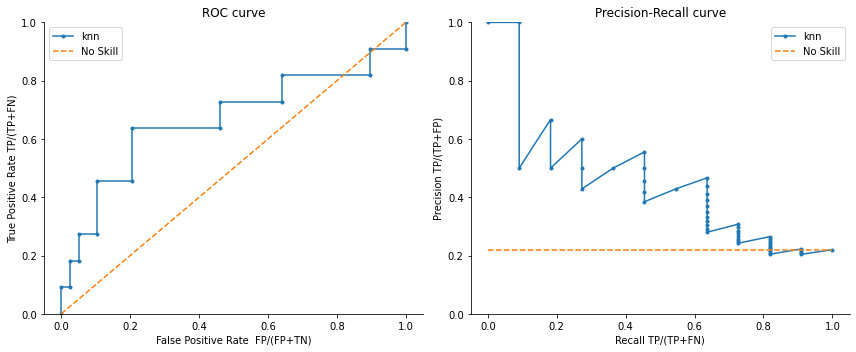

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.664336  0.450222     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


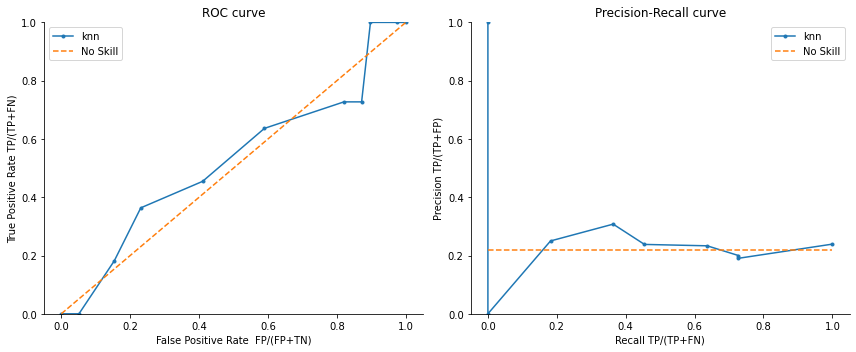

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.520979  0.219372     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


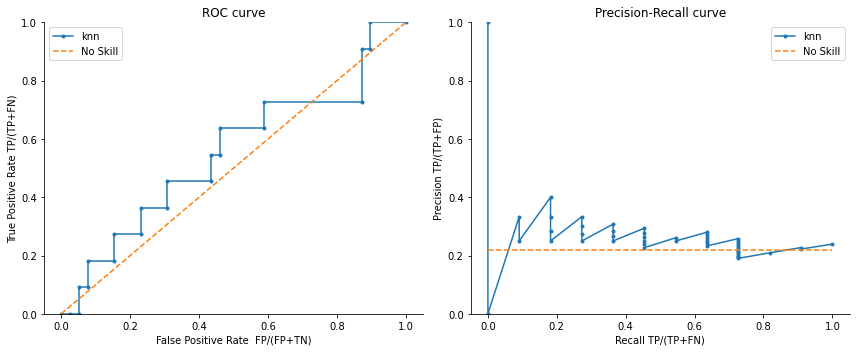

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.550117  0.248896     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


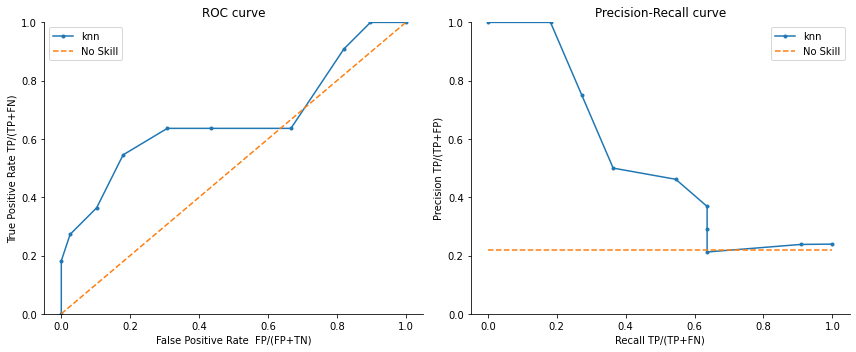

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.664336  0.526405     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


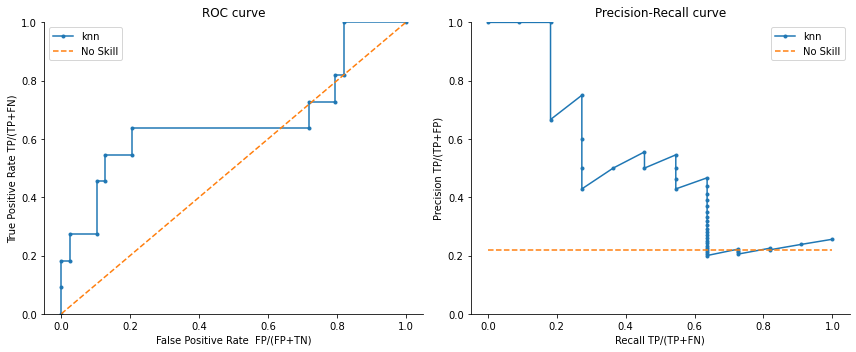

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.662005  0.506607     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


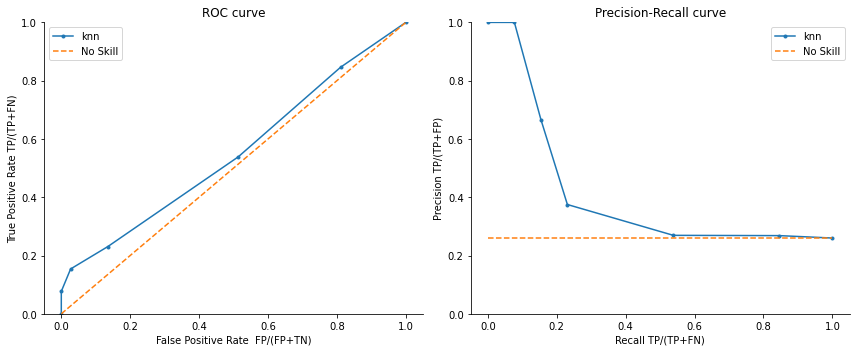

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.549896  0.403536     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


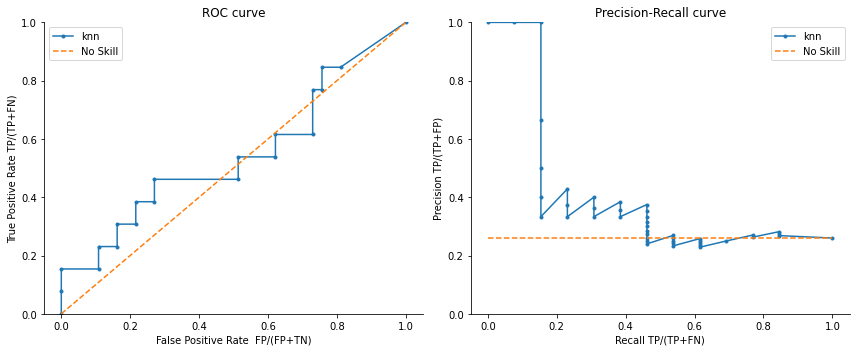

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.544699  0.404723  0.076923        1.0  0.142857   

  counts for test data  
0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


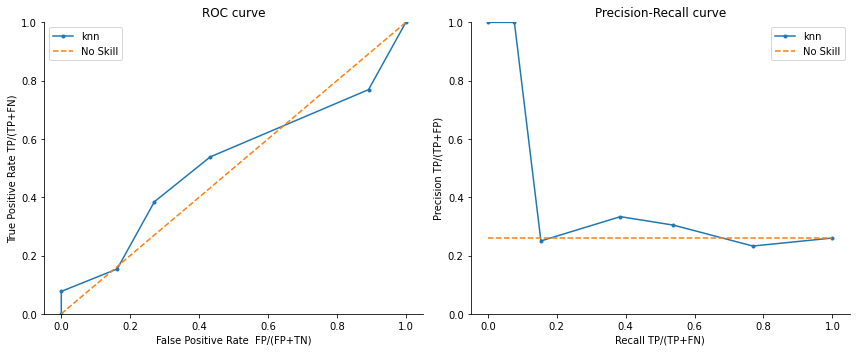

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.518711  0.360144     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


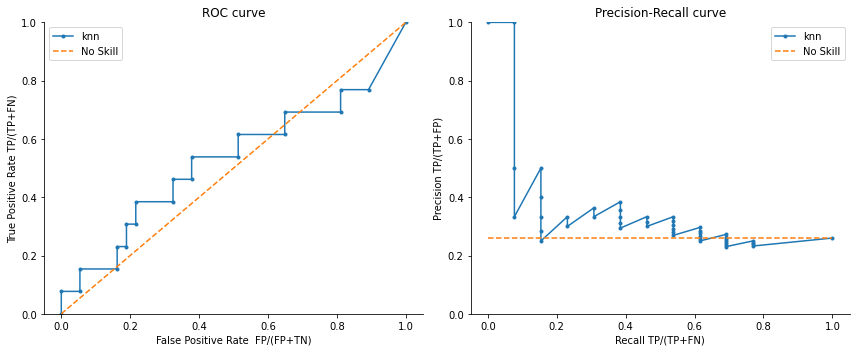

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.528067  0.350221     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


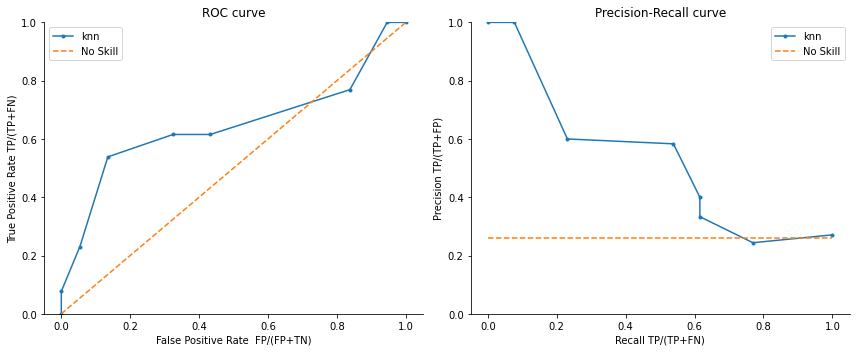

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.64553  0.523667     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


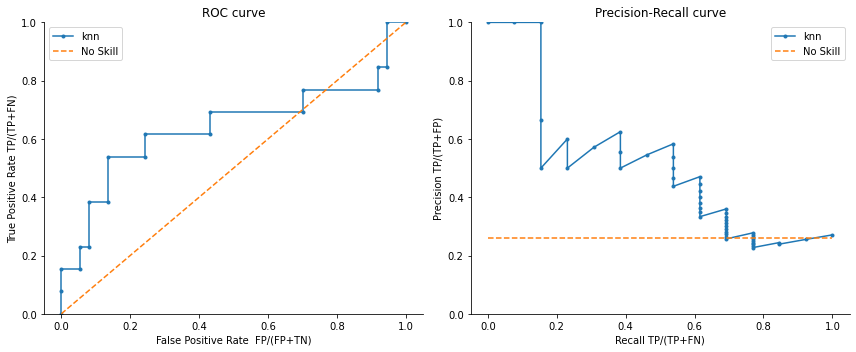

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.640333  0.506568     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


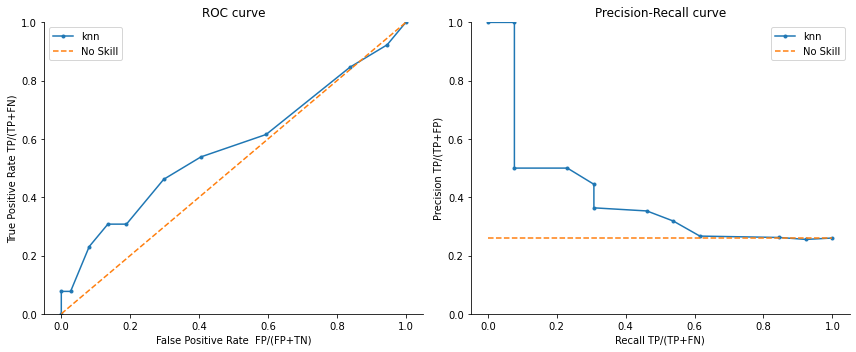

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.571726  0.394301     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


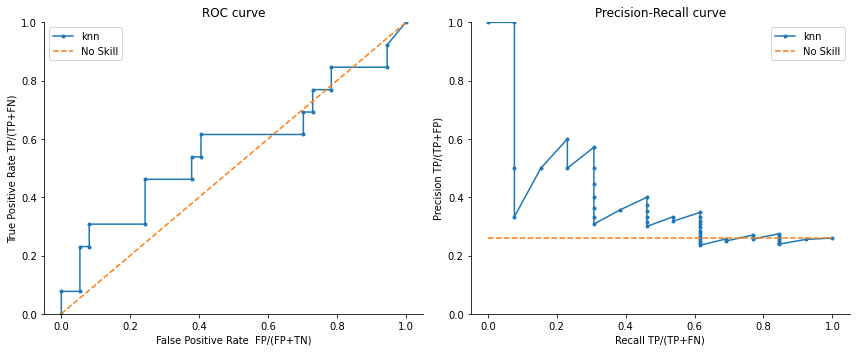

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.569647  0.395383     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


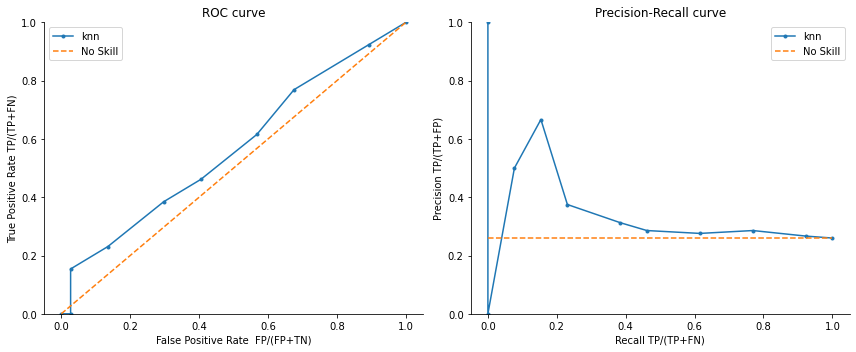

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.565489  0.329203     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


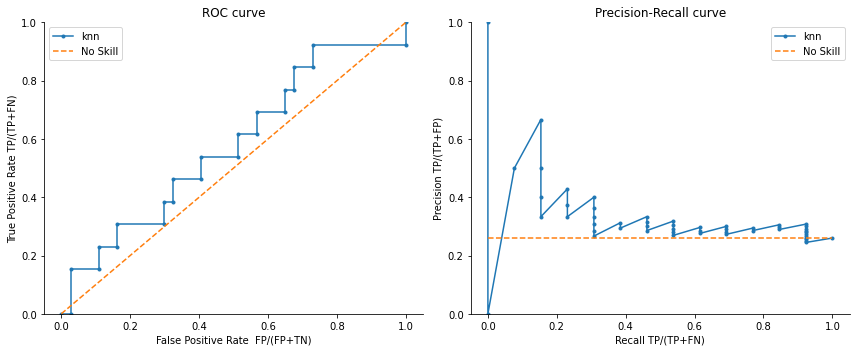

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.577963  0.322076     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


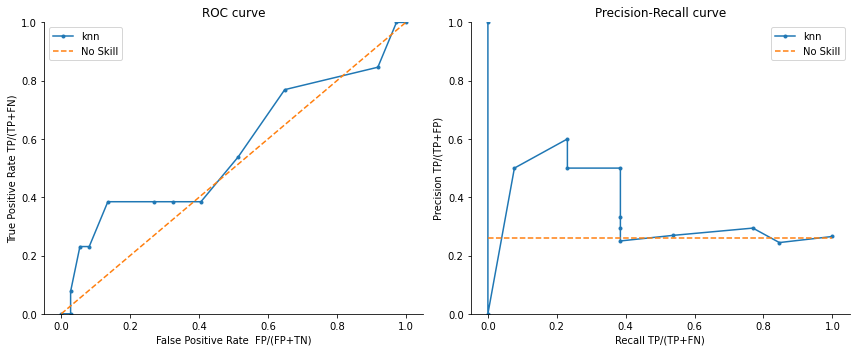

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.564449  0.345637     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


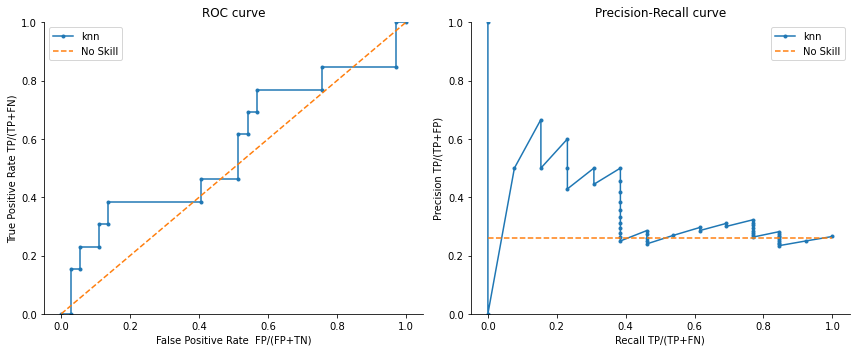

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.569647  0.346667     0.0        0.0  0.0       {0: 37, 1: 13}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


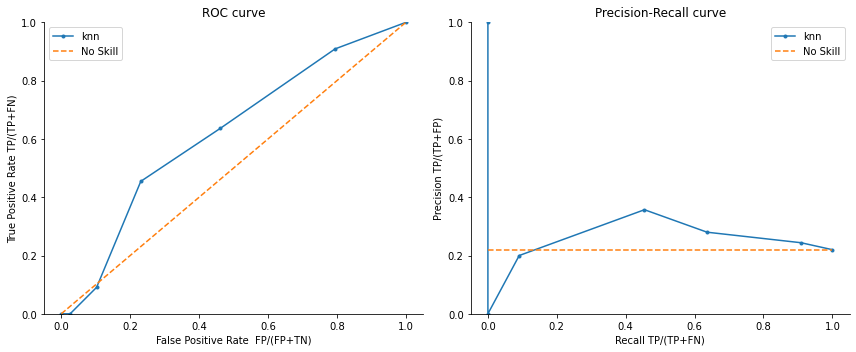

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.617716  0.260839     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


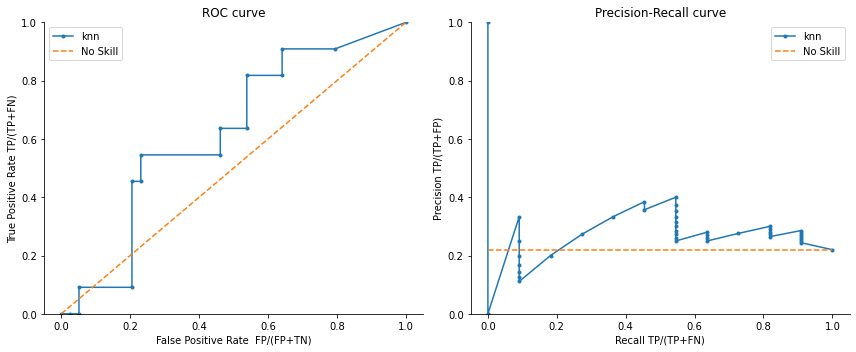

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.620047  0.265653     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


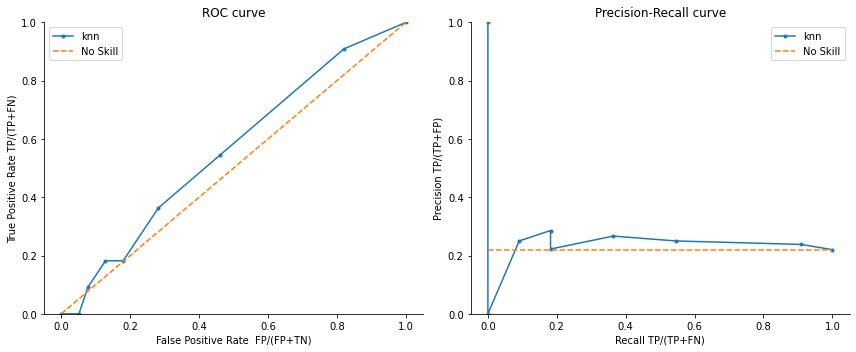

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.559441  0.236696  0.090909       0.25  0.133333   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


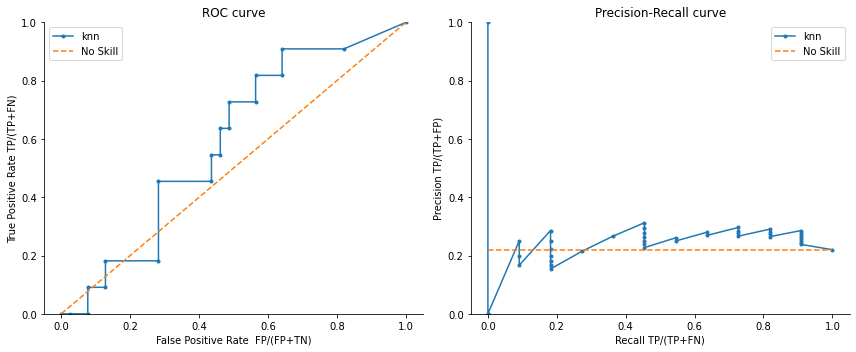

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.586247  0.239991  0.090909   0.166667  0.117647   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


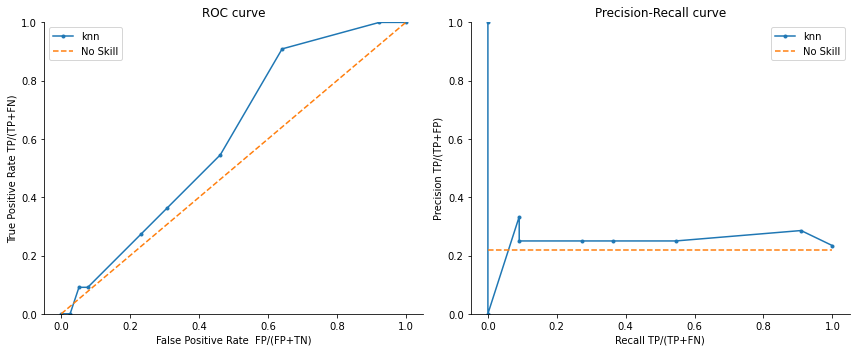

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.602564  0.249816     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


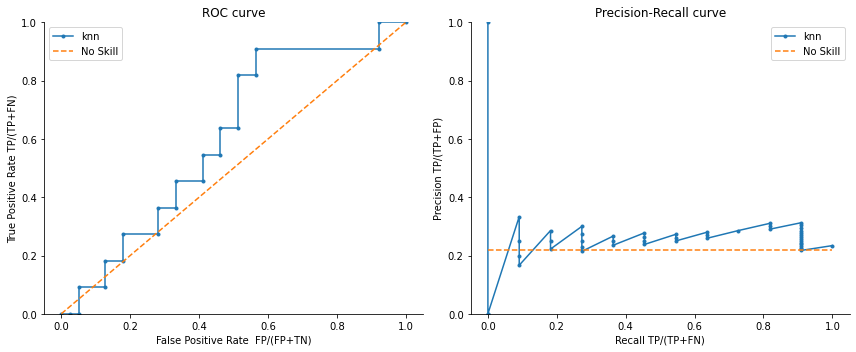

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.60373  0.251731     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


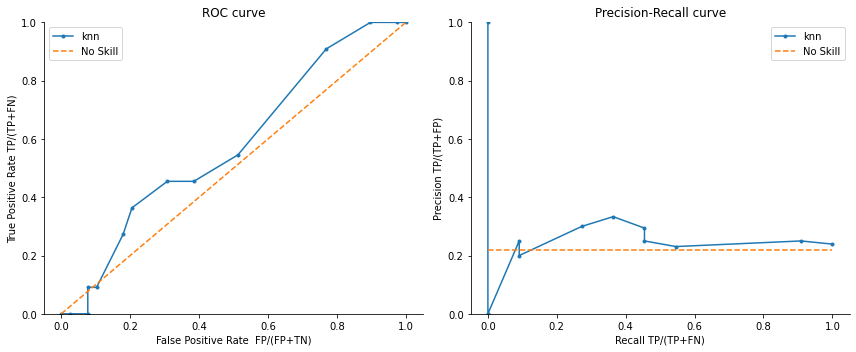

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.576923  0.245625     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


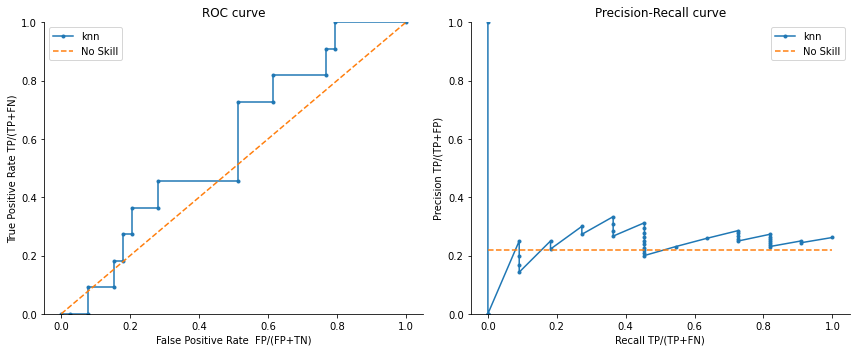

model  ROC AUC   PRC AUC    Recall  Presision        F1 counts for test data
0   knn  0.58042  0.242063  0.090909       0.25  0.133333       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


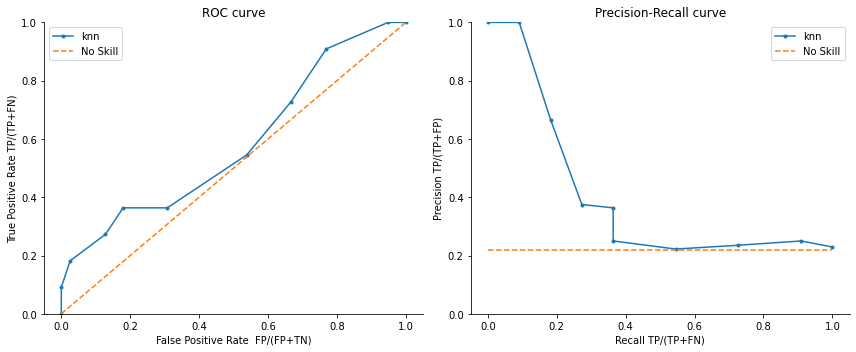

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.582751  0.398009     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


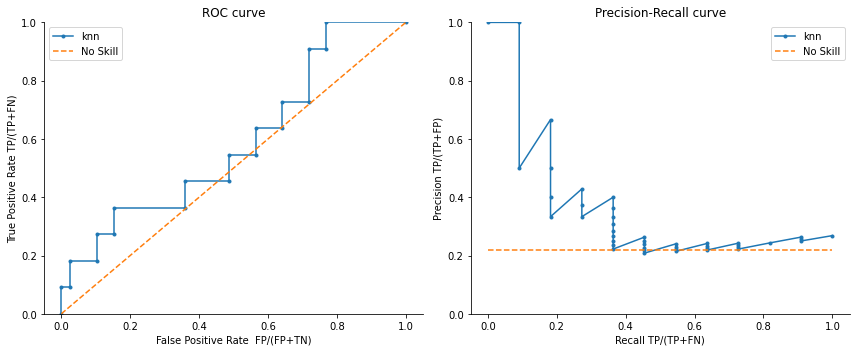

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.587413  0.363755     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


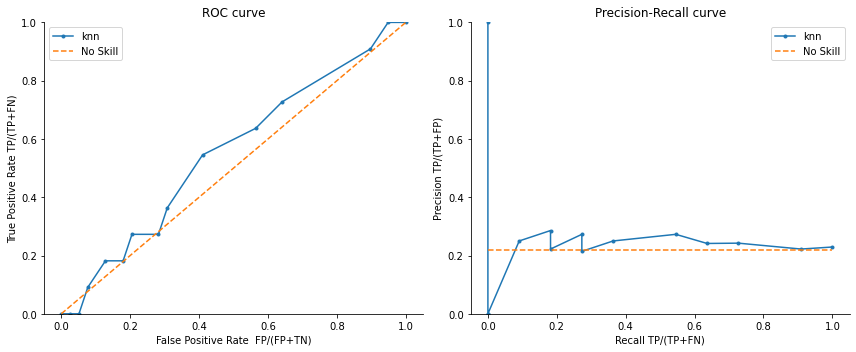

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.552448  0.234954     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


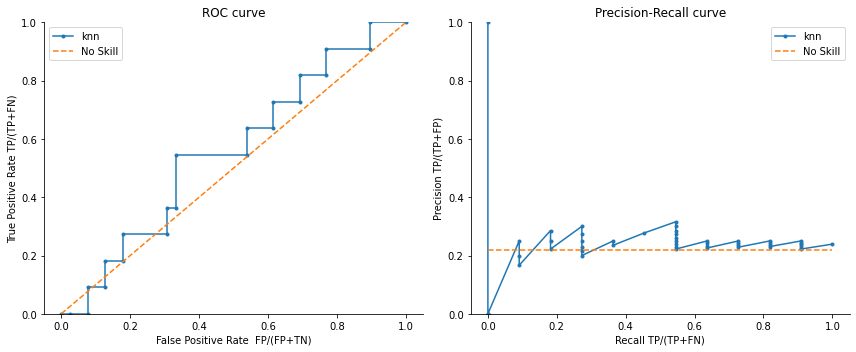

model  ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.55711  0.234089     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


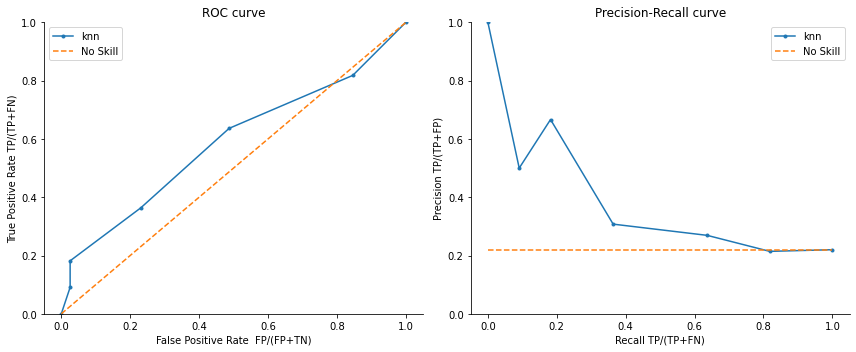

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.586247  0.371898     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'} 


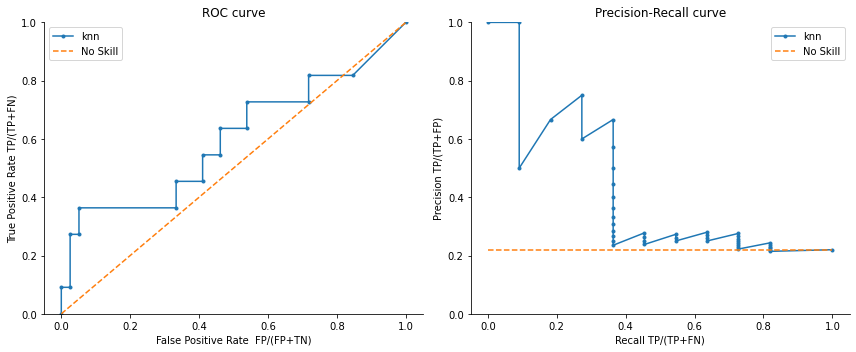

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.599068  0.421082  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 1, 'weights': 'distance'} 


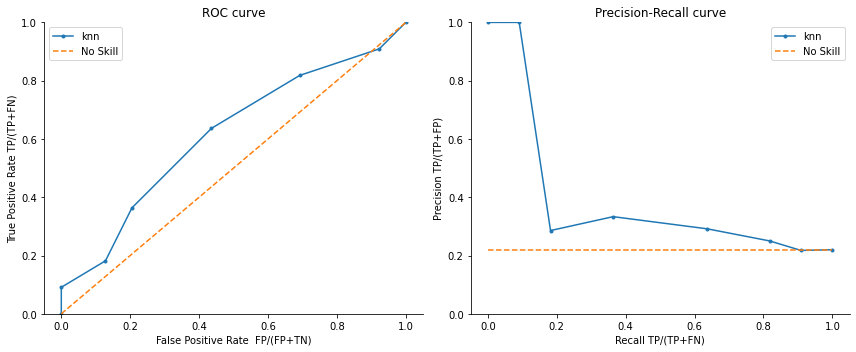

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.613054  0.381224  0.090909        1.0  0.166667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'} 


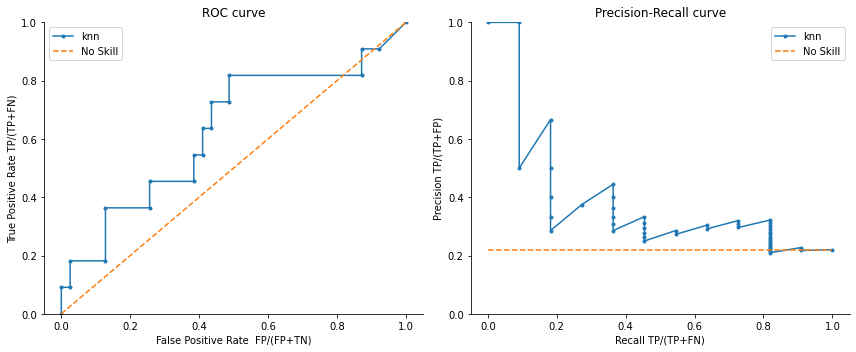

model   ROC AUC   PRC AUC    Recall  Presision        F1  \
0   knn  0.628205  0.385546  0.181818        0.5  0.266667   

  counts for test data  
0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 10, 'p': 2, 'weights': 'distance'} 


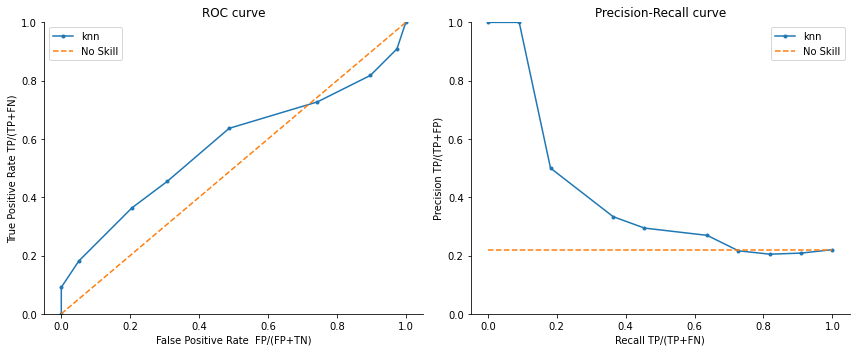

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.573427  0.394011     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 


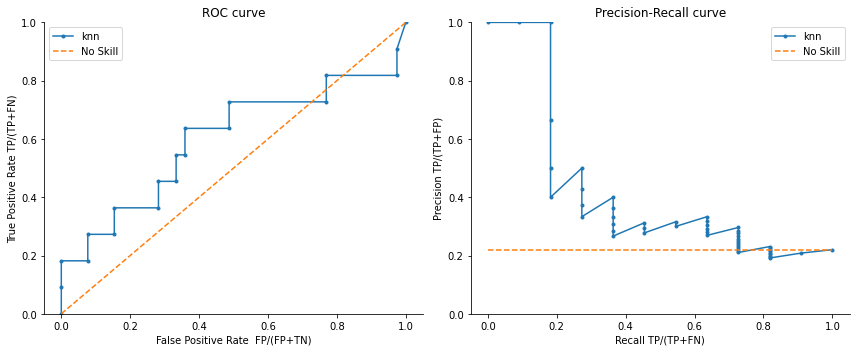

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.597902  0.421563     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 1, 'weights': 'distance'} 


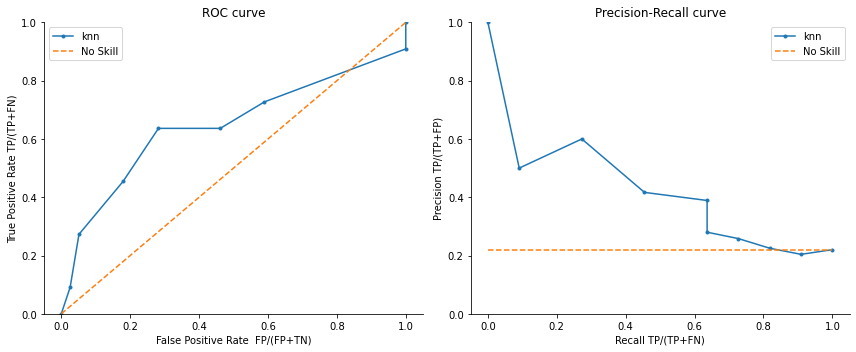

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.645688  0.419033     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'} 


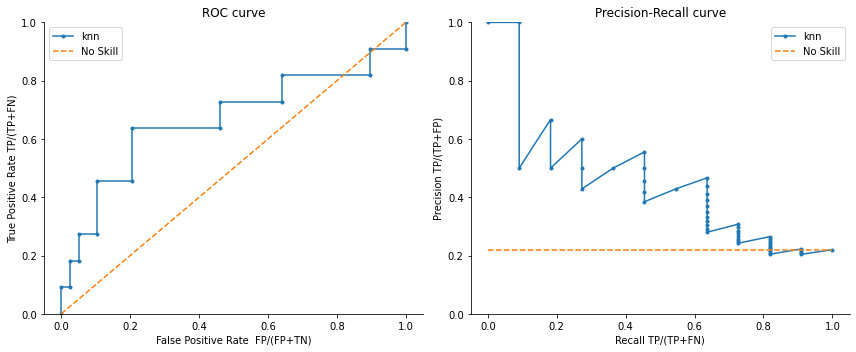

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.664336  0.450222     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 20, 'p': 2, 'weights': 'distance'} 


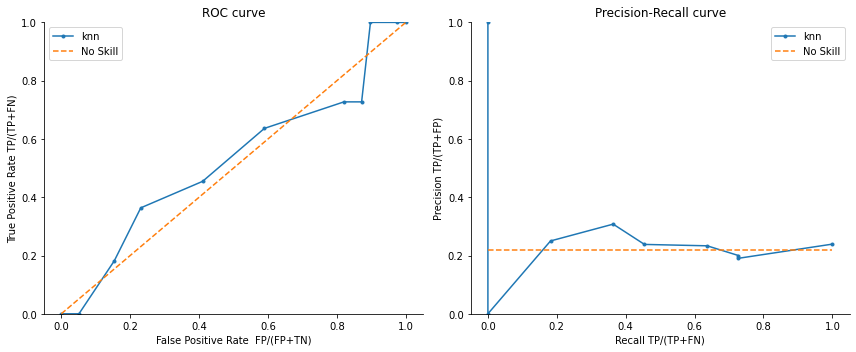

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.520979  0.219372     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'} 


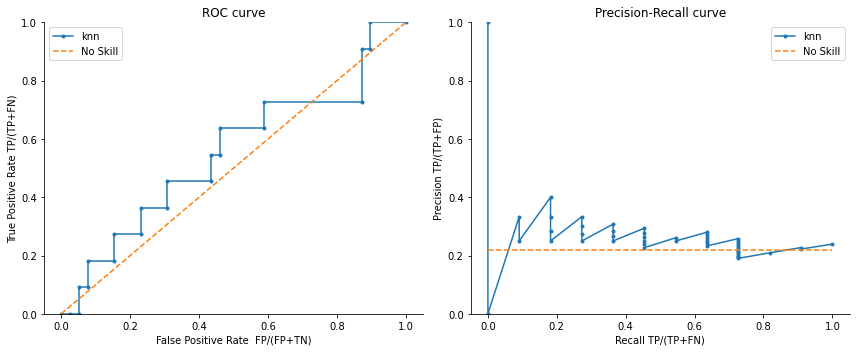

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.550117  0.248896     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 1, 'weights': 'distance'} 


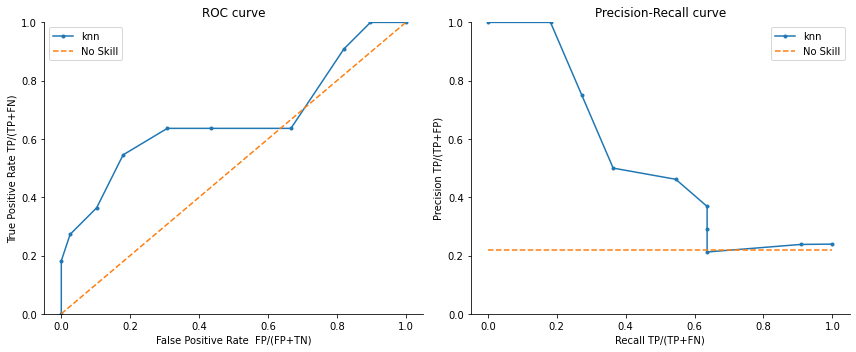

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.664336  0.526405     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'} 


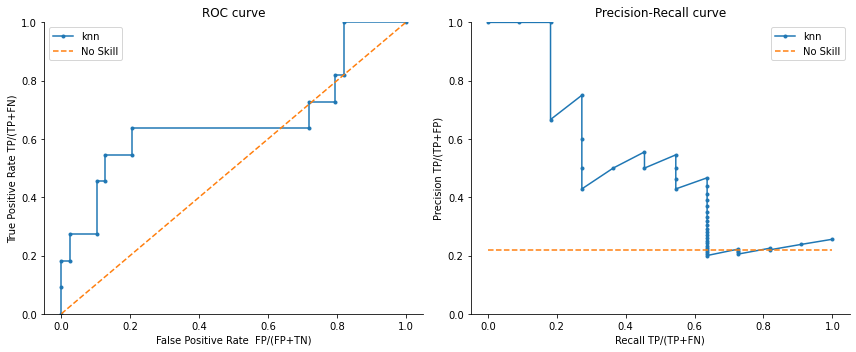

model   ROC AUC   PRC AUC  Recall  Presision   F1 counts for test data
0   knn  0.662005  0.506607     0.0        0.0  0.0       {0: 39, 1: 11}

P17_G2000_LOG_PCA - {'n_neighbors': 30, 'p': 2, 'weights': 'distance'} 


In [182]:
    
# to silence error on depreciated function, 
warnings.filterwarnings("ignore") # because skleanr generates waringing if precision and f1 are 0.0


for dataset_name in dataset_name_list:
    for rand_nr in rand_nr_list:
        ''' each dataset and random_nr is saved separately
            IDs correposnd to parameters, 
            and models with the same id's can be used to get means
        '''
        # empty lists for results 
        model_parameters = []
        model_predictions = []
        model_statistics = [] # roc auc, acc, spec, and sensitivity, later turned into pd.dataframe
  
        # loop over params
        model_id=-1 # to iniciate
        for model_params in param_grid:

            # setup
            model_id+=1
            model_fingerprint ={
                "model_name":model_name,
                "dataset_name":dataset_name,
                "rand_nr": rand_nr,
                "model_id":model_id,
                "model_params":model_params
            }
            # store params used for that model (to rerun it if required)
            model_parameters.append({
                **model_fingerprint,
                **model_params
                })
            
            # load data
            ''' here I am dealing with small data, 
                otherwise I woudl load them only once, per dataset/rand_nr
                and check for modificaitons, 
            ''' 
            x_train, x_valid, x_test, y_train, y_valid = load_dataset_dct(
                dataset_name, path, rand_nr, none_at=none_at)
            
            # baseline
            dummy_clf = DummyClassifier(strategy="most_frequent")
            dummy_clf.fit(x_train, y_train)
            
            # set params & fit model
            model.set_params(**model_params)
            model.fit(x_train, y_train)
            
            # . generate and store predictions
            model_predictions.append({
                **model_fingerprint,
                'predicitons_baseline': prediction_table(dummy_clf, x_train, y_train, **model_fingerprint),
                'predicitons_train': prediction_table(model, x_train, y_train, **model_fingerprint),
                'predictions_valid': prediction_table(model, x_valid, y_valid, **model_fingerprint),
                'predicitons_test': prediction_table(model, x_test, None, **model_fingerprint),
            })
                
            # Stats - one_model_statistics (oms)
            #oms = calculate_stats( model, x_train, y_train, prefix="train", verbose=False)
            #oms = calculate_stats( model, x_valid, y_valid, prefix="test", verbose=False)
            
            oms_df = train_models(
                trainX = x_train, 
                testX = x_valid, 
                trainy = y_train, 
                testy = y_valid, 
                models = {"knn":model}, 
                plot_title="", 
                figsize=(12,5), 
                positive_class=1
            );
            display(oms_df)
        
            # INFO, ...............................................
            
            # print accuracy
            if verbose==True:
                print(f'''{dataset_name} - {model_params} ''')
                #print(f'''----- - Acc: baseline: {np.round(oms['acc_valid_baseline'],2)}, Train: {np.round(oms['acc_train'],2)}, Valid {np.round(oms['acc_valid'],2)}''')
            else:
                pass        
        
            #report = classification_report(y_true=y_valid, y_pred=model.predict(x_valid))
            #print(report)

        

In [142]:
        train_models(
    trainX, testX, trainy, testy, models, 
    plot_title="", figsize=(12,5), positive_class=1)
        


        


model_name       dataset_name  rand_nr  model_id  \
0        knn  P17_G2000_LOG_PCA        2         0   

                                        model_params  n_neighbors  p   weights  
0  {'n_neighbors': 20, 'p': 2, 'weights': 'distan...           20  2  distance

In [128]:
model_stats

[{'model_name': 'knn',
  'dataset_name': 'P17_G2000_LOG_PCA',
  'rand_nr': 2,
  'model_id': 0,
  'model_params': {'n_neighbors': 20, 'p': 2, 'weights': 'distance'},
  'acc_train': 1.0,
  'acc_valid': 0.78}]

In [95]:
#clf = LogisticRegression(solver='liblinear') # the solver must be specified, otherwise it wil raise an error, 
#clf = RandomForestClassifier(max_depth=10, n_estimators=500)  


# stats
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
data_cov_test =  load_tsv(PATH_data_raw, 'X_covariates_test.tsv')
data_genes_test = load_tsv(PATH_data_raw, 'X_genes_test.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

# small correction
target = pd.Series(target.iloc[:,0])


# create test/validation dataset

n = 50
path = PATH_data_interim
random_nr = 1

# . set seed
np.random.seed(random_nr)

# . create idx, for test/valid datasets
idx_list = list(range(target.shape[0]))
np.random.shuffle(idx_list)

valid_idx = idx_list[0:n]; print(len(valid_idx))
train_idx = idx_list[n:200]; print(len(train_idx))

target_valid = target.iloc[valid_idx]
target_valid.reset_index(inplace=True, drop=True)

target_train = target.iloc[train_idx]
target_train.reset_index(inplace=True, drop=True)



print(target_train.value_counts())
print(target_valid.value_counts())

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# train model ..................................
model = LogisticRegression(solver='liblinear') # the solver must be specified, otherwise it wil raise an error, 
model = RandomForestClassifier(max_depth=10, n_estimators=500)   
    
# Fit it to train data
model.fit(x_train, y_train)

# print accuracy
print(f'Train Accuracy: {model.score(x_train, y_train)}')
print(f'Test Accuracy: {model.score(x_valid, y_valid)}')

report = classification_report(y_true=y_valid, y_pred=model.predict(x_valid))
print(report)

model

Train Accuracy: 1.0
Test Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       0.00      0.00      0.00         8

    accuracy                           0.80        40
   macro avg       0.40      0.50      0.44        40
weighted avg       0.64      0.80      0.71        40



/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pawel/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

RandomForestClassifier(max_depth=10, n_estimators=500)

In [ ]:

# parameters used to train skilearn dn cnn tranfer learning models
MODEL_PARAMETERS_GRID = {
    
    "knn" : ParameterGrid([
        {     
            'method_group':   ["sklearn_models"],   # for all classical models, 
            'method_variant': ["no_pca"],       # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'n_neighbors':    list(range(2,10,2)),    # I do not use k==1, ! # I tried higher values and they were not very usefull
            'weights':        ['uniform','distance'], # Weighting function
            'p':              [2],                  # L1 and L2 distance metrics
            'pca':            [0],                  # is 0, no PCA applied, 
            'random_state_nr':[0],                  # in the list
            'pc': [['n_neighbors', 'weights', 'p']] # parameter names in the grid for classifier, (list in list)
        },
        {
            'method_group':   ["sklearn_models"],   # for all classical models, 
            'method_variant': ["pca"],          # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'n_neighbors':    list(range(2,10,2)),                  # I do not use k==1, ! # I tried higher values and they were not very usefull
            'weights':        ['uniform','distance'],          # Weighting function
            'p':              [2],                  # L1 and L2 distance metrics
            'pca':            [250],                # is 0, no PCA applied, 
            'random_state_nr':[0],                  # in the list
            'pc': [['n_neighbors', 'weights', 'p']] # parameter names in the grid for classifier, (list in list)  
        }
        ]), 
    
    
    'random_forest': ParameterGrid([
        {
            'method_group': ["sklearn_models"],     # for all classical models, 
            'method_variant': ["no_pca"],           # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'random_state_nr':[0],
            'max_depth':[4,5,6],
            'n_estimators': [10,25,50,100,150, 200],
            'class_weight': ['balanced'],
            'pca':[0],
            'pc':[['n_estimators', 'max_depth', 'class_weight']]
        },
        {
            'method_group': ["sklearn"],           # for all classical models, 
            'method_variant': ["pca"],           # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'random_state_nr':[0],
            'max_depth':[4,5,6],
            'n_estimators': [10,25,50,100,150, 200],
            'class_weight': ['balanced'],
            'pca':[30, 200],
            'pc':[['n_estimators', 'max_depth', 'class_weight']]
        }
       ]),

In [ ]:


from sklearn.model_selection import ParameterGrid


# parameters used to train skilearn dn cnn tranfer learning models
MODEL_PARAMETERS_GRID = {
    
    "knn" : ParameterGrid([
        {     
            'method_group':   ["sklearn_models"],   # for all classical models, 
            'method_variant': ["no_pca"],       # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'n_neighbors':    list(range(2,10,2)),    # I do not use k==1, ! # I tried higher values and they were not very usefull
            'weights':        ['uniform','distance'], # Weighting function
            'p':              [2],                  # L1 and L2 distance metrics
            'pca':            [0],                  # is 0, no PCA applied, 
            'random_state_nr':[0],                  # in the list
            'pc': [['n_neighbors', 'weights', 'p']] # parameter names in the grid for classifier, (list in list)
        },
        {
            'method_group':   ["sklearn_models"],   # for all classical models, 
            'method_variant': ["pca"],          # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'n_neighbors':    list(range(2,10,2)),                  # I do not use k==1, ! # I tried higher values and they were not very usefull
            'weights':        ['uniform','distance'],          # Weighting function
            'p':              [2],                  # L1 and L2 distance metrics
            'pca':            [250],                # is 0, no PCA applied, 
            'random_state_nr':[0],                  # in the list
            'pc': [['n_neighbors', 'weights', 'p']] # parameter names in the grid for classifier, (list in list)  
        }
        ]), 
    
    
    'random_forest': ParameterGrid([
        {
            'method_group': ["sklearn_models"],     # for all classical models, 
            'method_variant': ["no_pca"],           # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'random_state_nr':[0],
            'max_depth':[4,5,6],
            'n_estimators': [10,25,50,100,150, 200],
            'class_weight': ['balanced'],
            'pca':[0],
            'pc':[['n_estimators', 'max_depth', 'class_weight']]
        },
        {
            'method_group': ["sklearn"],           # for all classical models, 
            'method_variant': ["pca"],           # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'random_state_nr':[0],
            'max_depth':[4,5,6],
            'n_estimators': [10,25,50,100,150, 200],
            'class_weight': ['balanced'],
            'pca':[30, 200],
            'pc':[['n_estimators', 'max_depth', 'class_weight']]
        }
       ]),
    
    "dense_nn" : ParameterGrid([{
            # ... for method classyficaiton 
            'method_group':   ["cnn_transfer_learning"],           # for all classical models, 
            'method_variant': ["two_layers_Adam"],                          # eg: SVM has linear or rbf, or typically pca or not, (nothing)
            'random_state_nr':[0],
            'pca':[0],
            # ...for cnn
            "model":["two_layers"],
            # ..
            "h1_unit_size":[36, 72, 144, 288],
            "h1_Dropout" : [0.5],
            "h1_activation": ["relu"],
            # ...
            "out_activation":["softmax"],
            "optimizer":["Adam"],
            "metrics": [["acc"]],
            # ...
            'fit__batch_size' : [16, 32, 64, 128],
            "EarlyStopping__patience": [3],
            "fit__epoch": [100]   
        }])
     
    }       